# Libraries and data loading

In [240]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import time

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import fbeta_score
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from xgboost import XGBClassifier

from lightgbm import LGBMClassifier

from pactools.grid_search import GridSearchCVProgressBar

import optuna
from optuna.distributions import IntUniformDistribution as IntUnifDistr
from optuna.distributions import UniformDistribution as UnifDistr
from optuna.distributions import LogUniformDistribution as LogUnifDistr
from optuna.distributions import CategoricalDistribution as CategDistr

In [2]:
# Load preprocessed data
df = pd.read_csv('combined_light2_df.csv')

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
# drop col 'Unnamed: 0'
print(df.shape)
df.drop(columns=['Unnamed: 0'], inplace=True)
print(df.shape)

(307507, 130)
(307507, 129)


In [4]:
# replace infinite values by NaN
print(df.isna().sum().sum())
df[df==np.inf]=np.nan
print(df.isna().sum().sum())

6714374
6726480


In [5]:
# define X and y
X = df.iloc[:,2:]
y = df.iloc[:,1]
print(X.shape)
print(y.shape)

(307507, 127)
(307507,)


C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [499]:
# define binary and non-binary features
bin_feat = []
bin_names = []
non_bin_feat = []
non_bin_names = []
for col in X.columns:
    if X[col].min() == 0 and X[col].max() == 1:
        bin_feat.append(X.columns.get_loc(col))
        bin_names.append(col)
    else:
        non_bin_feat.append(X.columns.get_loc(col))
        non_bin_names.append(col)
print(len(bin_feat))
print(len(non_bin_feat))

54
73


In [114]:
# define binary and non-binary features
#bin_feat = []
#non_bin_feat = []
#for col in X.columns:
#    if X[col].min() == 0 and X[col].max() == 1:
#        bin_feat.append(col)
#    else:
#        non_bin_feat.append(col)
#print(len(bin_feat))
#print(len(non_bin_feat))

# Stratified subsampling and train test split
## train test split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [8]:
# Check that size = 70%
print(X_train.shape)
print(y_train.shape)
print(0.7*X.shape[0])

(215254, 127)
(215254,)
215254.9


C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0    0.919272
1    0.080728
Name: TARGET, dtype: float64
--------------------


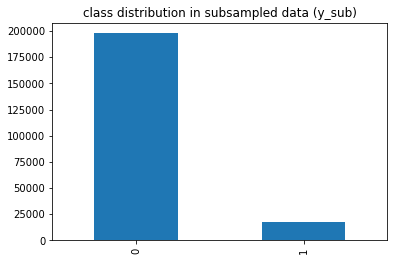

In [9]:
# Check that class proportion is preserved
print(y_train.value_counts() / y_train.shape[0])
print('-' * 20)
y_train.value_counts().plot(kind='bar', title='class distribution in subsampled data (y_sub)')

0    0.91927
1    0.08073
Name: TARGET, dtype: float64
--------------------


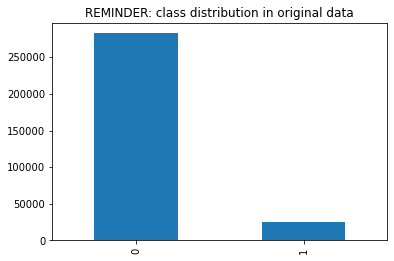

In [10]:
# Compared to original data
print(df['TARGET'].value_counts() / df.shape[0])
print('-' * 20)
df['TARGET'].value_counts().plot(kind='bar', title='REMINDER: class distribution in original data')

## subsampling of train split

In [12]:
X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_train, y_train, train_size= 0.3, test_size=0.3*0.3,
                                                                    random_state=0, stratify=y_train)

In [13]:
# Check sizes
print(X_sub_train.shape)
print(y_sub_train.shape)
print(X_sub_test.shape)
print(y_sub_test.shape)

(64576, 127)
(64576,)
(19373, 127)
(19373,)


0    0.919273
1    0.080727
Name: TARGET, dtype: float64
--------------------


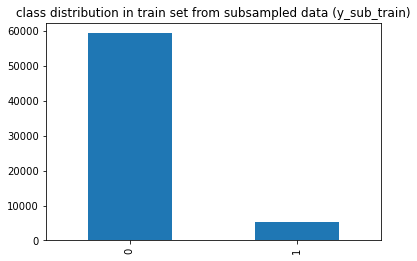

In [14]:
# Check that class proportion is preserved
print(y_sub_train.value_counts() / y_sub_train.shape[0])
print('-' * 20)
y_sub_train.value_counts().plot(kind='bar', title='class distribution in train set from subsampled data (y_sub_train)')

0    0.919269
1    0.080731
Name: TARGET, dtype: float64
--------------------


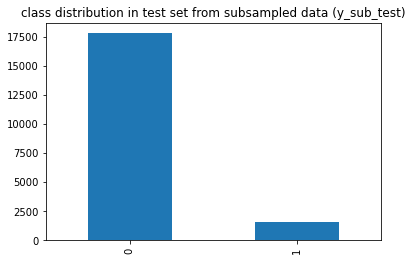

In [15]:
# Check that class proportion is preserved
print(y_sub_test.value_counts() / y_sub_test.shape[0])
print('-' * 20)
y_sub_test.value_counts().plot(kind='bar', title='class distribution in test set from subsampled data (y_sub_test)')

# Model selection
## v1 - deal or not with imbalance, auc

In [10]:
non_bin_scaler = make_column_transformer((StandardScaler(), non_bin_feat), remainder='passthrough')

In [31]:
pipe = Pipeline([('imputer', SimpleImputer()),
                 ('scaler', non_bin_scaler),
                 ('sampler', SMOTE()),
                 ('classifier', LogisticRegression())])

In [32]:
model_list = []
mean_train_score_list = []
mean_train_time_list = []
mean_test_score_list = []
mean_test_time_list = []

### Binary classification baseline: logistic regression

In [33]:
param_grid_logireg = {'imputer': [SimpleImputer(missing_values=np.nan, strategy='median')],
                      'scaler': [non_bin_scaler],
                      'sampler': [SMOTE(), RandomUnderSampler(), 'passthrough'],
                      'classifier': [LogisticRegression()],
                      'classifier__class_weight': [True, False]}

In [34]:
grid_logireg = GridSearchCV(pipe,
                            param_grid=param_grid_logireg,
                            return_train_score=True,
                            scoring='roc_auc',
                            cv=5, # For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. 
                            verbose=3)

In [35]:
grid_logireg.fit(X_sub_train, y_sub_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END classifier=LogisticRegression(), classifier__class_weight=True, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.753, test=0.758) total time=   2.4s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END classifier=LogisticRegression(), classifier__class_weight=True, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.755, test=0.753) total time=   2.3s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END classifier=LogisticRegression(), classifier__class_weight=True, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.757, test=0.741) total time=   2.4s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END classifier=LogisticRegression(), classifier__class_weight=True, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.759, test=0.736) total time=   2.4s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END classifier=LogisticRegression(), classifier__class_weight=True, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.757, test=0.744) total time=   2.8s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END classifier=LogisticRegression(), classifier__class_weight=True, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.757, test=0.765) total time=   1.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END classifier=LogisticRegression(), classifier__class_weight=True, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.760, test=0.758) total time=   0.9s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END classifier=LogisticRegression(), classifier__class_weight=True, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.762, test=0.746) total time=   0.9s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END classifier=LogisticRegression(), classifier__class_weight=True, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.762, test=0.745) total time=   0.8s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END classifier=LogisticRegression(), classifier__class_weight=True, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.763, test=0.750) total time=   0.8s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END classifier=LogisticRegression(), classifier__class_weight=True, imputer=SimpleImputer(strategy='median'), sampler=passthrough, scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.760, test=0.769) total time=   1.3s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END classifier=LogisticRegression(), classifier__class_weight=True, imputer=SimpleImputer(strategy='median'), sampler=passthrough, scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.762, test=0.760) total time=   1.4s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END classifier=LogisticRegression(), classifier__class_weight=True, imputer=SimpleImputer(strategy='median'), sampler=passthrough, scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.764, test=0.749) total time=   1.5s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END classifier=LogisticRegression(), classifier__class_weight=True, imputer=SimpleImputer(strategy='median'), sampler=passthrough, scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.765, test=0.747) total time=   1.5s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END classifier=LogisticRegression(), classifier__class_weight=True, imputer=SimpleImputer(strategy='median'), sampler=passthrough, scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.764, test=0.752) total time=   1.4s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END classifier=LogisticRegression(), classifier__class_weight=False, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.753, test=0.758) total time=   2.3s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END classifier=LogisticRegression(), classifier__class_weight=False, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.755, test=0.754) total time=   2.3s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END classifier=LogisticRegression(), classifier__class_weight=False, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.757, test=0.741) total time=   2.4s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END classifier=LogisticRegression(), classifier__class_weight=False, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.759, test=0.737) total time=   2.3s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END classifier=LogisticRegression(), classifier__class_weight=False, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.757, test=0.744) total time=   2.3s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END classifier=LogisticRegression(), classifier__class_weight=False, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.758, test=0.767) total time=   0.8s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END classifier=LogisticRegression(), classifier__class_weight=False, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.760, test=0.756) total time=   0.9s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END classifier=LogisticRegression(), classifier__class_weight=False, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.762, test=0.747) total time=   0.9s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END classifier=LogisticRegression(), classifier__class_weight=False, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.763, test=0.745) total time=   0.9s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END classifier=LogisticRegression(), classifier__class_weight=False, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.762, test=0.750) total time=   0.9s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END classifier=LogisticRegression(), classifier__class_weight=False, imputer=SimpleImputer(strategy='median'), sampler=passthrough, scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.760, test=0.769) total time=   1.6s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END classifier=LogisticRegression(), classifier__class_weight=False, imputer=SimpleImputer(strategy='median'), sampler=passthrough, scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.762, test=0.760) total time=   1.3s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END classifier=LogisticRegression(), classifier__class_weight=False, imputer=SimpleImputer(strategy='median'), sampler=passthrough, scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.764, test=0.749) total time=   1.3s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END classifier=LogisticRegression(), classifier__class_weight=False, imputer=SimpleImputer(strategy='median'), sampler=passthrough, scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.765, test=0.747) total time=   1.3s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END classifier=LogisticRegression(), classifier__class_weight=False, imputer=SimpleImputer(strategy='median'), sampler=passthrough, scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.764, test=0.752) total time=   1.4s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('scaler',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         [1, 2,
                                                                          3, 4,
                                                                          9, 10,
                                                                          11,
                                                                          15,
                                                                          16,
                                                                          17,
                                            

In [36]:
pd.DataFrame(grid_logireg.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       2.525673      0.156035         0.042062        0.001093   
1       0.945633      0.055782         0.043809        0.004588   
2       1.503116      0.067784         0.043957        0.001502   
3       2.387917      0.042696         0.041630        0.001161   
4       0.947406      0.028576         0.042484        0.002119   
5       1.433357      0.093771         0.043208        0.002845   

                        param_classifier param_classifier__class_weight  \
0  LogisticRegression(class_weight=True)                           True   
1  LogisticRegression(class_weight=True)                           True   
2  LogisticRegression(class_weight=True)                           True   
3  LogisticRegression(class_weight=True)                          False   
4  LogisticRegression(class_weight=True)                          False   
5  LogisticRegression(class_weight=True)                          False   

                      param_imputer         param_sampler  \
0  SimpleImputer(strategy='median')               SMOTE()   
1  SimpleImputer(strategy='median')  RandomUnderSampler()   
2  SimpleImputer(strategy='median')           passthrough   
3  SimpleImputer(strategy='median')               SMOTE()   
4  SimpleImputer(strategy='median')  RandomUnderSampler()   
5  SimpleImputer(strategy='median')           passthrough   

                                        param_scaler  \
0  ColumnTransformer(remainder='passthrough',\n  ...   
1  ColumnTransformer(remainder='passthrough',\n  ...   
2  ColumnTransformer(remainder='passthrough',\n  ...   
3  ColumnTransformer(remainder='passthrough',\n  ...   
4  ColumnTransformer(remainder='passthrough',\n  ...   
5  ColumnTransformer(remainder='passthrough',\n  ...   

                                              params  ...  mean_test_score  \
0  {'classifier': LogisticRegression(class_weight...  ...         0.746501   
1  {'classifier': LogisticRegression(class_weight...  ...         0.752520   
2  {'classifier': LogisticRegression(class_weight...  ...         0.755530   
3  {'classifier': LogisticRegression(class_weight...  ...         0.746970   
4  {'classifier': LogisticRegression(class_weight...  ...         0.752840   
5  {'classifier': LogisticRegression(class_weight...  ...         0.755530   

   std_test_score  rank_test_score  split0_train_score  split1_train_score  \
0        0.007820                6            0.753068            0.754609   
1        0.007578                4            0.756650            0.760122   
2        0.008161                1            0.759695            0.762371   
3        0.008041                5            0.752998            0.755468   
4        0.008081                3            0.757550            0.759914   
5        0.008161                1            0.759695            0.762371   

   split2_train_score  split3_train_score  split4_train_score  \
0            0.757000            0.758922            0.756852   
1            0.762208            0.762166            0.762688   
2            0.764336            0.765375            0.764175   
3            0.756787            0.758896            0.756913   
4            0.762092            0.763360            0.762439   
5            0.764336            0.765375            0.764175   

   mean_train_score  std_train_score  
0          0.756090         0.002038  
1          0.760767         0.002240  
2          0.763190         0.001997  
3          0.756212         0.001945  
4          0.761071         0.002092  
5          0.763190         0.001997  

[6 rows x 25 columns]

In [38]:
best_model_index = grid_logireg.best_index_

print('###### For logistic regression:')
print('-' * 20)
print('Best params are:\n', grid_logireg.best_params_)
print('-' * 20)
print('Corresponding mean scores and times are:')
print('Mean train score: {}'.format(grid_logireg.cv_results_['mean_train_score'][best_model_index]))
print('Mean test score: {}'.format(grid_logireg.cv_results_['mean_test_score'][best_model_index]))
print('Mean train time: {}'.format(grid_logireg.cv_results_['mean_fit_time'][best_model_index]))
print('Mean test time: {}'.format(grid_logireg.cv_results_['mean_score_time'][best_model_index]))

model_list.append('Baseline-LogisticRegression')
mean_train_score_list.append(grid_logireg.cv_results_['mean_train_score'][best_model_index])
mean_train_time_list.append(grid_logireg.cv_results_['mean_fit_time'][best_model_index])
mean_test_score_list.append(grid_logireg.cv_results_['mean_test_score'][best_model_index])
mean_test_time_list.append(grid_logireg.cv_results_['mean_score_time'][best_model_index])

###### For logistic regression:
--------------------
Best params are:
 {'classifier': LogisticRegression(class_weight=True), 'classifier__class_weight': True, 'imputer': SimpleImputer(strategy='median'), 'sampler': 'passthrough', 'scaler': ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])])}
--------------------
Corresponding mean scores and times are:
Mean train score: 0.7631904374557138
Mean test score: 0.7555296215148523
Mean train time: 1.503115701675415
Mean test time: 0.04395651817321777


### Test of different classifiers
--> with default hyperparameters

#### Random Forest Classifier

In [39]:
param_grid_RFC = {'imputer': [SimpleImputer(missing_values=np.nan, strategy='median')],
                  'scaler': [non_bin_scaler],
                  'sampler': [SMOTE(), RandomUnderSampler(), 'passthrough'],
                  'classifier': [RandomForestClassifier()],
                  'classifier__class_weight': ['balanced', 'balanced_subsample', None]}

grid_RFC = GridSearchCV(pipe,
                        param_grid=param_grid_RFC,
                        return_train_score=True,
                        scoring='roc_auc',
                        cv=5, # For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. 
                        verbose=3)

grid_RFC.fit(X_sub_train, y_sub_train)

best_model_index = grid_RFC.best_index_

print('###### For Random Forest Classifier:')
print('-' * 20)
print('Best params are:\n', grid_RFC.best_params_)
print('-' * 20)
print('Corresponding mean scores and times are:')
print('Mean train score: {}'.format(grid_RFC.cv_results_['mean_train_score'][best_model_index]))
print('Mean test score: {}'.format(grid_RFC.cv_results_['mean_test_score'][best_model_index]))
print('Mean train time: {}'.format(grid_RFC.cv_results_['mean_fit_time'][best_model_index]))
print('Mean test time: {}'.format(grid_RFC.cv_results_['mean_score_time'][best_model_index]))

model_list.append('Random Forest Classifier')
mean_train_score_list.append(grid_RFC.cv_results_['mean_train_score'][best_model_index])
mean_train_time_list.append(grid_RFC.cv_results_['mean_fit_time'][best_model_index])
mean_test_score_list.append(grid_RFC.cv_results_['mean_test_score'][best_model_index])
mean_test_time_list.append(grid_RFC.cv_results_['mean_score_time'][best_model_index])

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=1.000, test=0.735) total time=  41.8s
[CV 2/5] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 4

[CV 1/5] END classifier=RandomForestClassifier(), classifier__class_weight=balanced_subsample, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=1.000, test=0.735) total time=  44.5s
[CV 2/5] END classifier=RandomForestClassifier(), classifier__class_weight=balanced_subsample, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                 

[CV 1/5] END classifier=RandomForestClassifier(), classifier__class_weight=None, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=1.000, test=0.736) total time=  43.8s
[CV 2/5] END classifier=RandomForestClassifier(), classifier__class_weight=None, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51,

#### Gradient Boosting Classifier

In [40]:
param_grid_GBC = {'imputer': [SimpleImputer(missing_values=np.nan, strategy='median')],
                  'scaler': [non_bin_scaler],
                  'sampler': [SMOTE(), RandomUnderSampler(), 'passthrough'],
                  'classifier': [GradientBoostingClassifier()],
                  'classifier__random_state': [0]}

grid_GBC = GridSearchCV(pipe,
                        param_grid=param_grid_GBC,
                        return_train_score=True,
                        scoring='roc_auc',
                        cv=5, # For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. 
                        verbose=3)

grid_GBC.fit(X_sub_train, y_sub_train)

best_model_index = grid_GBC.best_index_

print('###### For Gradient Boosting Classifier:')
print('-' * 20)
print('Best params are:\n', grid_GBC.best_params_)
print('-' * 20)
print('Corresponding mean scores and times are:')
print('Mean train score: {}'.format(grid_GBC.cv_results_['mean_train_score'][best_model_index]))
print('Mean test score: {}'.format(grid_GBC.cv_results_['mean_test_score'][best_model_index]))
print('Mean train time: {}'.format(grid_GBC.cv_results_['mean_fit_time'][best_model_index]))
print('Mean test time: {}'.format(grid_GBC.cv_results_['mean_score_time'][best_model_index]))

model_list.append('Gradient Boosting Classifier')
mean_train_score_list.append(grid_GBC.cv_results_['mean_train_score'][best_model_index])
mean_train_time_list.append(grid_GBC.cv_results_['mean_fit_time'][best_model_index])
mean_test_score_list.append(grid_GBC.cv_results_['mean_test_score'][best_model_index])
mean_test_time_list.append(grid_GBC.cv_results_['mean_score_time'][best_model_index])

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END classifier=GradientBoostingClassifier(), classifier__random_state=0, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.741, test=0.730) total time= 2.9min
[CV 2/5] END classifier=GradientBoostingClassifier(), classifier__random_state=0, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44,

###### For Gradient Boosting Classifier:
--------------------
Best params are:
 {'classifier': GradientBoostingClassifier(random_state=0), 'classifier__random_state': 0, 'imputer': SimpleImputer(strategy='median'), 'sampler': 'passthrough', 'scaler': ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])])}
--------------------
Corresponding mean scores and times are:
Mean train score: 0.797035374827394
Mean test score: 0.7580390601565214
Mean train time: 58.6360164642334
Mean test time: 0.06352000236511231


#### XGBoost classifier

In [41]:
param_grid_XGBC = {'imputer': [SimpleImputer(missing_values=np.nan, strategy='median'), 'passthrough'],
                   'scaler': [non_bin_scaler],
                   'sampler': [SMOTE(), RandomUnderSampler(), 'passthrough'],
                   'classifier': [XGBClassifier()],
                   'classifier__objective': ['binary:logistic'],
                   'classifier__eval_metric': ['auc'],
                   'classifier__missing': [np.nan],
                   'classifier__scale_pos_weight': [None, 1/0.0807]}

grid_XGBC = GridSearchCV(pipe,
                        param_grid=param_grid_XGBC,
                        return_train_score=True,
                        scoring='roc_auc',
                        cv=5, # For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. 
                        verbose=3)

grid_XGBC.fit(X_sub_train, y_sub_train)

best_model_index = grid_XGBC.best_index_

print('###### For XGBoost Classifier:')
print('-' * 20)
print('Best params are:\n', grid_XGBC.best_params_)
print('-' * 20)
print('Corresponding mean scores and times are:')
print('Mean train score: {}'.format(grid_XGBC.cv_results_['mean_train_score'][best_model_index]))
print('Mean test score: {}'.format(grid_XGBC.cv_results_['mean_test_score'][best_model_index]))
print('Mean train time: {}'.format(grid_XGBC.cv_results_['mean_fit_time'][best_model_index]))
print('Mean test time: {}'.format(grid_XGBC.cv_results_['mean_score_time'][best_model_index]))

model_list.append('XGBoost Classifier')
mean_train_score_list.append(grid_XGBC.cv_results_['mean_train_score'][best_model_index])
mean_train_time_list.append(grid_XGBC.cv_results_['mean_fit_time'][best_model_index])
mean_test_score_list.append(grid_XGBC.cv_results_['mean_test_score'][best_model_index])
mean_test_time_list.append(grid_XGBC.cv_results_['mean_score_time'][best_model_index])

Fitting 5 folds for each of 12 candidates, totalling 60 fits


C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', S

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', S

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', S

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', S

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', S

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('stand

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('stand

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('stand

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('stand

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('stand

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=SimpleImputer(strategy='median'), sampler=passthrough, scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=SimpleImputer(strategy='median'), sampler=passthrough, scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=SimpleImputer(strategy='median'), sampler=passthrough, scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=SimpleImputer(strategy='median'), sampler=passthrough, scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=SimpleImputer(strategy='median'), sampler=passthrough, scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=passthrough, sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardS

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=passthrough, sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardS

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=passthrough, sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardS

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=passthrough, sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardS

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=passthrough, sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardS

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=passthrough, sampler=passthrough, scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),


C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=passthrough, sampler=passthrough, scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),


C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=passthrough, sampler=passthrough, scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),


C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=passthrough, sampler=passthrough, scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),


C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=passthrough, sampler=passthrough, scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),


C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('stan

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('stan

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('stan

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('stan

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('stan

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transfo

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transfo

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transfo

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transfo

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transfo

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=SimpleImputer(strategy='median'), sampler=passthrough, scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=SimpleImputer(strategy='median'), sampler=passthrough, scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=SimpleImputer(strategy='median'), sampler=passthrough, scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=SimpleImputer(strategy='median'), sampler=passthrough, scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=SimpleImputer(strategy='median'), sampler=passthrough, scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=passthrough, sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscal

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=passthrough, sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscal

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=passthrough, sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscal

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=passthrough, sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscal

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=passthrough, sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscal

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=passthrough, sampler=passthrough, scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', Stan

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=passthrough, sampler=passthrough, scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', Stan

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=passthrough, sampler=passthrough, scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', Stan

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=passthrough, sampler=passthrough, scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', Stan

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=passthrough, sampler=passthrough, scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', Stan

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\imblearn\pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\user\anaconda3\lib\site-packages\imblearn\pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\user\anac

###### For XGBoost Classifier:
--------------------
Best params are:
 {'classifier': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, eval_metric='auc', gamma=None,
              gpu_id=None, importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), 'classifier__eval_metric': 'auc', 'classifier__missing': nan, 'classifier__objective': 'binary:logistic', 'classifier__scale_pos_weight': None, 'imputer': 'passthrough', 'sampler': 'passthrough', 'scaler': Col

#### LightGBM classifier

In [42]:
param_grid_LGBM = {'imputer': [SimpleImputer(missing_values=np.nan, strategy='median'), 'passthrough'],
                   'scaler': [non_bin_scaler],
                   'sampler': [SMOTE(), RandomUnderSampler(), 'passthrough'],
                   'classifier': [LGBMClassifier()],
                   'classifier__objective': ['binary'],
                   'classifier__is_unbalance': [True, False],
                   'classifier__metric': ['auc']}

grid_LGBM = GridSearchCV(pipe,
                        param_grid=param_grid_LGBM,
                        return_train_score=True,
                        scoring='roc_auc',
                        cv=5, # For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. 
                        verbose=3)

grid_LGBM.fit(X_sub_train, y_sub_train)

best_model_index = grid_LGBM.best_index_

print('###### For LGBM Classifier:')
print('-' * 20)
print('Best params are:\n', grid_LGBM.best_params_)
print('-' * 20)
print('Corresponding mean scores and times are:')
print('Mean train score: {}'.format(grid_LGBM.cv_results_['mean_train_score'][best_model_index]))
print('Mean test score: {}'.format(grid_LGBM.cv_results_['mean_test_score'][best_model_index]))
print('Mean train time: {}'.format(grid_LGBM.cv_results_['mean_fit_time'][best_model_index]))
print('Mean test time: {}'.format(grid_LGBM.cv_results_['mean_score_time'][best_model_index]))

model_list.append('LGBM Classifier')
mean_train_score_list.append(grid_LGBM.cv_results_['mean_train_score'][best_model_index])
mean_train_time_list.append(grid_LGBM.cv_results_['mean_fit_time'][best_model_index])
mean_test_score_list.append(grid_LGBM.cv_results_['mean_test_score'][best_model_index])
mean_test_time_list.append(grid_LGBM.cv_results_['mean_score_time'][best_model_index])

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END classifier=LGBMClassifier(), classifier__is_unbalance=True, classifier__metric=auc, classifier__objective=binary, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.848, test=0.758) total time=   4.0s
[CV 2/5] END classifier=LGBMClassifier(), classifier__is_unbalance=True, classifier__metric=auc, classifier__objective=binary, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10

[CV 5/5] END classifier=LGBMClassifier(), classifier__is_unbalance=True, classifier__metric=auc, classifier__objective=binary, imputer=SimpleImputer(strategy='median'), sampler=passthrough, scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.919, test=0.749) total time=   1.6s
[CV 1/5] END classifier=LGBMClassifier(), classifier__is_unbalance=True, classifier__metric=auc, classifier__objective=binary, imputer=passthrough, sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41

[CV 5/5] END classifier=LGBMClassifier(), classifier__is_unbalance=True, classifier__metric=auc, classifier__objective=binary, imputer=passthrough, sampler=passthrough, scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.922, test=0.748) total time=   1.2s
[CV 1/5] END classifier=LGBMClassifier(), classifier__is_unbalance=False, classifier__metric=auc, classifier__objective=binary, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 4

[CV 4/5] END classifier=LGBMClassifier(), classifier__is_unbalance=False, classifier__metric=auc, classifier__objective=binary, imputer=SimpleImputer(strategy='median'), sampler=passthrough, scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.922, test=0.747) total time=   1.6s
[CV 5/5] END classifier=LGBMClassifier(), classifier__is_unbalance=False, classifier__metric=auc, classifier__objective=binary, imputer=SimpleImputer(strategy='median'), sampler=passthrough, scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                     

[CV 4/5] END classifier=LGBMClassifier(), classifier__is_unbalance=False, classifier__metric=auc, classifier__objective=binary, imputer=passthrough, sampler=passthrough, scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.928, test=0.752) total time=   1.3s
[CV 5/5] END classifier=LGBMClassifier(), classifier__is_unbalance=False, classifier__metric=auc, classifier__objective=binary, imputer=passthrough, sampler=passthrough, scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 4

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\imblearn\pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\user\anaconda3\lib\site-packages\imblearn\pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\user\anac

###### For LGBM Classifier:
--------------------
Best params are:
 {'classifier': LGBMClassifier(is_unbalance=False, metric='auc', objective='binary'), 'classifier__is_unbalance': False, 'classifier__metric': 'auc', 'classifier__objective': 'binary', 'imputer': 'passthrough', 'sampler': 'passthrough', 'scaler': ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])])}
--------------------
Corresponding mean scores and times are:
Mean train score: 0.9257105883773882
Mean test score: 0.7565842020413857
Mean train time: 1.320254373550415
Mean test time: 0.058636713027954104


### Comparison
- bar plots of mean scores and times
- confusion matrix (of all/best model?)

In [43]:
model_list

['Baseline-LogisticRegression',
 'Random Forest Classifier',
 'Gradient Boosting Classifier',
 'XGBoost Classifier',
 'LGBM Classifier']

In [44]:
model_list_short = ['LR', 'RF', 'GB', 'XGB', 'LGBM']
results_dict = {'Model': model_list_short,
                'mean_train_score': mean_train_score_list,
                'mean_train_time': mean_train_time_list,
                'mean_test_score': mean_test_score_list,
                'mean_test_time': mean_test_time_list}

results = pd.DataFrame(results_dict)

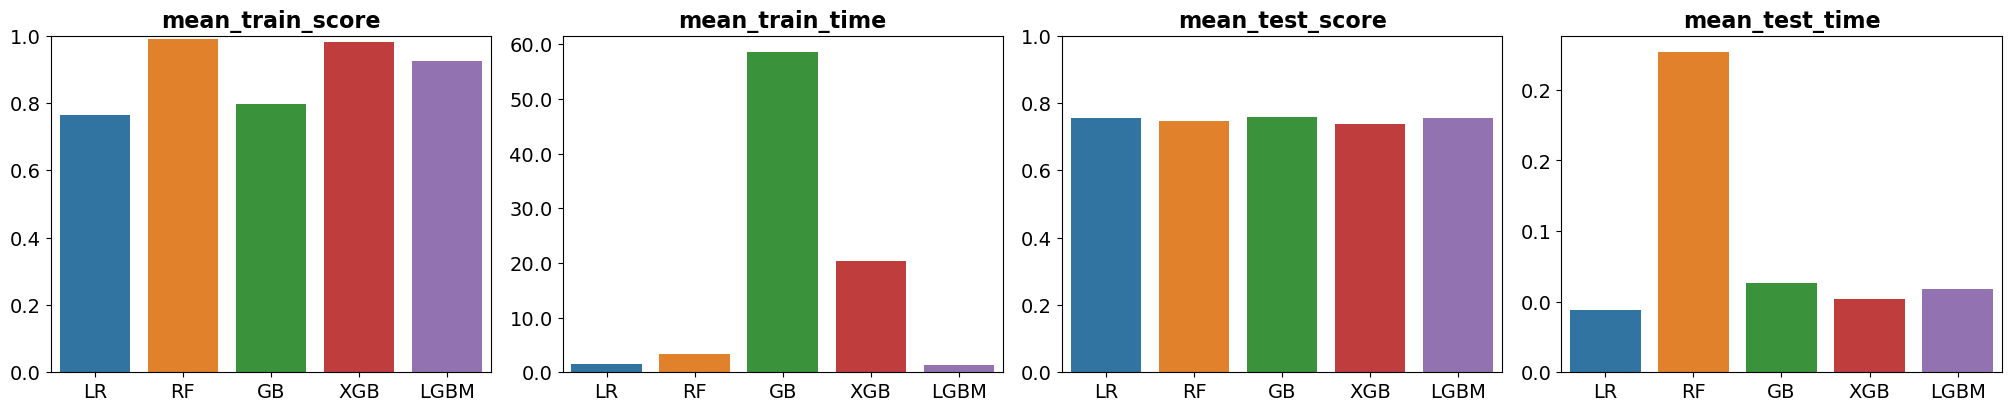

In [45]:
sns.reset_orig
plt.style.use('default')

fig, axes = plt.subplots(1, 4, figsize=(20, 4), constrained_layout=True)
g1 = sns.barplot(x='Model', y='mean_train_score', data=results_dict, ax=axes[0])
g1.set_title('mean_train_score', fontsize=16, fontweight='bold')
g1.set_ylim(0,1)
g2 = sns.barplot(x='Model', y='mean_train_time', data=results_dict, ax=axes[1])
g2.set_title('mean_train_time', fontsize=16, fontweight='bold')
g3 = sns.barplot(x='Model', y='mean_test_score', data=results_dict, ax=axes[2])
g3.set_ylim(0,1)
g3.set_title('mean_test_score', fontsize=16, fontweight='bold')
g4 = sns.barplot(x='Model', y='mean_test_time', data=results_dict, ax=axes[3])
g4.set_title('mean_test_time', fontsize=16, fontweight='bold')

for g in [g1, g2, g3, g4]:
    g.set_xticklabels(g.get_xticklabels(), fontsize=14)
    g.set_yticklabels([round(e,1) for e in g.get_yticks()], size = 14)

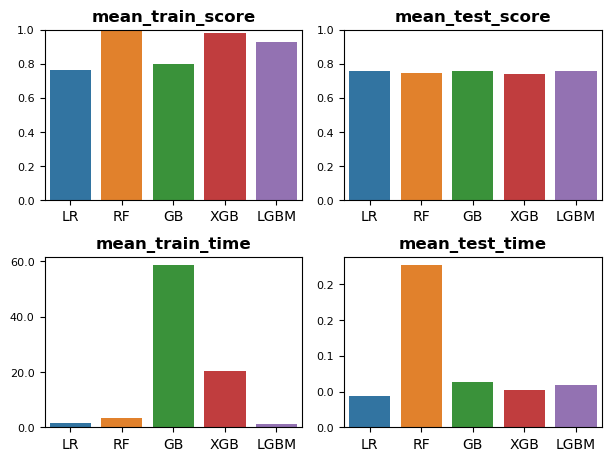

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(6, 4.5), constrained_layout=True)
g1 = sns.barplot(x='Model', y='mean_train_score', data=results_dict, ax=axes[0][0])
g1.set_title('mean_train_score', fontsize=12, fontweight='bold')
g1.set_ylim(0,1)
g2 = sns.barplot(x='Model', y='mean_train_time', data=results_dict, ax=axes[1][0])
g2.set_title('mean_train_time', fontsize=12, fontweight='bold')
g3 = sns.barplot(x='Model', y='mean_test_score', data=results_dict, ax=axes[0][1])
g3.set_ylim(0,1)
g3.set_title('mean_test_score', fontsize=12, fontweight='bold')
g4 = sns.barplot(x='Model', y='mean_test_time', data=results_dict, ax=axes[1][1])
g4.set_title('mean_test_time', fontsize=12, fontweight='bold')

for g in [g1, g2, g3, g4]:
    g.set_xticklabels(g.get_xticklabels(), fontsize=10)
    g.set_yticklabels([round(e,1) for e in g.get_yticks()], size = 8)

Text(0.5, 1.0, 'LGBM')

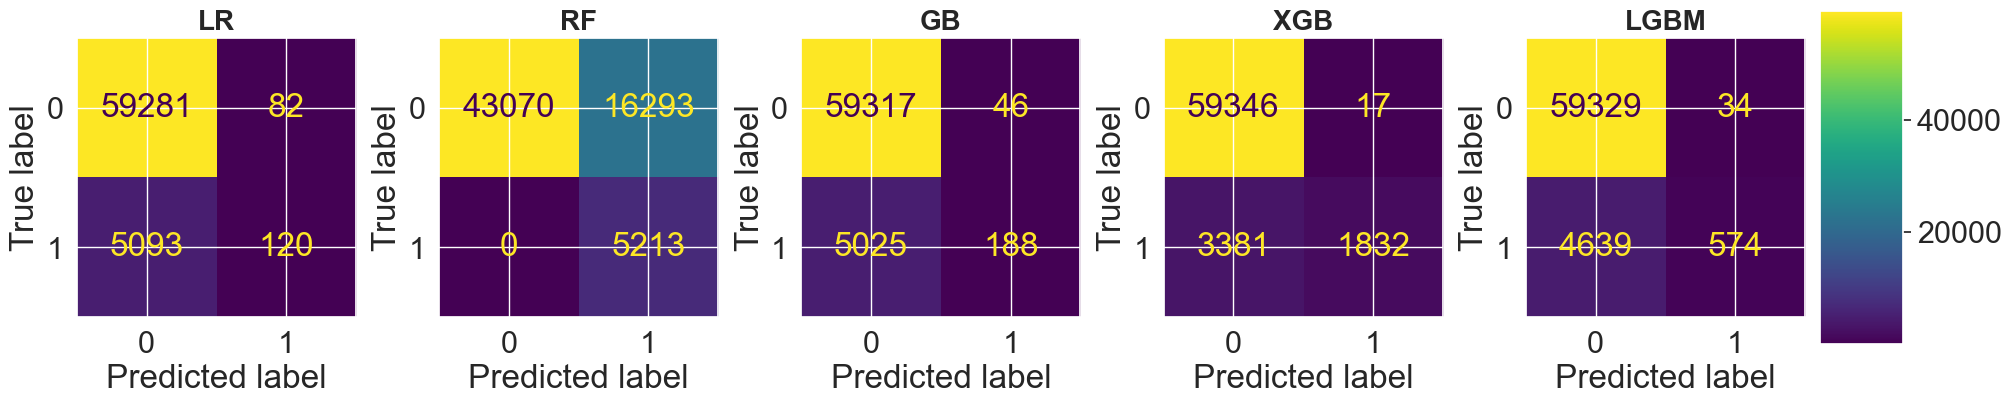

In [47]:
sns.set(font_scale=2.0)
fig, axes = plt.subplots(1, 5, figsize=(20, 4), constrained_layout=True)
g1 = ConfusionMatrixDisplay.from_estimator(grid_logireg.best_estimator_, X_sub_train, y_sub_train, colorbar=False, ax=axes[0])
g1.ax_.set_title('LR', fontsize=20, fontweight='bold')
g2 = ConfusionMatrixDisplay.from_estimator(grid_RFC.best_estimator_, X_sub_train, y_sub_train, colorbar=False, ax=axes[1])
g2.ax_.set_title('RF', fontsize=20, fontweight='bold')
g3 = ConfusionMatrixDisplay.from_estimator(grid_GBC.best_estimator_, X_sub_train, y_sub_train, colorbar=False, ax=axes[2])
g3.ax_.set_title('GB', fontsize=20, fontweight='bold')
g4 = ConfusionMatrixDisplay.from_estimator(grid_XGBC.best_estimator_, X_sub_train, y_sub_train, colorbar=False, ax=axes[3])
g4.ax_.set_title('XGB', fontsize=20, fontweight='bold')
g5 = ConfusionMatrixDisplay.from_estimator(grid_LGBM.best_estimator_, X_sub_train, y_sub_train, ax=axes[4])
g5.ax_.set_title('LGBM', fontsize=20, fontweight='bold')

Text(0.5, 1.0, 'LGBM')

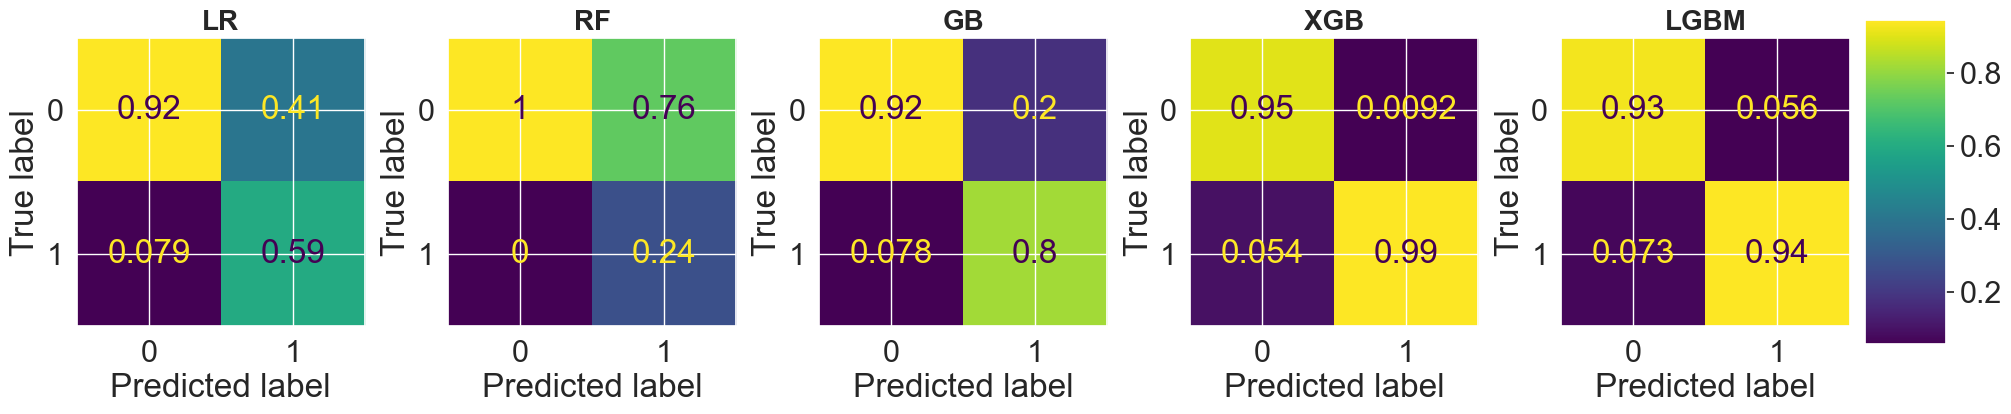

In [48]:
sns.set(font_scale=2.0)
fig, axes = plt.subplots(1, 5, figsize=(20, 4), constrained_layout=True)
g1 = ConfusionMatrixDisplay.from_estimator(grid_logireg.best_estimator_, X_sub_train, y_sub_train, normalize='pred', colorbar=False, ax=axes[0])
g1.ax_.set_title('LR', fontsize=20, fontweight='bold')
g2 = ConfusionMatrixDisplay.from_estimator(grid_RFC.best_estimator_, X_sub_train, y_sub_train, normalize='pred', colorbar=False, ax=axes[1])
g2.ax_.set_title('RF', fontsize=20, fontweight='bold')
g3 = ConfusionMatrixDisplay.from_estimator(grid_GBC.best_estimator_, X_sub_train, y_sub_train, normalize='pred', colorbar=False, ax=axes[2])
g3.ax_.set_title('GB', fontsize=20, fontweight='bold')
g4 = ConfusionMatrixDisplay.from_estimator(grid_XGBC.best_estimator_, X_sub_train, y_sub_train, normalize='pred', colorbar=False, ax=axes[3])
g4.ax_.set_title('XGB', fontsize=20, fontweight='bold')
g5 = ConfusionMatrixDisplay.from_estimator(grid_LGBM.best_estimator_, X_sub_train, y_sub_train, normalize='pred', ax=axes[4])
g5.ax_.set_title('LGBM', fontsize=20, fontweight='bold')

Text(0.5, 1.0, 'LGBM')

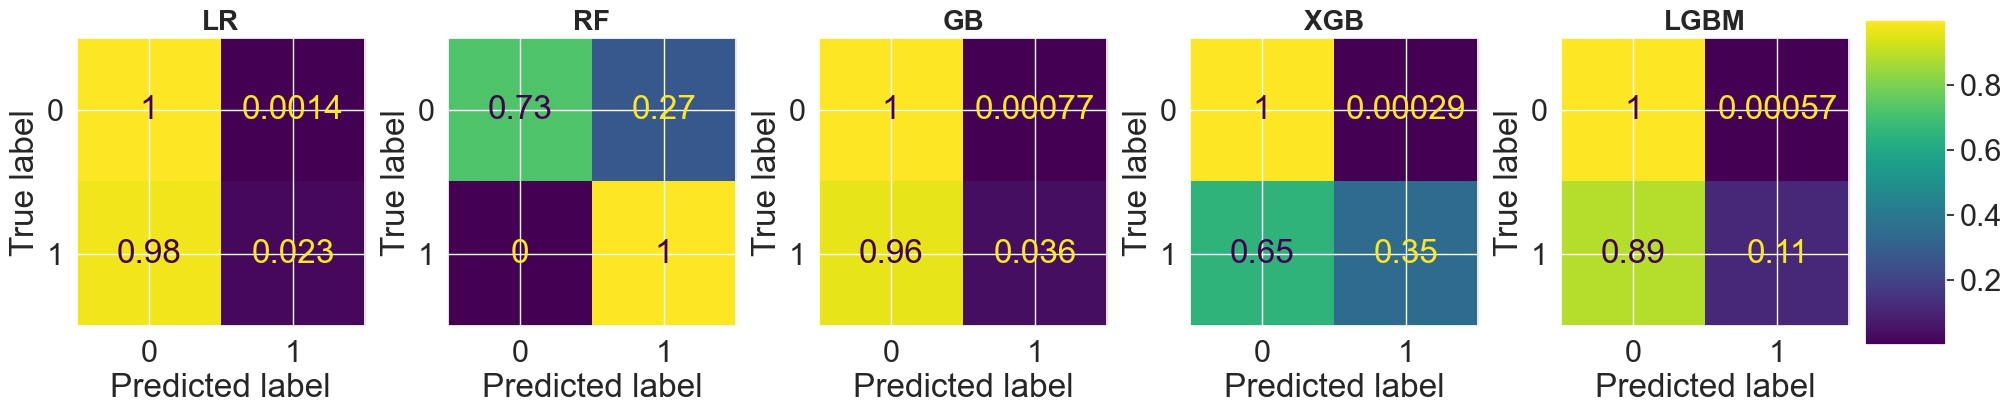

In [49]:
sns.set(font_scale=2.0)
fig, axes = plt.subplots(1, 5, figsize=(20, 4), constrained_layout=True)
g1 = ConfusionMatrixDisplay.from_estimator(grid_logireg.best_estimator_, X_sub_train, y_sub_train, normalize='true', colorbar=False, ax=axes[0])
g1.ax_.set_title('LR', fontsize=20, fontweight='bold')
g2 = ConfusionMatrixDisplay.from_estimator(grid_RFC.best_estimator_, X_sub_train, y_sub_train, normalize='true', colorbar=False, ax=axes[1])
g2.ax_.set_title('RF', fontsize=20, fontweight='bold')
g3 = ConfusionMatrixDisplay.from_estimator(grid_GBC.best_estimator_, X_sub_train, y_sub_train, normalize='true', colorbar=False, ax=axes[2])
g3.ax_.set_title('GB', fontsize=20, fontweight='bold')
g4 = ConfusionMatrixDisplay.from_estimator(grid_XGBC.best_estimator_, X_sub_train, y_sub_train, normalize='true', colorbar=False, ax=axes[3])
g4.ax_.set_title('XGB', fontsize=20, fontweight='bold')
g5 = ConfusionMatrixDisplay.from_estimator(grid_LGBM.best_estimator_, X_sub_train, y_sub_train, normalize='true', ax=axes[4])
g5.ax_.set_title('LGBM', fontsize=20, fontweight='bold')

Text(0.5, 1.0, 'LGBM')

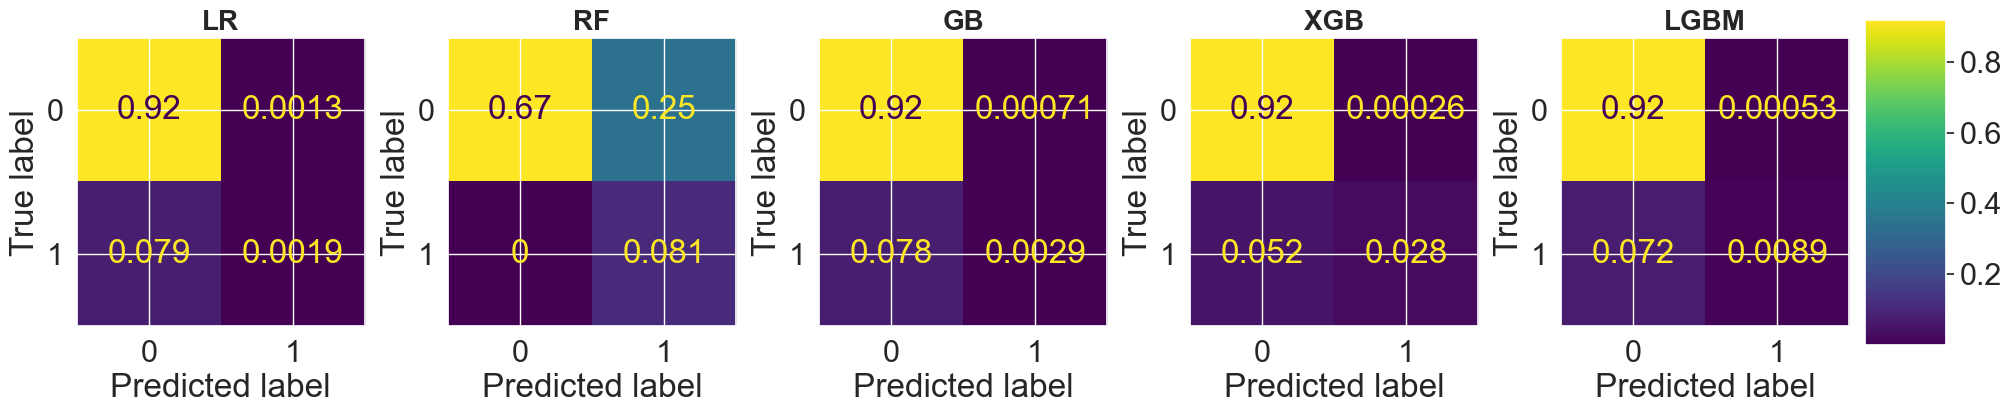

In [50]:
sns.set(font_scale=2.0)
fig, axes = plt.subplots(1, 5, figsize=(20, 4), constrained_layout=True)
g1 = ConfusionMatrixDisplay.from_estimator(grid_logireg.best_estimator_, X_sub_train, y_sub_train, normalize='all', colorbar=False, ax=axes[0])
g1.ax_.set_title('LR', fontsize=20, fontweight='bold')
g2 = ConfusionMatrixDisplay.from_estimator(grid_RFC.best_estimator_, X_sub_train, y_sub_train, normalize='all', colorbar=False, ax=axes[1])
g2.ax_.set_title('RF', fontsize=20, fontweight='bold')
g3 = ConfusionMatrixDisplay.from_estimator(grid_GBC.best_estimator_, X_sub_train, y_sub_train, normalize='all', colorbar=False, ax=axes[2])
g3.ax_.set_title('GB', fontsize=20, fontweight='bold')
g4 = ConfusionMatrixDisplay.from_estimator(grid_XGBC.best_estimator_, X_sub_train, y_sub_train, normalize='all', colorbar=False, ax=axes[3])
g4.ax_.set_title('XGB', fontsize=20, fontweight='bold')
g5 = ConfusionMatrixDisplay.from_estimator(grid_LGBM.best_estimator_, X_sub_train, y_sub_train, normalize='all', ax=axes[4])
g5.ax_.set_title('LGBM', fontsize=20, fontweight='bold')

Text(0.5, 1.0, 'LGBM')

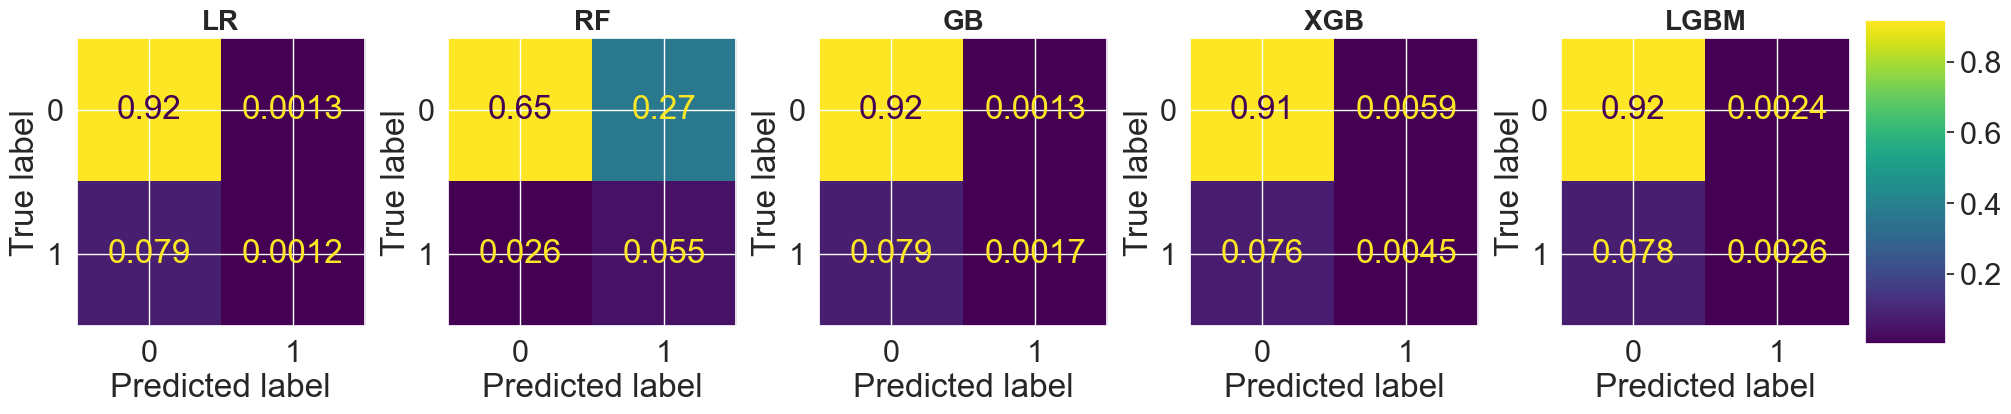

In [51]:
sns.set(font_scale=2.0)
fig, axes = plt.subplots(1, 5, figsize=(20, 4), constrained_layout=True)
g1 = ConfusionMatrixDisplay.from_estimator(grid_logireg.best_estimator_, X_sub_test, y_sub_test, normalize='all', colorbar=False, ax=axes[0])
g1.ax_.set_title('LR', fontsize=20, fontweight='bold')
g2 = ConfusionMatrixDisplay.from_estimator(grid_RFC.best_estimator_, X_sub_test, y_sub_test, normalize='all', colorbar=False, ax=axes[1])
g2.ax_.set_title('RF', fontsize=20, fontweight='bold')
g3 = ConfusionMatrixDisplay.from_estimator(grid_GBC.best_estimator_, X_sub_test, y_sub_test, normalize='all', colorbar=False, ax=axes[2])
g3.ax_.set_title('GB', fontsize=20, fontweight='bold')
g4 = ConfusionMatrixDisplay.from_estimator(grid_XGBC.best_estimator_, X_sub_test, y_sub_test, normalize='all', colorbar=False, ax=axes[3])
g4.ax_.set_title('XGB', fontsize=20, fontweight='bold')
g5 = ConfusionMatrixDisplay.from_estimator(grid_LGBM.best_estimator_, X_sub_test, y_sub_test, normalize='all', ax=axes[4])
g5.ax_.set_title('LGBM', fontsize=20, fontweight='bold')

## v2 - imbalance, auc

In [52]:
model_list2 = []
mean_train_score_list2 = []
mean_train_time_list2 = []
mean_test_score_list2 = []
mean_test_time_list2 = []

### Binary classification baseline: logistic regression

In [53]:
param_grid_logireg2 = {'imputer': [SimpleImputer(missing_values=np.nan, strategy='median')],
                      'scaler': [non_bin_scaler],
                      'sampler': [SMOTE(), RandomUnderSampler()],
                      'classifier': [LogisticRegression()],
                      'classifier__class_weight': [True]}

grid_logireg2 = GridSearchCV(pipe,
                            param_grid=param_grid_logireg2,
                            return_train_score=True,
                            scoring='roc_auc',
                            cv=5, # For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. 
                            verbose=3)

grid_logireg2.fit(X_sub_train, y_sub_train)

best_model_index = grid_logireg2.best_index_

print('###### For logistic regression:')
print('-' * 20)
print('Best params are:\n', grid_logireg2.best_params_)
print('-' * 20)
print('Corresponding mean scores and times are:')
print('Mean train score: {}'.format(grid_logireg2.cv_results_['mean_train_score'][best_model_index]))
print('Mean test score: {}'.format(grid_logireg2.cv_results_['mean_test_score'][best_model_index]))
print('Mean train time: {}'.format(grid_logireg2.cv_results_['mean_fit_time'][best_model_index]))
print('Mean test time: {}'.format(grid_logireg2.cv_results_['mean_score_time'][best_model_index]))

model_list2.append('Baseline-LogisticRegression')
mean_train_score_list2.append(grid_logireg2.cv_results_['mean_train_score'][best_model_index])
mean_train_time_list2.append(grid_logireg2.cv_results_['mean_fit_time'][best_model_index])
mean_test_score_list2.append(grid_logireg2.cv_results_['mean_test_score'][best_model_index])
mean_test_time_list2.append(grid_logireg2.cv_results_['mean_score_time'][best_model_index])

Fitting 5 folds for each of 2 candidates, totalling 10 fits


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END classifier=LogisticRegression(), classifier__class_weight=True, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.753, test=0.759) total time=   2.5s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END classifier=LogisticRegression(), classifier__class_weight=True, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.755, test=0.754) total time=   2.3s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END classifier=LogisticRegression(), classifier__class_weight=True, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.757, test=0.740) total time=   2.3s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END classifier=LogisticRegression(), classifier__class_weight=True, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.759, test=0.737) total time=   2.3s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END classifier=LogisticRegression(), classifier__class_weight=True, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.756, test=0.744) total time=   2.3s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END classifier=LogisticRegression(), classifier__class_weight=True, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.757, test=0.765) total time=   0.9s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END classifier=LogisticRegression(), classifier__class_weight=True, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.759, test=0.753) total time=   0.8s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END classifier=LogisticRegression(), classifier__class_weight=True, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.763, test=0.749) total time=   0.8s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END classifier=LogisticRegression(), classifier__class_weight=True, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.763, test=0.744) total time=   0.8s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END classifier=LogisticRegression(), classifier__class_weight=True, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.762, test=0.751) total time=   0.8s
###### For logistic regression:
--------------------
Best params are:
 {'classifier': LogisticRegression(class_weight=True), 'classifier__class_weight': True, 'imputer': SimpleImputer(strategy='median'), 'sampler': RandomUnderSampler(), 'scaler': ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
              

C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Test of different classifiers
--> with default hyperparameters

#### Random Forest Classifier

In [54]:
param_grid_RFC2 = {'imputer': [SimpleImputer(missing_values=np.nan, strategy='median')],
                  'scaler': [non_bin_scaler],
                  'sampler': [SMOTE(), RandomUnderSampler()],
                  'classifier': [RandomForestClassifier()],
                  'classifier__class_weight': ['balanced', 'balanced_subsample']}

grid_RFC2 = GridSearchCV(pipe,
                        param_grid=param_grid_RFC2,
                        return_train_score=True,
                        scoring='roc_auc',
                        cv=5, # For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. 
                        verbose=3)

grid_RFC2.fit(X_sub_train, y_sub_train)

best_model_index = grid_RFC2.best_index_

print('###### For Random Forest Classifier:')
print('-' * 20)
print('Best params are:\n', grid_RFC2.best_params_)
print('-' * 20)
print('Corresponding mean scores and times are:')
print('Mean train score: {}'.format(grid_RFC2.cv_results_['mean_train_score'][best_model_index]))
print('Mean test score: {}'.format(grid_RFC2.cv_results_['mean_test_score'][best_model_index]))
print('Mean train time: {}'.format(grid_RFC2.cv_results_['mean_fit_time'][best_model_index]))
print('Mean test time: {}'.format(grid_RFC2.cv_results_['mean_score_time'][best_model_index]))

model_list2.append('Random Forest Classifier')
mean_train_score_list2.append(grid_RFC2.cv_results_['mean_train_score'][best_model_index])
mean_train_time_list2.append(grid_RFC2.cv_results_['mean_fit_time'][best_model_index])
mean_test_score_list2.append(grid_RFC2.cv_results_['mean_test_score'][best_model_index])
mean_test_time_list2.append(grid_RFC2.cv_results_['mean_score_time'][best_model_index])

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=1.000, test=0.733) total time=  42.6s
[CV 2/5] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 4

[CV 1/5] END classifier=RandomForestClassifier(), classifier__class_weight=balanced_subsample, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.992, test=0.752) total time=   3.5s
[CV 2/5] END classifier=RandomForestClassifier(), classifier__class_weight=balanced_subsample, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46,

#### Gradient Boosting Classifier

In [55]:
param_grid_GBC2 = {'imputer': [SimpleImputer(missing_values=np.nan, strategy='median')],
                  'scaler': [non_bin_scaler],
                  'sampler': [SMOTE(), RandomUnderSampler()],
                  'classifier': [GradientBoostingClassifier()],
                  'classifier__random_state': [0]}

grid_GBC2 = GridSearchCV(pipe,
                        param_grid=param_grid_GBC2,
                        return_train_score=True,
                        scoring='roc_auc',
                        cv=5, # For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. 
                        verbose=3)

grid_GBC2.fit(X_sub_train, y_sub_train)

best_model_index = grid_GBC2.best_index_

print('###### For Gradient Boosting Classifier:')
print('-' * 20)
print('Best params are:\n', grid_GBC2.best_params_)
print('-' * 20)
print('Corresponding mean scores and times are:')
print('Mean train score: {}'.format(grid_GBC2.cv_results_['mean_train_score'][best_model_index]))
print('Mean test score: {}'.format(grid_GBC2.cv_results_['mean_test_score'][best_model_index]))
print('Mean train time: {}'.format(grid_GBC2.cv_results_['mean_fit_time'][best_model_index]))
print('Mean test time: {}'.format(grid_GBC2.cv_results_['mean_score_time'][best_model_index]))

model_list2.append('Gradient Boosting Classifier')
mean_train_score_list2.append(grid_GBC2.cv_results_['mean_train_score'][best_model_index])
mean_train_time_list2.append(grid_GBC2.cv_results_['mean_fit_time'][best_model_index])
mean_test_score_list2.append(grid_GBC2.cv_results_['mean_test_score'][best_model_index])
mean_test_time_list2.append(grid_GBC2.cv_results_['mean_score_time'][best_model_index])

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END classifier=GradientBoostingClassifier(), classifier__random_state=0, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.740, test=0.728) total time= 2.9min
[CV 2/5] END classifier=GradientBoostingClassifier(), classifier__random_state=0, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44,

#### XGBoost classifier

In [56]:
param_grid_XGBC2 = {'imputer': [SimpleImputer(missing_values=np.nan, strategy='median'), 'passthrough'],
                   'scaler': [non_bin_scaler],
                   'sampler': [SMOTE(), RandomUnderSampler()],
                   'classifier': [XGBClassifier()],
                   'classifier__objective': ['binary:logistic'],
                   'classifier__eval_metric': ['auc'],
                   'classifier__missing': [np.nan],
                   'classifier__scale_pos_weight': [None, 1/0.0807]}

grid_XGBC2 = GridSearchCV(pipe,
                        param_grid=param_grid_XGBC2,
                        return_train_score=True,
                        scoring='roc_auc',
                        cv=5, # For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. 
                        verbose=3)

grid_XGBC2.fit(X_sub_train, y_sub_train)

best_model_index = grid_XGBC2.best_index_

print('###### For XGBoost Classifier:')
print('-' * 20)
print('Best params are:\n', grid_XGBC2.best_params_)
print('-' * 20)
print('Corresponding mean scores and times are:')
print('Mean train score: {}'.format(grid_XGBC2.cv_results_['mean_train_score'][best_model_index]))
print('Mean test score: {}'.format(grid_XGBC2.cv_results_['mean_test_score'][best_model_index]))
print('Mean train time: {}'.format(grid_XGBC2.cv_results_['mean_fit_time'][best_model_index]))
print('Mean test time: {}'.format(grid_XGBC2.cv_results_['mean_score_time'][best_model_index]))

model_list2.append('XGBoost Classifier')
mean_train_score_list2.append(grid_XGBC2.cv_results_['mean_train_score'][best_model_index])
mean_train_time_list2.append(grid_XGBC2.cv_results_['mean_fit_time'][best_model_index])
mean_test_score_list2.append(grid_XGBC2.cv_results_['mean_test_score'][best_model_index])
mean_test_time_list2.append(grid_XGBC2.cv_results_['mean_score_time'][best_model_index])

Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', S

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', S

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', S

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', S

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', S

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('stand

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('stand

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('stand

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('stand

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('stand

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=passthrough, sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardS

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=passthrough, sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardS

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=passthrough, sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardS

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=passthrough, sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardS

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=passthrough, sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardS

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('stan

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('stan

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('stan

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('stan

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('stan

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transfo

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transfo

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transfo

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transfo

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transfo

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=passthrough, sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscal

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=passthrough, sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscal

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=passthrough, sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscal

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=passthrough, sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscal

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=auc, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=passthrough, sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscal

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\imblearn\pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\user\anaconda3\lib\site-packages\imblearn\pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\user\anac

###### For XGBoost Classifier:
--------------------
Best params are:
 {'classifier': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, eval_metric='auc', gamma=None,
              gpu_id=None, importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), 'classifier__eval_metric': 'auc', 'classifier__missing': nan, 'classifier__objective': 'binary:logistic', 'classifier__scale_pos_weight': None, 'imputer': SimpleImputer(strategy='median'), 'sampler': RandomUnd

#### LightGBM classifier

In [57]:
param_grid_LGBM2 = {'imputer': [SimpleImputer(missing_values=np.nan, strategy='median'), 'passthrough'],
                   'scaler': [non_bin_scaler],
                   'sampler': [SMOTE(), RandomUnderSampler()],
                   'classifier': [LGBMClassifier()],
                   'classifier__objective': ['binary'],
                   'classifier__is_unbalance': [True],
                   'classifier__metric': ['auc']
                   }

grid_LGBM2 = GridSearchCV(pipe,
                        param_grid=param_grid_LGBM2,
                        return_train_score=True,
                        scoring='roc_auc',
                        cv=5, # For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. 
                        verbose=3)

grid_LGBM2.fit(X_sub_train, y_sub_train)

best_model_index = grid_LGBM2.best_index_

print('###### For LGBM Classifier:')
print('-' * 20)
print('Best params are:\n', grid_LGBM2.best_params_)
print('-' * 20)
print('Corresponding mean scores and times are:')
print('Mean train score: {}'.format(grid_LGBM2.cv_results_['mean_train_score'][best_model_index]))
print('Mean test score: {}'.format(grid_LGBM2.cv_results_['mean_test_score'][best_model_index]))
print('Mean train time: {}'.format(grid_LGBM2.cv_results_['mean_fit_time'][best_model_index]))
print('Mean test time: {}'.format(grid_LGBM2.cv_results_['mean_score_time'][best_model_index]))

model_list2.append('LGBM Classifier')
mean_train_score_list2.append(grid_LGBM2.cv_results_['mean_train_score'][best_model_index])
mean_train_time_list2.append(grid_LGBM2.cv_results_['mean_fit_time'][best_model_index])
mean_test_score_list2.append(grid_LGBM2.cv_results_['mean_test_score'][best_model_index])
mean_test_time_list2.append(grid_LGBM2.cv_results_['mean_score_time'][best_model_index])

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END classifier=LGBMClassifier(), classifier__is_unbalance=True, classifier__metric=auc, classifier__objective=binary, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.853, test=0.756) total time=   3.7s
[CV 2/5] END classifier=LGBMClassifier(), classifier__is_unbalance=True, classifier__metric=auc, classifier__objective=binary, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10,

[CV 1/5] END classifier=LGBMClassifier(), classifier__is_unbalance=True, classifier__metric=auc, classifier__objective=binary, imputer=passthrough, sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.886, test=0.765) total time=   0.8s
[CV 2/5] END classifier=LGBMClassifier(), classifier__is_unbalance=True, classifier__metric=auc, classifier__objective=binary, imputer=passthrough, sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 4

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\imblearn\pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\user\anaconda3\lib\site-packages\imblearn\pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\user\anacon

###### For LGBM Classifier:
--------------------
Best params are:
 {'classifier': LGBMClassifier(is_unbalance=True, metric='auc', objective='binary'), 'classifier__is_unbalance': True, 'classifier__metric': 'auc', 'classifier__objective': 'binary', 'imputer': 'passthrough', 'sampler': RandomUnderSampler(), 'scaler': ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])])}
--------------------
Corresponding mean scores and times are:
Mean train score: 0.8863450795485572
Mean test score: 0.753954640272636
Mean train time: 0.824415636062622
Mean test time: 0.06847052574157715


### Comparison

In [58]:
model_list2

['Baseline-LogisticRegression',
 'Random Forest Classifier',
 'Gradient Boosting Classifier',
 'XGBoost Classifier',
 'LGBM Classifier']

In [59]:
model_list2_short = ['LR', 'RF', 'GB', 'XGB', 'LGBM']
results_dict2 = {'Model': model_list2_short,
                'mean_train_score': mean_train_score_list2,
                'mean_train_time': mean_train_time_list2,
                'mean_test_score': mean_test_score_list2,
                'mean_test_time': mean_test_time_list2}

results2 = pd.DataFrame(results_dict2)

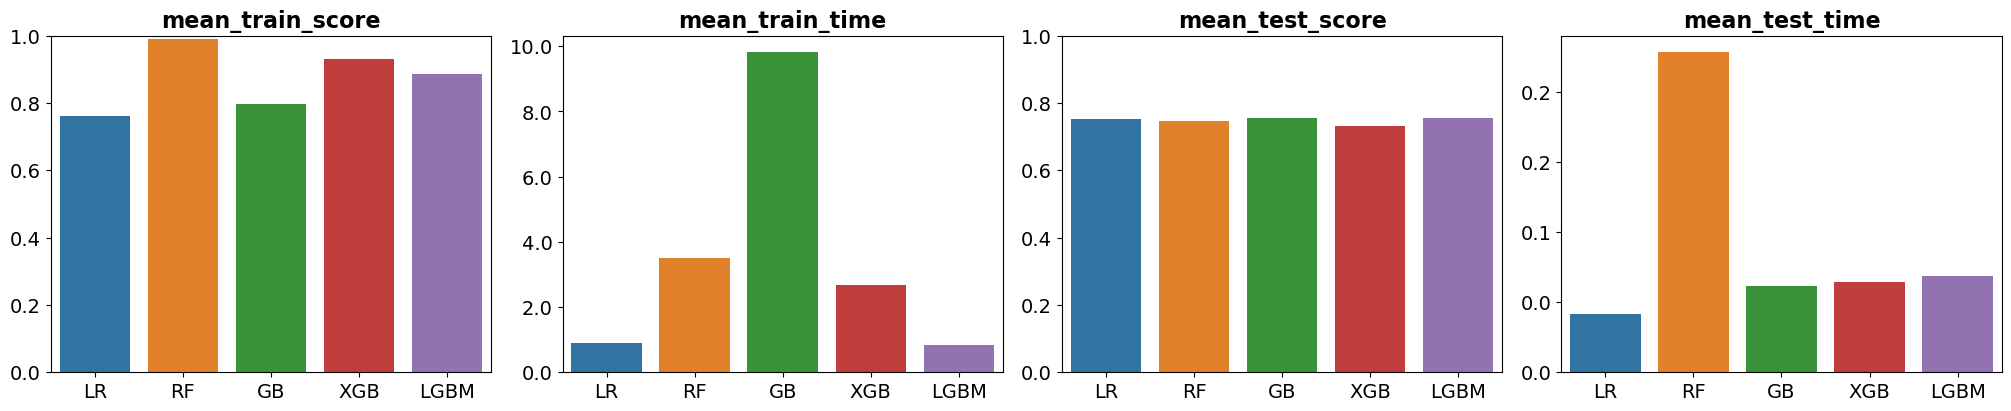

In [60]:
sns.reset_orig
plt.style.use('default')

fig, axes = plt.subplots(1, 4, figsize=(20, 4), constrained_layout=True)
g1 = sns.barplot(x='Model', y='mean_train_score', data=results_dict2, ax=axes[0])
g1.set_title('mean_train_score', fontsize=16, fontweight='bold')
g1.set_ylim(0,1)
#g1.set_xticklabels(g1.get_xticklabels(),
#                   fontsize=14,
#                   rotation=0, 
#                   horizontalalignment='center')
g2 = sns.barplot(x='Model', y='mean_train_time', data=results_dict2, ax=axes[1])
g2.set_title('mean_train_time', fontsize=16, fontweight='bold')
g3 = sns.barplot(x='Model', y='mean_test_score', data=results_dict2, ax=axes[2])
g3.set_ylim(0,1)
g3.set_title('mean_test_score', fontsize=16, fontweight='bold')
g4 = sns.barplot(x='Model', y='mean_test_time', data=results_dict2, ax=axes[3])
g4.set_title('mean_test_time', fontsize=16, fontweight='bold')

for g in [g1, g2, g3, g4]:
    g.set_xticklabels(g.get_xticklabels(), fontsize=14)
    g.set_yticklabels([round(e,1) for e in g.get_yticks()], size = 14)

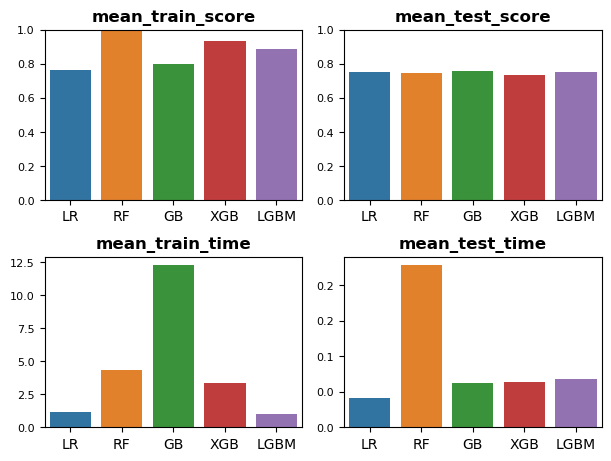

In [61]:
fig, axes = plt.subplots(2, 2, figsize=(6, 4.5), constrained_layout=True)
g1 = sns.barplot(x='Model', y='mean_train_score', data=results_dict2, ax=axes[0][0])
g1.set_title('mean_train_score', fontsize=12, fontweight='bold')
g1.set_ylim(0,1)
g2 = sns.barplot(x='Model', y='mean_train_time', data=results_dict2, ax=axes[1][0])
g2.set_title('mean_train_time', fontsize=12, fontweight='bold')
g3 = sns.barplot(x='Model', y='mean_test_score', data=results_dict2, ax=axes[0][1])
g3.set_ylim(0,1)
g3.set_title('mean_test_score', fontsize=12, fontweight='bold')
g4 = sns.barplot(x='Model', y='mean_test_time', data=results_dict2, ax=axes[1][1])
g4.set_title('mean_test_time', fontsize=12, fontweight='bold')

for g in [g1, g2, g3, g4]:
    g.set_xticklabels(g.get_xticklabels(), fontsize=10)
    g.set_yticklabels([round(e,1) for e in g.get_yticks()], size = 8)

In [63]:
#y_predLR = grid_logireg2.best_estimator_.predict(X_sub_train)
#print(confusion_matrix(y_sub_train, y_predLR))

Text(0.5, 1.0, 'LGBM')

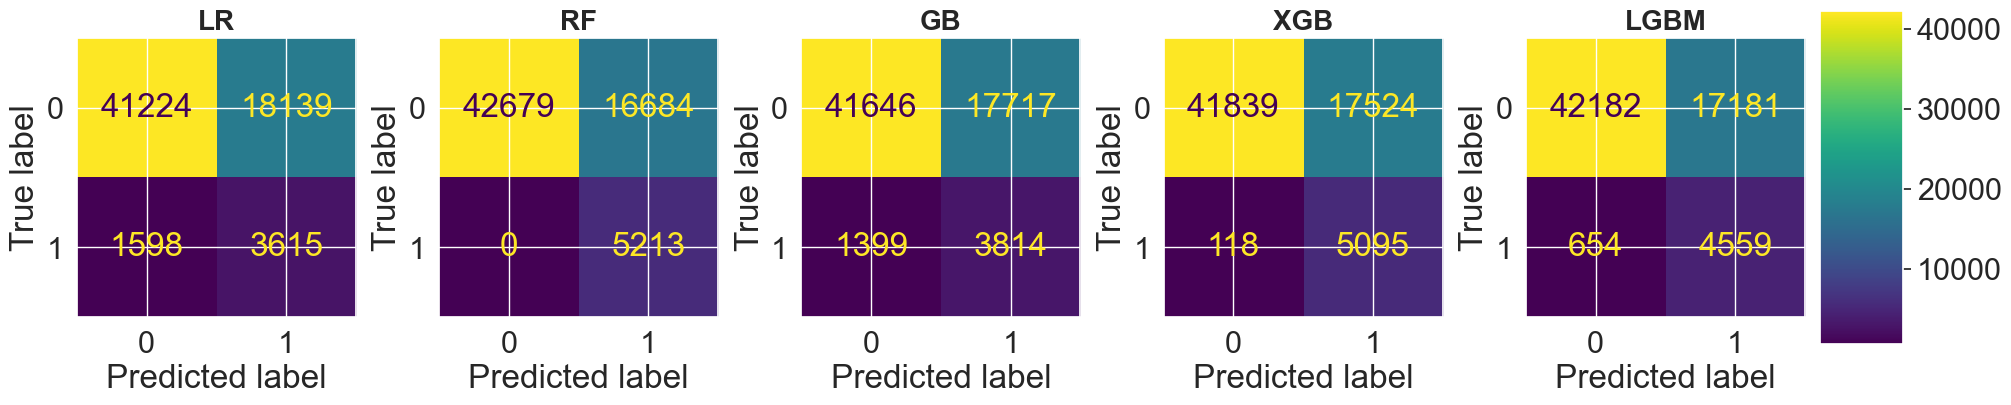

In [64]:
sns.set(font_scale=2.0)
fig, axes = plt.subplots(1, 5, figsize=(20, 4), constrained_layout=True)
g1 = ConfusionMatrixDisplay.from_estimator(grid_logireg2.best_estimator_, X_sub_train, y_sub_train, colorbar=False, ax=axes[0])
g1.ax_.set_title('LR', fontsize=20, fontweight='bold')
g2 = ConfusionMatrixDisplay.from_estimator(grid_RFC2.best_estimator_, X_sub_train, y_sub_train, colorbar=False, ax=axes[1])
g2.ax_.set_title('RF', fontsize=20, fontweight='bold')
g3 = ConfusionMatrixDisplay.from_estimator(grid_GBC2.best_estimator_, X_sub_train, y_sub_train, colorbar=False, ax=axes[2])
g3.ax_.set_title('GB', fontsize=20, fontweight='bold')
g4 = ConfusionMatrixDisplay.from_estimator(grid_XGBC2.best_estimator_, X_sub_train, y_sub_train, colorbar=False, ax=axes[3])
g4.ax_.set_title('XGB', fontsize=20, fontweight='bold')
g5 = ConfusionMatrixDisplay.from_estimator(grid_LGBM2.best_estimator_, X_sub_train, y_sub_train, ax=axes[4])
g5.ax_.set_title('LGBM', fontsize=20, fontweight='bold')

Text(0.5, 1.0, 'LGBM')

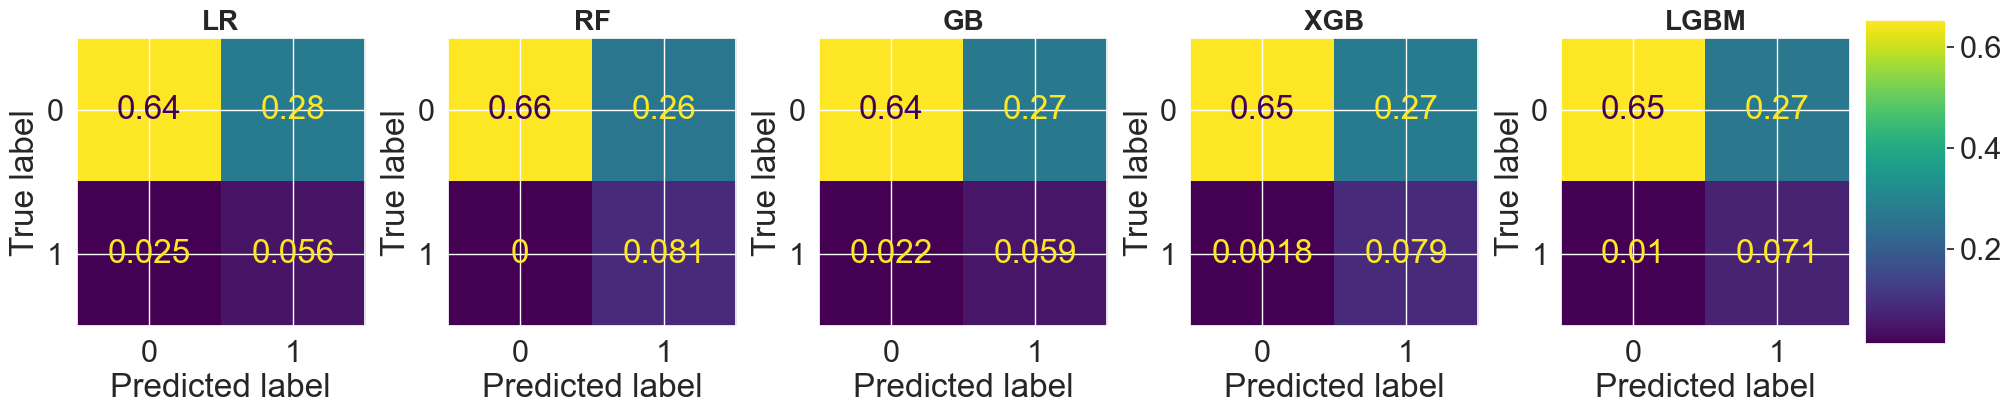

In [65]:
sns.set(font_scale=2.0)
fig, axes = plt.subplots(1, 5, figsize=(20, 4), constrained_layout=True)
g1 = ConfusionMatrixDisplay.from_estimator(grid_logireg2.best_estimator_, X_sub_train, y_sub_train, normalize='all', colorbar=False, ax=axes[0])
g1.ax_.set_title('LR', fontsize=20, fontweight='bold')
g2 = ConfusionMatrixDisplay.from_estimator(grid_RFC2.best_estimator_, X_sub_train, y_sub_train, normalize='all', colorbar=False, ax=axes[1])
g2.ax_.set_title('RF', fontsize=20, fontweight='bold')
g3 = ConfusionMatrixDisplay.from_estimator(grid_GBC2.best_estimator_, X_sub_train, y_sub_train, normalize='all', colorbar=False, ax=axes[2])
g3.ax_.set_title('GB', fontsize=20, fontweight='bold')
g4 = ConfusionMatrixDisplay.from_estimator(grid_XGBC2.best_estimator_, X_sub_train, y_sub_train, normalize='all', colorbar=False, ax=axes[3])
g4.ax_.set_title('XGB', fontsize=20, fontweight='bold')
g5 = ConfusionMatrixDisplay.from_estimator(grid_LGBM2.best_estimator_, X_sub_train, y_sub_train, normalize='all', ax=axes[4])
g5.ax_.set_title('LGBM', fontsize=20, fontweight='bold')

Text(0.5, 1.0, 'LGBM')

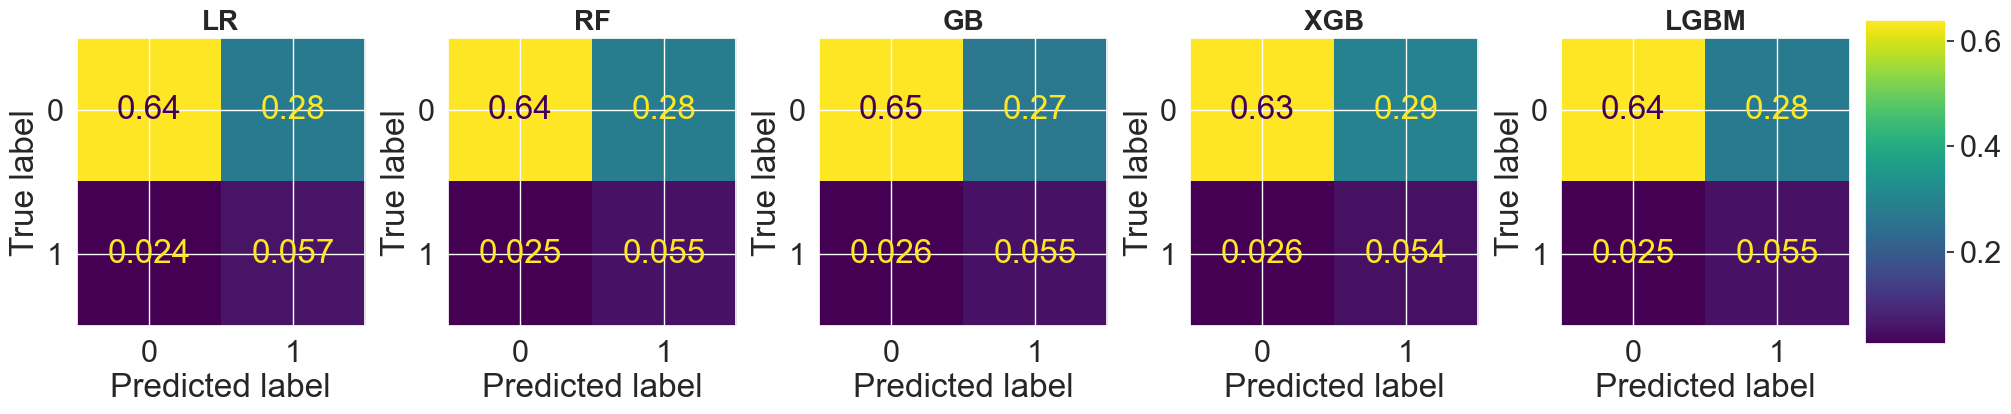

In [66]:
sns.set(font_scale=2.0)
fig, axes = plt.subplots(1, 5, figsize=(20, 4), constrained_layout=True)
g1 = ConfusionMatrixDisplay.from_estimator(grid_logireg2.best_estimator_, X_sub_test, y_sub_test, normalize='all', colorbar=False, ax=axes[0])
g1.ax_.set_title('LR', fontsize=20, fontweight='bold')
g2 = ConfusionMatrixDisplay.from_estimator(grid_RFC2.best_estimator_, X_sub_test, y_sub_test, normalize='all', colorbar=False, ax=axes[1])
g2.ax_.set_title('RF', fontsize=20, fontweight='bold')
g3 = ConfusionMatrixDisplay.from_estimator(grid_GBC2.best_estimator_, X_sub_test, y_sub_test, normalize='all', colorbar=False, ax=axes[2])
g3.ax_.set_title('GB', fontsize=20, fontweight='bold')
g4 = ConfusionMatrixDisplay.from_estimator(grid_XGBC2.best_estimator_, X_sub_test, y_sub_test, normalize='all', colorbar=False, ax=axes[3])
g4.ax_.set_title('XGB', fontsize=20, fontweight='bold')
g5 = ConfusionMatrixDisplay.from_estimator(grid_LGBM2.best_estimator_, X_sub_test, y_sub_test, normalize='all', ax=axes[4])
g5.ax_.set_title('LGBM', fontsize=20, fontweight='bold')

## v3 - imbalance, f1_score

In [67]:
model_list3 = []
mean_train_score_list3 = []
mean_train_time_list3 = []
mean_test_score_list3 = []
mean_test_time_list3 = []

### Binary classification baseline: logistic regression

In [68]:
param_grid_logireg3 = {'imputer': [SimpleImputer(missing_values=np.nan, strategy='median')],
                      'scaler': [non_bin_scaler],
                      'sampler': [SMOTE(), RandomUnderSampler()],
                      'classifier': [LogisticRegression()],
                      'classifier__class_weight': [True]}

grid_logireg3 = GridSearchCV(pipe,
                            param_grid=param_grid_logireg3,
                            return_train_score=True,
                            scoring='f1',
                            cv=5, # For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. 
                            verbose=3)

grid_logireg3.fit(X_sub_train, y_sub_train)

best_model_index = grid_logireg3.best_index_

print('###### For logistic regression:')
print('-' * 20)
print('Best params are:\n', grid_logireg3.best_params_)
print('-' * 20)
print('Corresponding mean scores and times are:')
print('Mean train score: {}'.format(grid_logireg3.cv_results_['mean_train_score'][best_model_index]))
print('Mean test score: {}'.format(grid_logireg3.cv_results_['mean_test_score'][best_model_index]))
print('Mean train time: {}'.format(grid_logireg3.cv_results_['mean_fit_time'][best_model_index]))
print('Mean test time: {}'.format(grid_logireg3.cv_results_['mean_score_time'][best_model_index]))

model_list3.append('Baseline-LogisticRegression')
mean_train_score_list3.append(grid_logireg3.cv_results_['mean_train_score'][best_model_index])
mean_train_time_list3.append(grid_logireg3.cv_results_['mean_fit_time'][best_model_index])
mean_test_score_list3.append(grid_logireg3.cv_results_['mean_test_score'][best_model_index])
mean_test_time_list3.append(grid_logireg3.cv_results_['mean_score_time'][best_model_index])

Fitting 5 folds for each of 2 candidates, totalling 10 fits


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END classifier=LogisticRegression(), classifier__class_weight=True, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.265, test=0.272) total time=   2.5s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END classifier=LogisticRegression(), classifier__class_weight=True, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.268, test=0.267) total time=   2.3s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END classifier=LogisticRegression(), classifier__class_weight=True, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.268, test=0.260) total time=   2.5s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END classifier=LogisticRegression(), classifier__class_weight=True, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.269, test=0.255) total time=   2.5s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END classifier=LogisticRegression(), classifier__class_weight=True, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.268, test=0.262) total time=   2.7s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END classifier=LogisticRegression(), classifier__class_weight=True, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.262, test=0.269) total time=   1.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END classifier=LogisticRegression(), classifier__class_weight=True, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.266, test=0.263) total time=   0.9s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END classifier=LogisticRegression(), classifier__class_weight=True, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.267, test=0.262) total time=   1.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END classifier=LogisticRegression(), classifier__class_weight=True, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.269, test=0.257) total time=   0.9s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END classifier=LogisticRegression(), classifier__class_weight=True, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.267, test=0.262) total time=   1.0s
###### For logistic regression:
--------------------
Best params are:
 {'classifier': LogisticRegression(class_weight=True), 'classifier__class_weight': True, 'imputer': SimpleImputer(strategy='median'), 'sampler': SMOTE(), 'scaler': ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                           

C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Test of different classifiers
--> with default hyperparameters

#### Random Forest Classifier

In [69]:
param_grid_RFC3 = {'imputer': [SimpleImputer(missing_values=np.nan, strategy='median')],
                  'scaler': [non_bin_scaler],
                  'sampler': [SMOTE(), RandomUnderSampler()],
                  'classifier': [RandomForestClassifier()],
                  'classifier__class_weight': ['balanced', 'balanced_subsample']}

grid_RFC3 = GridSearchCV(pipe,
                        param_grid=param_grid_RFC3,
                        return_train_score=True,
                        scoring='f1',
                        cv=5, # For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. 
                        verbose=3)

grid_RFC3.fit(X_sub_train, y_sub_train)

best_model_index = grid_RFC3.best_index_

print('###### For Random Forest Classifier:')
print('-' * 20)
print('Best params are:\n', grid_RFC3.best_params_)
print('-' * 20)
print('Corresponding mean scores and times are:')
print('Mean train score: {}'.format(grid_RFC3.cv_results_['mean_train_score'][best_model_index]))
print('Mean test score: {}'.format(grid_RFC3.cv_results_['mean_test_score'][best_model_index]))
print('Mean train time: {}'.format(grid_RFC3.cv_results_['mean_fit_time'][best_model_index]))
print('Mean test time: {}'.format(grid_RFC3.cv_results_['mean_score_time'][best_model_index]))

model_list3.append('Random Forest Classifier')
mean_train_score_list3.append(grid_RFC3.cv_results_['mean_train_score'][best_model_index])
mean_train_time_list3.append(grid_RFC3.cv_results_['mean_fit_time'][best_model_index])
mean_test_score_list3.append(grid_RFC3.cv_results_['mean_test_score'][best_model_index])
mean_test_time_list3.append(grid_RFC3.cv_results_['mean_score_time'][best_model_index])

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=1.000, test=0.037) total time=  43.3s
[CV 2/5] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 4

[CV 1/5] END classifier=RandomForestClassifier(), classifier__class_weight=balanced_subsample, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.377, test=0.261) total time=   3.5s
[CV 2/5] END classifier=RandomForestClassifier(), classifier__class_weight=balanced_subsample, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46,

#### Gradient Boosting Classifier

In [70]:
param_grid_GBC3 = {'imputer': [SimpleImputer(missing_values=np.nan, strategy='median')],
                  'scaler': [non_bin_scaler],
                  'sampler': [SMOTE(), RandomUnderSampler()],
                  'classifier': [GradientBoostingClassifier()],
                  'classifier__random_state': [0]}

grid_GBC3 = GridSearchCV(pipe,
                        param_grid=param_grid_GBC3,
                        return_train_score=True,
                        scoring='f1',
                        cv=5, # For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. 
                        verbose=3)

grid_GBC3.fit(X_sub_train, y_sub_train)

best_model_index = grid_GBC3.best_index_

print('###### For Gradient Boosting Classifier:')
print('-' * 20)
print('Best params are:\n', grid_GBC3.best_params_)
print('-' * 20)
print('Corresponding mean scores and times are:')
print('Mean train score: {}'.format(grid_GBC3.cv_results_['mean_train_score'][best_model_index]))
print('Mean test score: {}'.format(grid_GBC3.cv_results_['mean_test_score'][best_model_index]))
print('Mean train time: {}'.format(grid_GBC3.cv_results_['mean_fit_time'][best_model_index]))
print('Mean test time: {}'.format(grid_GBC3.cv_results_['mean_score_time'][best_model_index]))

model_list3.append('Gradient Boosting Classifier')
mean_train_score_list3.append(grid_GBC3.cv_results_['mean_train_score'][best_model_index])
mean_train_time_list3.append(grid_GBC3.cv_results_['mean_fit_time'][best_model_index])
mean_test_score_list3.append(grid_GBC3.cv_results_['mean_test_score'][best_model_index])
mean_test_time_list3.append(grid_GBC3.cv_results_['mean_score_time'][best_model_index])

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END classifier=GradientBoostingClassifier(), classifier__random_state=0, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.070, test=0.067) total time= 2.9min
[CV 2/5] END classifier=GradientBoostingClassifier(), classifier__random_state=0, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44,

#### XGBoost classifier

In [71]:
param_grid_XGBC3 = {'imputer': [SimpleImputer(missing_values=np.nan, strategy='median'), 'passthrough'],
                   'scaler': [non_bin_scaler],
                   'sampler': [SMOTE(), RandomUnderSampler()],
                   'classifier': [XGBClassifier()],
                   'classifier__objective': ['binary:logistic'],
                   'classifier__eval_metric': ['aucpr'],
                   'classifier__missing': [np.nan],
                   'classifier__scale_pos_weight': [None, 1/0.0807]}

grid_XGBC3 = GridSearchCV(pipe,
                        param_grid=param_grid_XGBC3,
                        return_train_score=True,
                        scoring='f1',
                        cv=5, # For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. 
                        verbose=3)

grid_XGBC3.fit(X_sub_train, y_sub_train)

best_model_index = grid_XGBC3.best_index_

print('###### For XGBoost Classifier:')
print('-' * 20)
print('Best params are:\n', grid_XGBC3.best_params_)
print('-' * 20)
print('Corresponding mean scores and times are:')
print('Mean train score: {}'.format(grid_XGBC3.cv_results_['mean_train_score'][best_model_index]))
print('Mean test score: {}'.format(grid_XGBC3.cv_results_['mean_test_score'][best_model_index]))
print('Mean train time: {}'.format(grid_XGBC3.cv_results_['mean_fit_time'][best_model_index]))
print('Mean test time: {}'.format(grid_XGBC3.cv_results_['mean_score_time'][best_model_index]))

model_list3.append('XGBoost Classifier')
mean_train_score_list3.append(grid_XGBC3.cv_results_['mean_train_score'][best_model_index])
mean_train_time_list3.append(grid_XGBC3.cv_results_['mean_fit_time'][best_model_index])
mean_test_score_list3.append(grid_XGBC3.cv_results_['mean_test_score'][best_model_index])
mean_test_time_list3.append(grid_XGBC3.cv_results_['mean_score_time'][best_model_index])

Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler',

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler',

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler',

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler',

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler',

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('sta

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('sta

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('sta

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('sta

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('sta

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=passthrough, sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', Standar

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=passthrough, sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', Standar

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=passthrough, sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', Standar

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=passthrough, sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', Standar

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=passthrough, sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', Standar

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('st

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('st

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('st

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('st

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('st

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  trans

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  trans

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  trans

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  trans

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  trans

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=passthrough, sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardsc

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=passthrough, sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardsc

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=passthrough, sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardsc

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=passthrough, sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardsc

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=passthrough, sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardsc

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\imblearn\pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\user\anaconda3\lib\site-packages\imblearn\pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\user\anac

###### For XGBoost Classifier:
--------------------
Best params are:
 {'classifier': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, eval_metric='aucpr', gamma=None,
              gpu_id=None, importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=12.391573729863694,
              subsample=None, tree_method=None, validate_parameters=None,
              verbosity=None), 'classifier__eval_metric': 'aucpr', 'classifier__missing': nan, 'classifier__objective': 'binary:logistic', 'classifier__scale_pos_weight': 12.391573729863694, 'imputer': SimpleIm

#### LightGBM classifier

In [72]:
param_grid_LGBM3 = {'imputer': [SimpleImputer(missing_values=np.nan, strategy='median'), 'passthrough'],
                   'scaler': [non_bin_scaler],
                   'sampler': [SMOTE(), RandomUnderSampler()],
                   'classifier': [LGBMClassifier()],
                   'classifier__objective': ['binary'],
                   'classifier__is_unbalance': [True],
                   'classifier__metric': ['f1_score']
                   }

grid_LGBM3 = GridSearchCV(pipe,
                        param_grid=param_grid_LGBM3,
                        return_train_score=True,
                        scoring='f1',
                        cv=5, # For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. 
                        verbose=3)

grid_LGBM3.fit(X_sub_train, y_sub_train)

best_model_index = grid_LGBM3.best_index_

print('###### For LGBM Classifier:')
print('-' * 20)
print('Best params are:\n', grid_LGBM3.best_params_)
print('-' * 20)
print('Corresponding mean scores and times are:')
print('Mean train score: {}'.format(grid_LGBM3.cv_results_['mean_train_score'][best_model_index]))
print('Mean test score: {}'.format(grid_LGBM3.cv_results_['mean_test_score'][best_model_index]))
print('Mean train time: {}'.format(grid_LGBM3.cv_results_['mean_fit_time'][best_model_index]))
print('Mean test time: {}'.format(grid_LGBM3.cv_results_['mean_score_time'][best_model_index]))

model_list3.append('LGBM Classifier')
mean_train_score_list3.append(grid_LGBM3.cv_results_['mean_train_score'][best_model_index])
mean_train_time_list3.append(grid_LGBM3.cv_results_['mean_fit_time'][best_model_index])
mean_test_score_list3.append(grid_LGBM3.cv_results_['mean_test_score'][best_model_index])
mean_test_time_list3.append(grid_LGBM3.cv_results_['mean_score_time'][best_model_index])

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END classifier=LGBMClassifier(), classifier__is_unbalance=True, classifier__metric=f1_score, classifier__objective=binary, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.109, test=0.052) total time=   3.4s
[CV 2/5] END classifier=LGBMClassifier(), classifier__is_unbalance=True, classifier__metric=f1_score, classifier__objective=binary, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3,

[CV 5/5] END classifier=LGBMClassifier(), classifier__is_unbalance=True, classifier__metric=f1_score, classifier__objective=binary, imputer=passthrough, sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=nan, test=nan) total time=   0.1s
[CV 1/5] END classifier=LGBMClassifier(), classifier__is_unbalance=True, classifier__metric=f1_score, classifier__objective=binary, imputer=passthrough, sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\imblearn\pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\user\anaconda3\lib\site-packages\imblearn\pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\user\anacon

###### For LGBM Classifier:
--------------------
Best params are:
 {'classifier': LGBMClassifier(is_unbalance=True, metric='f1_score', objective='binary'), 'classifier__is_unbalance': True, 'classifier__metric': 'f1_score', 'classifier__objective': 'binary', 'imputer': 'passthrough', 'sampler': RandomUnderSampler(), 'scaler': ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])])}
--------------------
Corresponding mean scores and times are:
Mean train score: 0.3469570934908167
Mean test score: 0.26435800894047645
Mean train time: 0.6387558460235596
Mean test time: 0.059739303588867185


### Comparison

In [73]:
model_list3

['Baseline-LogisticRegression',
 'Random Forest Classifier',
 'Gradient Boosting Classifier',
 'XGBoost Classifier',
 'LGBM Classifier']

In [74]:
model_list3_short = ['LR', 'RF', 'GB', 'XGB', 'LGBM']
results_dict3 = {'Model': model_list3_short,
                'mean_train_score': mean_train_score_list3,
                'mean_train_time': mean_train_time_list3,
                'mean_test_score': mean_test_score_list3,
                'mean_test_time': mean_test_time_list3}

results3 = pd.DataFrame(results_dict3)

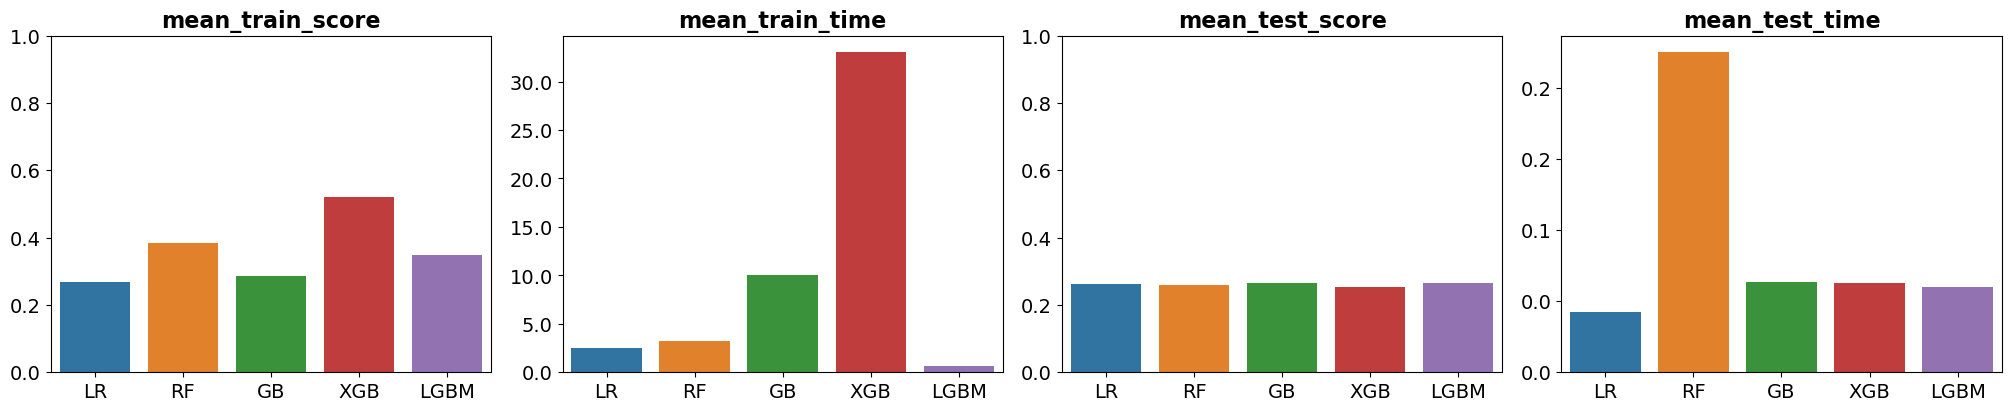

In [75]:
sns.reset_orig
plt.style.use('default')

fig, axes = plt.subplots(1, 4, figsize=(20, 4), constrained_layout=True)
g1 = sns.barplot(x='Model', y='mean_train_score', data=results_dict3, ax=axes[0])
g1.set_title('mean_train_score', fontsize=16, fontweight='bold')
g1.set_ylim(0,1)
g2 = sns.barplot(x='Model', y='mean_train_time', data=results_dict3, ax=axes[1])
g2.set_title('mean_train_time', fontsize=16, fontweight='bold')
g3 = sns.barplot(x='Model', y='mean_test_score', data=results_dict3, ax=axes[2])
g3.set_ylim(0,1)
g3.set_title('mean_test_score', fontsize=16, fontweight='bold')
g4 = sns.barplot(x='Model', y='mean_test_time', data=results_dict3, ax=axes[3])
g4.set_title('mean_test_time', fontsize=16, fontweight='bold')

for g in [g1, g2, g3, g4]:
    g.set_xticklabels(g.get_xticklabels(), fontsize=14)
    g.set_yticklabels([round(e,1) for e in g.get_yticks()], size = 14)

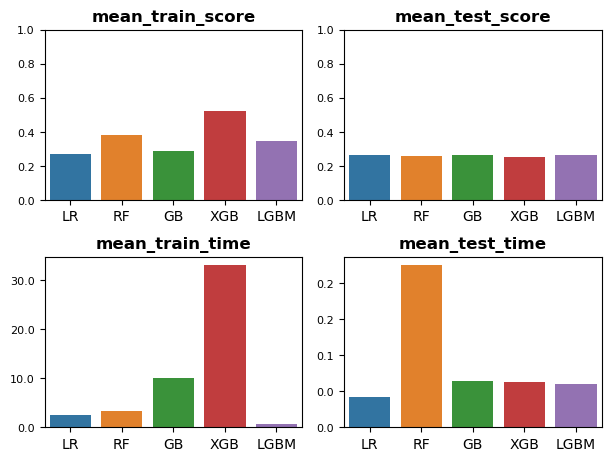

In [76]:
fig, axes = plt.subplots(2, 2, figsize=(6, 4.5), constrained_layout=True)
g1 = sns.barplot(x='Model', y='mean_train_score', data=results_dict3, ax=axes[0][0])
g1.set_title('mean_train_score', fontsize=12, fontweight='bold')
g1.set_ylim(0,1)
g2 = sns.barplot(x='Model', y='mean_train_time', data=results_dict3, ax=axes[1][0])
g2.set_title('mean_train_time', fontsize=12, fontweight='bold')
g3 = sns.barplot(x='Model', y='mean_test_score', data=results_dict3, ax=axes[0][1])
g3.set_ylim(0,1)
g3.set_title('mean_test_score', fontsize=12, fontweight='bold')
g4 = sns.barplot(x='Model', y='mean_test_time', data=results_dict3, ax=axes[1][1])
g4.set_title('mean_test_time', fontsize=12, fontweight='bold')

for g in [g1, g2, g3, g4]:
    g.set_xticklabels(g.get_xticklabels(), fontsize=10)
    g.set_yticklabels([round(e,1) for e in g.get_yticks()], size = 8)

Text(0.5, 1.0, 'LGBM')

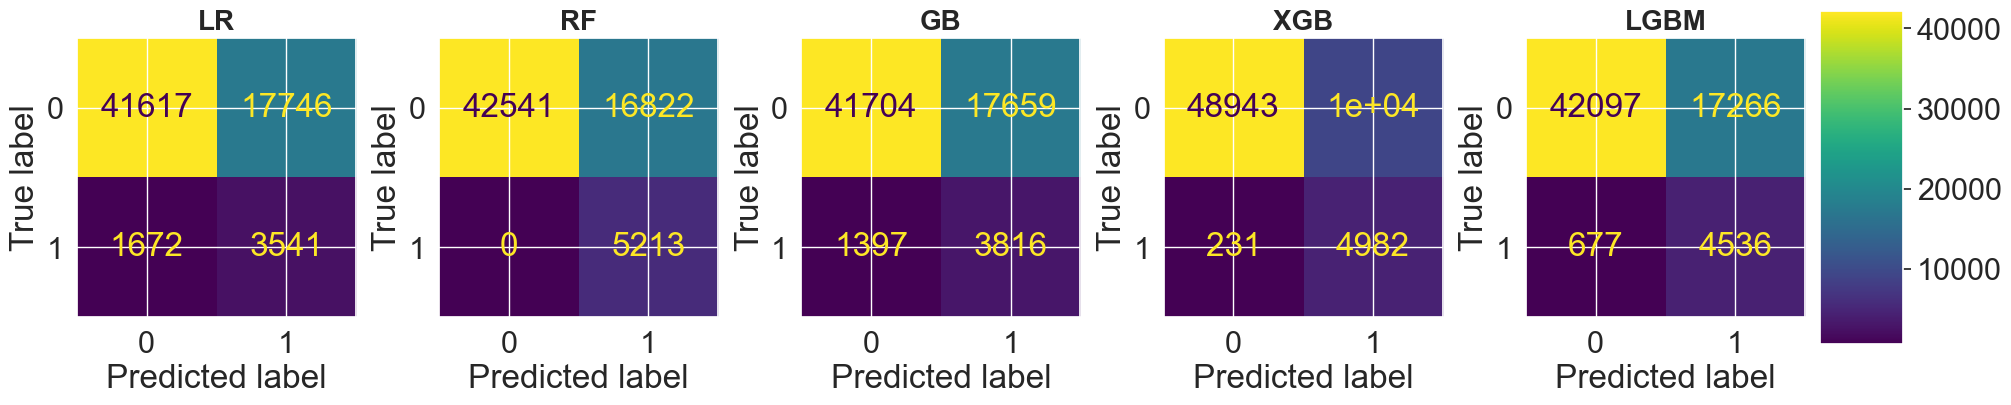

In [77]:
sns.set(font_scale=2.0)
fig, axes = plt.subplots(1, 5, figsize=(20, 4), constrained_layout=True)
g1 = ConfusionMatrixDisplay.from_estimator(grid_logireg3.best_estimator_, X_sub_train, y_sub_train, colorbar=False, ax=axes[0])
g1.ax_.set_title('LR', fontsize=20, fontweight='bold')
g2 = ConfusionMatrixDisplay.from_estimator(grid_RFC3.best_estimator_, X_sub_train, y_sub_train, colorbar=False, ax=axes[1])
g2.ax_.set_title('RF', fontsize=20, fontweight='bold')
g3 = ConfusionMatrixDisplay.from_estimator(grid_GBC3.best_estimator_, X_sub_train, y_sub_train, colorbar=False, ax=axes[2])
g3.ax_.set_title('GB', fontsize=20, fontweight='bold')
g4 = ConfusionMatrixDisplay.from_estimator(grid_XGBC3.best_estimator_, X_sub_train, y_sub_train, colorbar=False, ax=axes[3])
g4.ax_.set_title('XGB', fontsize=20, fontweight='bold')
g5 = ConfusionMatrixDisplay.from_estimator(grid_LGBM3.best_estimator_, X_sub_train, y_sub_train, ax=axes[4])
g5.ax_.set_title('LGBM', fontsize=20, fontweight='bold')

Text(0.5, 1.0, 'LGBM')

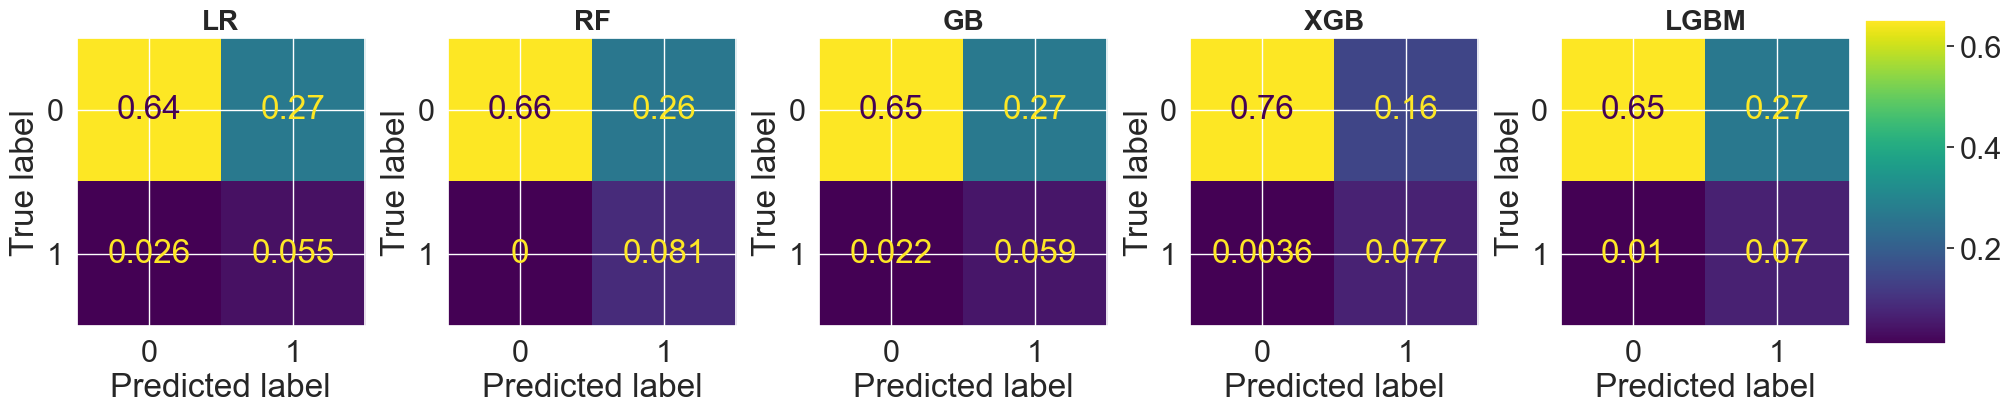

In [78]:
sns.set(font_scale=2.0)
fig, axes = plt.subplots(1, 5, figsize=(20, 4), constrained_layout=True)
g1 = ConfusionMatrixDisplay.from_estimator(grid_logireg3.best_estimator_, X_sub_train, y_sub_train, normalize='all', colorbar=False, ax=axes[0])
g1.ax_.set_title('LR', fontsize=20, fontweight='bold')
g2 = ConfusionMatrixDisplay.from_estimator(grid_RFC3.best_estimator_, X_sub_train, y_sub_train, normalize='all', colorbar=False, ax=axes[1])
g2.ax_.set_title('RF', fontsize=20, fontweight='bold')
g3 = ConfusionMatrixDisplay.from_estimator(grid_GBC3.best_estimator_, X_sub_train, y_sub_train, normalize='all', colorbar=False, ax=axes[2])
g3.ax_.set_title('GB', fontsize=20, fontweight='bold')
g4 = ConfusionMatrixDisplay.from_estimator(grid_XGBC3.best_estimator_, X_sub_train, y_sub_train, normalize='all', colorbar=False, ax=axes[3])
g4.ax_.set_title('XGB', fontsize=20, fontweight='bold')
g5 = ConfusionMatrixDisplay.from_estimator(grid_LGBM3.best_estimator_, X_sub_train, y_sub_train, normalize='all', ax=axes[4])
g5.ax_.set_title('LGBM', fontsize=20, fontweight='bold')

Text(0.5, 1.0, 'LGBM')

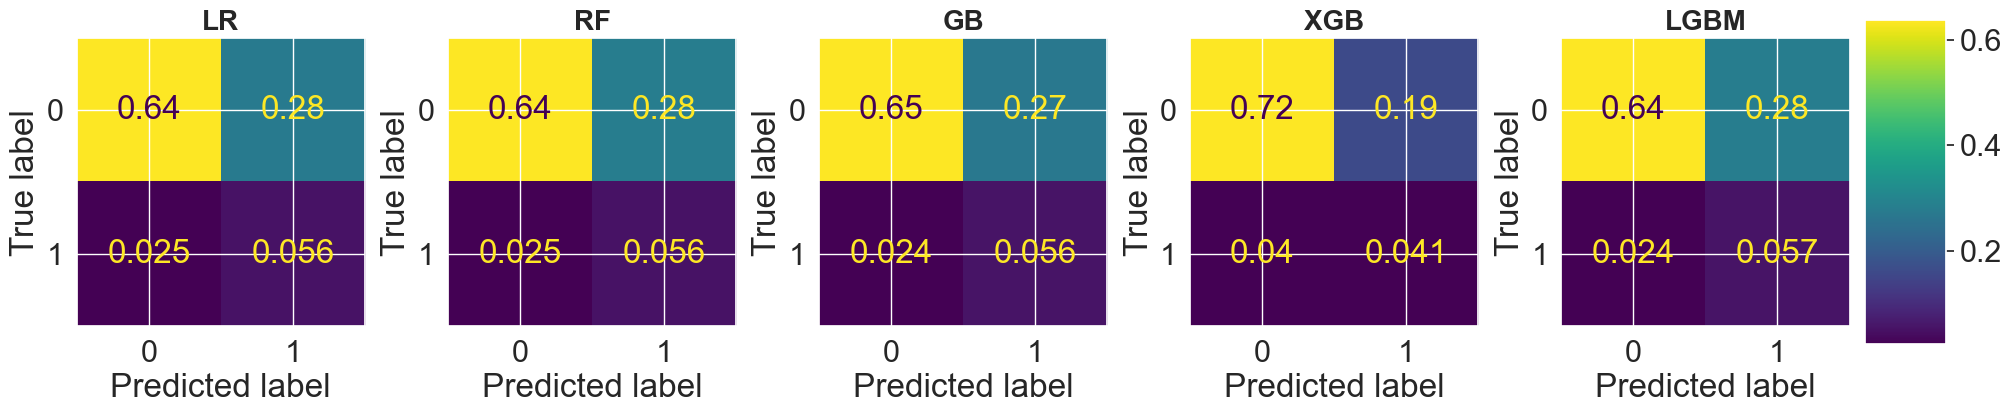

In [79]:
sns.set(font_scale=2.0)
fig, axes = plt.subplots(1, 5, figsize=(20, 4), constrained_layout=True)
g1 = ConfusionMatrixDisplay.from_estimator(grid_logireg3.best_estimator_, X_sub_test, y_sub_test, normalize='all', colorbar=False, ax=axes[0])
g1.ax_.set_title('LR', fontsize=20, fontweight='bold')
g2 = ConfusionMatrixDisplay.from_estimator(grid_RFC3.best_estimator_, X_sub_test, y_sub_test, normalize='all', colorbar=False, ax=axes[1])
g2.ax_.set_title('RF', fontsize=20, fontweight='bold')
g3 = ConfusionMatrixDisplay.from_estimator(grid_GBC3.best_estimator_, X_sub_test, y_sub_test, normalize='all', colorbar=False, ax=axes[2])
g3.ax_.set_title('GB', fontsize=20, fontweight='bold')
g4 = ConfusionMatrixDisplay.from_estimator(grid_XGBC3.best_estimator_, X_sub_test, y_sub_test, normalize='all', colorbar=False, ax=axes[3])
g4.ax_.set_title('XGB', fontsize=20, fontweight='bold')
g5 = ConfusionMatrixDisplay.from_estimator(grid_LGBM3.best_estimator_, X_sub_test, y_sub_test, normalize='all', ax=axes[4])
g5.ax_.set_title('LGBM', fontsize=20, fontweight='bold')

## v4 - imbalance, pr_curve

In [170]:
model_list4 = []
mean_train_score_list4 = []
mean_train_time_list4 = []
mean_test_score_list4 = []
mean_test_time_list4 = []

### Binary classification baseline: logistic regression

In [171]:
param_grid_logireg4 = {'imputer': [SimpleImputer(missing_values=np.nan, strategy='median')],
                      'scaler': [non_bin_scaler],
                      'sampler': [SMOTE(), RandomUnderSampler()],
                      'classifier': [LogisticRegression()],
                      'classifier__class_weight': [True]}

grid_logireg4 = GridSearchCV(pipe,
                            param_grid=param_grid_logireg4,
                            return_train_score=True,
                            scoring='average_precision',
                            cv=5, # For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. 
                            verbose=3)

grid_logireg4.fit(X_sub_train, y_sub_train)

best_model_index = grid_logireg4.best_index_

print('###### For logistic regression:')
print('-' * 20)
print('Best params are:\n', grid_logireg4.best_params_)
print('-' * 20)
print('Corresponding mean scores and times are:')
print('Mean train score: {}'.format(grid_logireg4.cv_results_['mean_train_score'][best_model_index]))
print('Mean test score: {}'.format(grid_logireg4.cv_results_['mean_test_score'][best_model_index]))
print('Mean train time: {}'.format(grid_logireg4.cv_results_['mean_fit_time'][best_model_index]))
print('Mean test time: {}'.format(grid_logireg4.cv_results_['mean_score_time'][best_model_index]))

model_list4.append('Baseline-LogisticRegression')
mean_train_score_list4.append(grid_logireg4.cv_results_['mean_train_score'][best_model_index])
mean_train_time_list4.append(grid_logireg4.cv_results_['mean_fit_time'][best_model_index])
mean_test_score_list4.append(grid_logireg4.cv_results_['mean_test_score'][best_model_index])
mean_test_time_list4.append(grid_logireg4.cv_results_['mean_score_time'][best_model_index])

Fitting 5 folds for each of 2 candidates, totalling 10 fits


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END classifier=LogisticRegression(), classifier__class_weight=True, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.229, test=0.240) total time=   3.1s
[CV 2/5] END classifier=LogisticRegression(), classifier__class_weight=True, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58,

C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END classifier=LogisticRegression(), classifier__class_weight=True, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.230, test=0.248) total time=   0.9s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END classifier=LogisticRegression(), classifier__class_weight=True, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.234, test=0.223) total time=   0.9s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END classifier=LogisticRegression(), classifier__class_weight=True, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.235, test=0.224) total time=   0.9s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END classifier=LogisticRegression(), classifier__class_weight=True, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.237, test=0.221) total time=   1.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END classifier=LogisticRegression(), classifier__class_weight=True, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.237, test=0.220) total time=   1.0s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
4 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\imblearn\pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\user\anaconda3\lib\site-packages\imblearn\pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\user\anacon

###### For logistic regression:
--------------------
Best params are:
 {'classifier': LogisticRegression(class_weight=True), 'classifier__class_weight': True, 'imputer': SimpleImputer(strategy='median'), 'sampler': RandomUnderSampler(), 'scaler': ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])])}
--------------------
Corresponding mean scores and times are:
Mean train score: 0.23479965023280852
Mean test score: 0.22733164083933155
Mean train time: 0.9863218307495117
Mean test time: 0.042594099044799806


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Test of different classifiers
--> with default hyperparameters

#### Random Forest Classifier

In [172]:
param_grid_RFC4 = {'imputer': [SimpleImputer(missing_values=np.nan, strategy='median')],
                  'scaler': [non_bin_scaler],
                  'sampler': [SMOTE(), RandomUnderSampler()],
                  'classifier': [RandomForestClassifier()],
                  'classifier__class_weight': ['balanced', 'balanced_subsample']}

grid_RFC4 = GridSearchCV(pipe,
                        param_grid=param_grid_RFC4,
                        return_train_score=True,
                        scoring='average_precision',
                        cv=5, # For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. 
                        verbose=3)

grid_RFC4.fit(X_sub_train, y_sub_train)

best_model_index = grid_RFC4.best_index_

print('###### For Random Forest Classifier:')
print('-' * 20)
print('Best params are:\n', grid_RFC4.best_params_)
print('-' * 20)
print('Corresponding mean scores and times are:')
print('Mean train score: {}'.format(grid_RFC4.cv_results_['mean_train_score'][best_model_index]))
print('Mean test score: {}'.format(grid_RFC4.cv_results_['mean_test_score'][best_model_index]))
print('Mean train time: {}'.format(grid_RFC4.cv_results_['mean_fit_time'][best_model_index]))
print('Mean test time: {}'.format(grid_RFC4.cv_results_['mean_score_time'][best_model_index]))

model_list4.append('Random Forest Classifier')
mean_train_score_list4.append(grid_RFC4.cv_results_['mean_train_score'][best_model_index])
mean_train_time_list4.append(grid_RFC4.cv_results_['mean_fit_time'][best_model_index])
mean_test_score_list4.append(grid_RFC4.cv_results_['mean_test_score'][best_model_index])
mean_test_time_list4.append(grid_RFC4.cv_results_['mean_score_time'][best_model_index])

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=1.000, test=0.207) total time=  44.2s
[CV 2/5] END classifier=RandomForestClassifier(), classifier__class_weight=balanced, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 4

[CV 1/5] END classifier=RandomForestClassifier(), classifier__class_weight=balanced_subsample, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.901, test=0.217) total time=   3.5s
[CV 2/5] END classifier=RandomForestClassifier(), classifier__class_weight=balanced_subsample, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46,

#### Gradient Boosting Classifier

In [173]:
param_grid_GBC4 = {'imputer': [SimpleImputer(missing_values=np.nan, strategy='median')],
                  'scaler': [non_bin_scaler],
                  'sampler': [SMOTE(), RandomUnderSampler()],
                  'classifier': [GradientBoostingClassifier()],
                  'classifier__random_state': [0]}

grid_GBC4 = GridSearchCV(pipe,
                        param_grid=param_grid_GBC4,
                        return_train_score=True,
                        scoring='average_precision',
                        cv=5, # For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. 
                        verbose=3)

grid_GBC4.fit(X_sub_train, y_sub_train)

best_model_index = grid_GBC4.best_index_

print('###### For Gradient Boosting Classifier:')
print('-' * 20)
print('Best params are:\n', grid_GBC4.best_params_)
print('-' * 20)
print('Corresponding mean scores and times are:')
print('Mean train score: {}'.format(grid_GBC4.cv_results_['mean_train_score'][best_model_index]))
print('Mean test score: {}'.format(grid_GBC4.cv_results_['mean_test_score'][best_model_index]))
print('Mean train time: {}'.format(grid_GBC4.cv_results_['mean_fit_time'][best_model_index]))
print('Mean test time: {}'.format(grid_GBC4.cv_results_['mean_score_time'][best_model_index]))

model_list4.append('Gradient Boosting Classifier')
mean_train_score_list4.append(grid_GBC4.cv_results_['mean_train_score'][best_model_index])
mean_train_time_list4.append(grid_GBC4.cv_results_['mean_fit_time'][best_model_index])
mean_test_score_list4.append(grid_GBC4.cv_results_['mean_test_score'][best_model_index])
mean_test_time_list4.append(grid_GBC4.cv_results_['mean_score_time'][best_model_index])

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END classifier=GradientBoostingClassifier(), classifier__random_state=0, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.208, test=0.197) total time= 2.9min
[CV 2/5] END classifier=GradientBoostingClassifier(), classifier__random_state=0, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44,

#### XGBoost classifier

In [174]:
param_grid_XGBC4 = {'imputer': [SimpleImputer(missing_values=np.nan, strategy='median'), 'passthrough'],
                   'scaler': [non_bin_scaler],
                   'sampler': [SMOTE(), RandomUnderSampler()],
                   'classifier': [XGBClassifier()],
                   'classifier__objective': ['binary:logistic'],
                   'classifier__eval_metric': ['aucpr'],
                   'classifier__missing': [np.nan],
                   'classifier__scale_pos_weight': [None, 1/0.0807]}

grid_XGBC4 = GridSearchCV(pipe,
                        param_grid=param_grid_XGBC4,
                        return_train_score=True,
                        scoring='average_precision',
                        cv=5, # For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. 
                        verbose=3)

grid_XGBC4.fit(X_sub_train, y_sub_train)

best_model_index = grid_XGBC4.best_index_

print('###### For XGBoost Classifier:')
print('-' * 20)
print('Best params are:\n', grid_XGBC4.best_params_)
print('-' * 20)
print('Corresponding mean scores and times are:')
print('Mean train score: {}'.format(grid_XGBC4.cv_results_['mean_train_score'][best_model_index]))
print('Mean test score: {}'.format(grid_XGBC4.cv_results_['mean_test_score'][best_model_index]))
print('Mean train time: {}'.format(grid_XGBC4.cv_results_['mean_fit_time'][best_model_index]))
print('Mean test time: {}'.format(grid_XGBC4.cv_results_['mean_score_time'][best_model_index]))

model_list4.append('XGBoost Classifier')
mean_train_score_list4.append(grid_XGBC4.cv_results_['mean_train_score'][best_model_index])
mean_train_time_list4.append(grid_XGBC4.cv_results_['mean_fit_time'][best_model_index])
mean_test_score_list4.append(grid_XGBC4.cv_results_['mean_test_score'][best_model_index])
mean_test_time_list4.append(grid_XGBC4.cv_results_['mean_score_time'][best_model_index])

Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler',

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler',

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler',

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler',

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler',

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('sta

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('sta

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('sta

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('sta

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('sta

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=passthrough, sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', Standar

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=passthrough, sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', Standar

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=passthrough, sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', Standar

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=passthrough, sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', Standar

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=None, imputer=passthrough, sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', Standar

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('st

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('st

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('st

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('st

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('st

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  trans

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  trans

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  trans

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  trans

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=SimpleImputer(strategy='median'), sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  trans

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=passthrough, sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardsc

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=passthrough, sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardsc

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=passthrough, sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardsc

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 4/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=passthrough, sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardsc

C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 5/5] END classifier=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), classifier__eval_metric=aucpr, classifier__missing=nan, classifier__objective=binary:logistic, classifier__scale_pos_weight=12.391573729863694, imputer=passthrough, sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardsc

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\imblearn\pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\user\anaconda3\lib\site-packages\imblearn\pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\user\anac

###### For XGBoost Classifier:
--------------------
Best params are:
 {'classifier': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, eval_metric='aucpr', gamma=None,
              gpu_id=None, importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None), 'classifier__eval_metric': 'aucpr', 'classifier__missing': nan, 'classifier__objective': 'binary:logistic', 'classifier__scale_pos_weight': None, 'imputer': 'passthrough', 'sampler': RandomUnderSampler(), 's

#### LightGBM classifier

In [175]:
param_grid_LGBM4 = {'imputer': [SimpleImputer(missing_values=np.nan, strategy='median'), 'passthrough'],
                   'scaler': [non_bin_scaler],
                   'sampler': [SMOTE(), RandomUnderSampler()],
                   'classifier': [LGBMClassifier()],
                   'classifier__objective': ['binary'],
                   'classifier__is_unbalance': [True],
                   'classifier__metric': ['average_precision_score']
                   }

grid_LGBM4 = GridSearchCV(pipe,
                        param_grid=param_grid_LGBM4,
                        return_train_score=True,
                        scoring='average_precision',
                        cv=5, # For integer/None inputs, if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used. 
                        verbose=3)

grid_LGBM4.fit(X_sub_train, y_sub_train)

best_model_index = grid_LGBM4.best_index_

print('###### For LGBM Classifier:')
print('-' * 20)
print('Best params are:\n', grid_LGBM4.best_params_)
print('-' * 20)
print('Corresponding mean scores and times are:')
print('Mean train score: {}'.format(grid_LGBM4.cv_results_['mean_train_score'][best_model_index]))
print('Mean test score: {}'.format(grid_LGBM4.cv_results_['mean_test_score'][best_model_index]))
print('Mean train time: {}'.format(grid_LGBM4.cv_results_['mean_fit_time'][best_model_index]))
print('Mean test time: {}'.format(grid_LGBM4.cv_results_['mean_score_time'][best_model_index]))

model_list4.append('LGBM Classifier')
mean_train_score_list4.append(grid_LGBM4.cv_results_['mean_train_score'][best_model_index])
mean_train_time_list4.append(grid_LGBM4.cv_results_['mean_fit_time'][best_model_index])
mean_test_score_list4.append(grid_LGBM4.cv_results_['mean_test_score'][best_model_index])
mean_test_time_list4.append(grid_LGBM4.cv_results_['mean_score_time'][best_model_index])

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END classifier=LGBMClassifier(), classifier__is_unbalance=True, classifier__metric=average_precision_score, classifier__objective=binary, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=0.398, test=0.226) total time=   3.2s
[CV 2/5] END classifier=LGBMClassifier(), classifier__is_unbalance=True, classifier__metric=average_precision_score, classifier__objective=binary, imputer=SimpleImputer(strategy='median'), sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
            

[CV 5/5] END classifier=LGBMClassifier(), classifier__is_unbalance=True, classifier__metric=average_precision_score, classifier__objective=binary, imputer=passthrough, sampler=SMOTE(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])]);, score=(train=nan, test=nan) total time=   0.1s
[CV 1/5] END classifier=LGBMClassifier(), classifier__is_unbalance=True, classifier__metric=average_precision_score, classifier__objective=binary, imputer=passthrough, sampler=RandomUnderSampler(), scaler=ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                        

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\imblearn\pipeline.py", line 262, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\user\anaconda3\lib\site-packages\imblearn\pipeline.py", line 220, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\user\anacon

###### For LGBM Classifier:
--------------------
Best params are:
 {'classifier': LGBMClassifier(is_unbalance=True, metric='average_precision_score',
               objective='binary'), 'classifier__is_unbalance': True, 'classifier__metric': 'average_precision_score', 'classifier__objective': 'binary', 'imputer': 'passthrough', 'sampler': RandomUnderSampler(), 'scaler': ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                  21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                  49, 50, 51, 57, 58, 59, ...])])}
--------------------
Corresponding mean scores and times are:
Mean train score: 0.39751030111621677
Mean test score: 0.22894576892450275
Mean train time: 0.6322507858276367
Mean test time: 0.05948858261108399


### Comparison

In [176]:
model_list4

['Baseline-LogisticRegression',
 'Random Forest Classifier',
 'Gradient Boosting Classifier',
 'XGBoost Classifier',
 'LGBM Classifier']

In [177]:
model_list4_short = ['LR', 'RF', 'GB', 'XGB', 'LGBM']
results_dict4 = {'Model': model_list4_short,
                'mean_train_score': mean_train_score_list4,
                'mean_train_time': mean_train_time_list4,
                'mean_test_score': mean_test_score_list4,
                'mean_test_time': mean_test_time_list4}

results4 = pd.DataFrame(results_dict4)

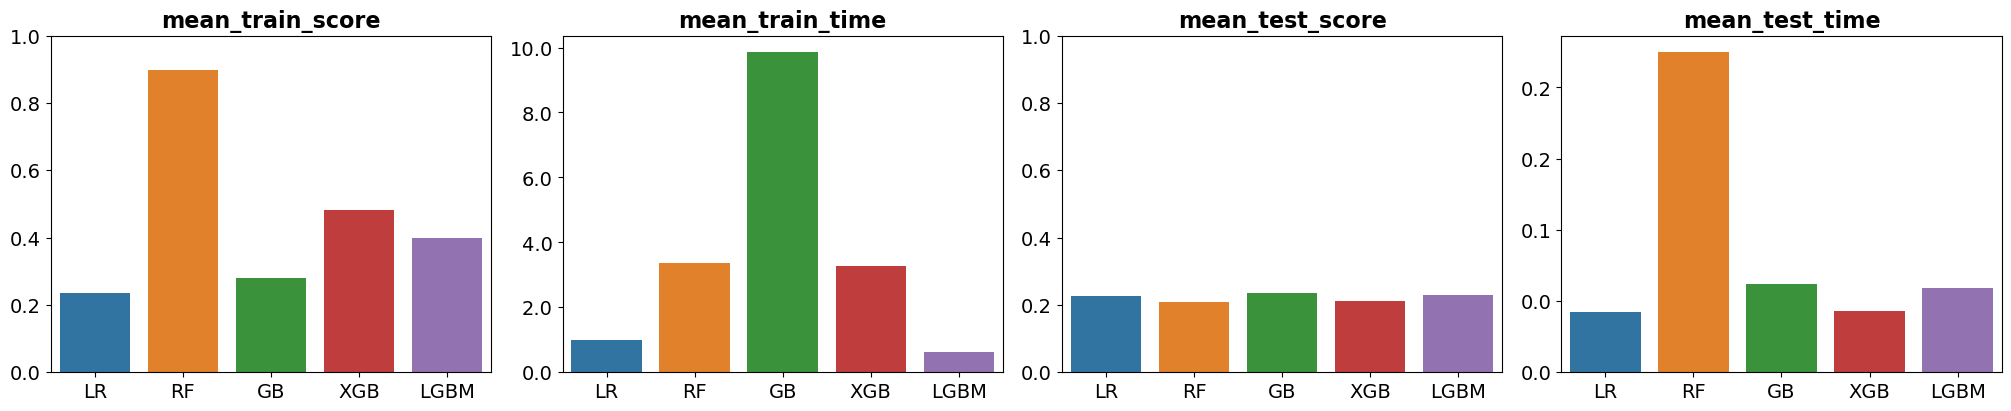

In [178]:
sns.reset_orig
plt.style.use('default')

fig, axes = plt.subplots(1, 4, figsize=(20, 4), constrained_layout=True)
g1 = sns.barplot(x='Model', y='mean_train_score', data=results_dict4, ax=axes[0])
g1.set_title('mean_train_score', fontsize=16, fontweight='bold')
g1.set_ylim(0,1)
g2 = sns.barplot(x='Model', y='mean_train_time', data=results_dict4, ax=axes[1])
g2.set_title('mean_train_time', fontsize=16, fontweight='bold')
g3 = sns.barplot(x='Model', y='mean_test_score', data=results_dict4, ax=axes[2])
g3.set_ylim(0,1)
g3.set_title('mean_test_score', fontsize=16, fontweight='bold')
g4 = sns.barplot(x='Model', y='mean_test_time', data=results_dict4, ax=axes[3])
g4.set_title('mean_test_time', fontsize=16, fontweight='bold')

for g in [g1, g2, g3, g4]:
    g.set_xticklabels(g.get_xticklabels(), fontsize=14)
    g.set_yticklabels([round(e,1) for e in g.get_yticks()], size = 14)

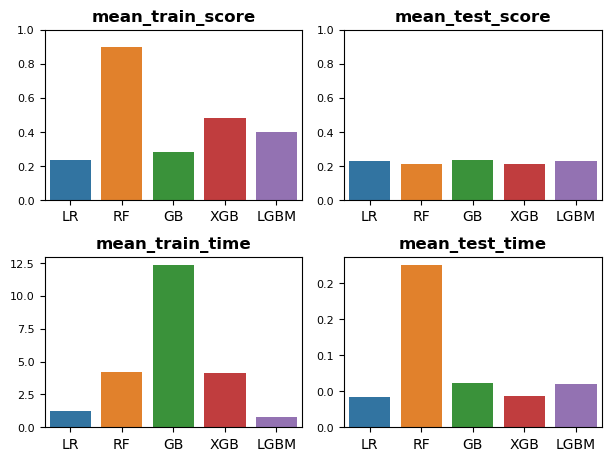

In [180]:
fig, axes = plt.subplots(2, 2, figsize=(6, 4.5), constrained_layout=True)
g1 = sns.barplot(x='Model', y='mean_train_score', data=results_dict4, ax=axes[0][0])
g1.set_title('mean_train_score', fontsize=12, fontweight='bold')
g1.set_ylim(0,1)
g2 = sns.barplot(x='Model', y='mean_train_time', data=results_dict4, ax=axes[1][0])
g2.set_title('mean_train_time', fontsize=12, fontweight='bold')
g3 = sns.barplot(x='Model', y='mean_test_score', data=results_dict4, ax=axes[0][1])
g3.set_ylim(0,1)
g3.set_title('mean_test_score', fontsize=12, fontweight='bold')
g4 = sns.barplot(x='Model', y='mean_test_time', data=results_dict4, ax=axes[1][1])
g4.set_title('mean_test_time', fontsize=12, fontweight='bold')

for g in [g1, g2, g3, g4]:
    g.set_xticklabels(g.get_xticklabels(), fontsize=10)
    g.set_yticklabels([round(e,1) for e in g.get_yticks()], size = 8)

Text(0.5, 1.0, 'LGBM')

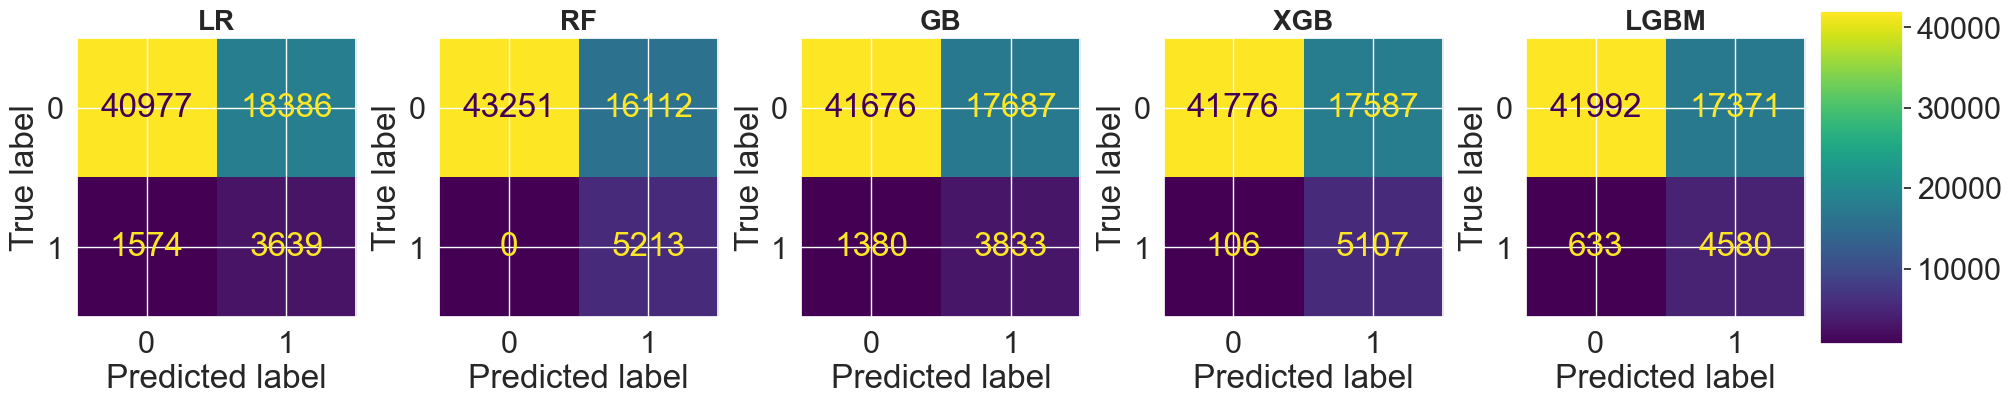

In [181]:
sns.set(font_scale=2.0)
fig, axes = plt.subplots(1, 5, figsize=(20, 4), constrained_layout=True)
g1 = ConfusionMatrixDisplay.from_estimator(grid_logireg4.best_estimator_, X_sub_train, y_sub_train, colorbar=False, ax=axes[0])
g1.ax_.set_title('LR', fontsize=20, fontweight='bold')
g2 = ConfusionMatrixDisplay.from_estimator(grid_RFC4.best_estimator_, X_sub_train, y_sub_train, colorbar=False, ax=axes[1])
g2.ax_.set_title('RF', fontsize=20, fontweight='bold')
g3 = ConfusionMatrixDisplay.from_estimator(grid_GBC4.best_estimator_, X_sub_train, y_sub_train, colorbar=False, ax=axes[2])
g3.ax_.set_title('GB', fontsize=20, fontweight='bold')
g4 = ConfusionMatrixDisplay.from_estimator(grid_XGBC4.best_estimator_, X_sub_train, y_sub_train, colorbar=False, ax=axes[3])
g4.ax_.set_title('XGB', fontsize=20, fontweight='bold')
g5 = ConfusionMatrixDisplay.from_estimator(grid_LGBM4.best_estimator_, X_sub_train, y_sub_train, ax=axes[4])
g5.ax_.set_title('LGBM', fontsize=20, fontweight='bold')

Text(0.5, 1.0, 'LGBM')

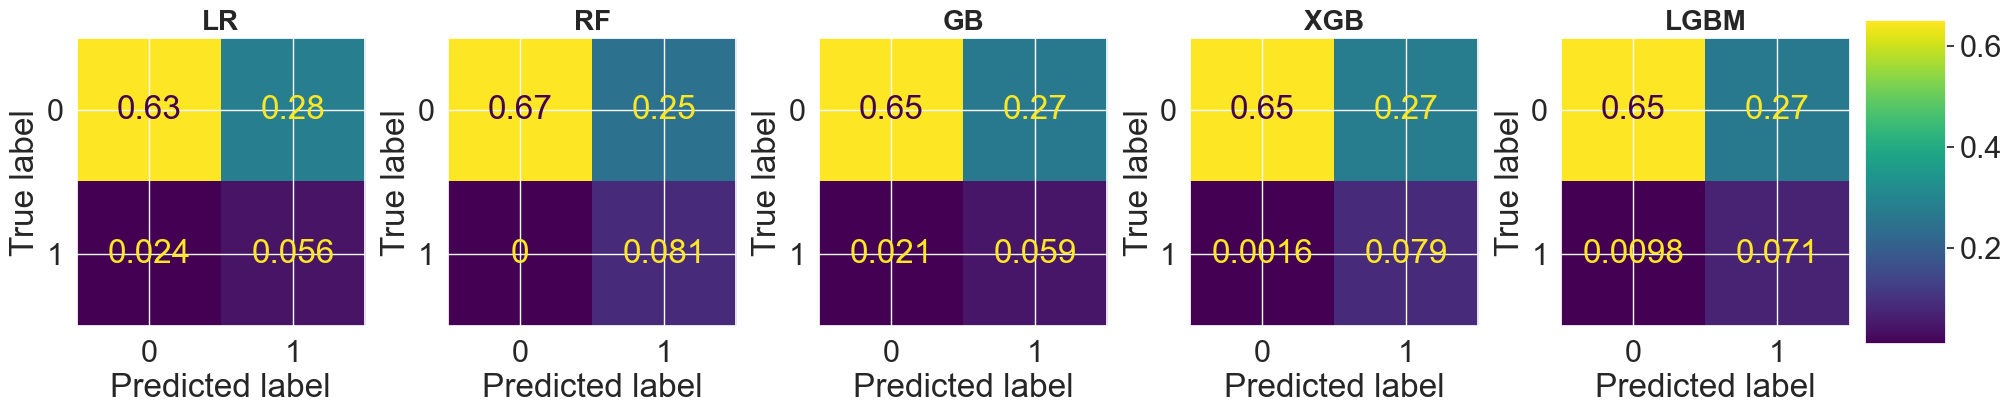

In [182]:
sns.set(font_scale=2.0)
fig, axes = plt.subplots(1, 5, figsize=(20, 4), constrained_layout=True)
g1 = ConfusionMatrixDisplay.from_estimator(grid_logireg4.best_estimator_, X_sub_train, y_sub_train, normalize='all', colorbar=False, ax=axes[0])
g1.ax_.set_title('LR', fontsize=20, fontweight='bold')
g2 = ConfusionMatrixDisplay.from_estimator(grid_RFC4.best_estimator_, X_sub_train, y_sub_train, normalize='all', colorbar=False, ax=axes[1])
g2.ax_.set_title('RF', fontsize=20, fontweight='bold')
g3 = ConfusionMatrixDisplay.from_estimator(grid_GBC4.best_estimator_, X_sub_train, y_sub_train, normalize='all', colorbar=False, ax=axes[2])
g3.ax_.set_title('GB', fontsize=20, fontweight='bold')
g4 = ConfusionMatrixDisplay.from_estimator(grid_XGBC4.best_estimator_, X_sub_train, y_sub_train, normalize='all', colorbar=False, ax=axes[3])
g4.ax_.set_title('XGB', fontsize=20, fontweight='bold')
g5 = ConfusionMatrixDisplay.from_estimator(grid_LGBM4.best_estimator_, X_sub_train, y_sub_train, normalize='all', ax=axes[4])
g5.ax_.set_title('LGBM', fontsize=20, fontweight='bold')

Text(0.5, 1.0, 'LGBM')

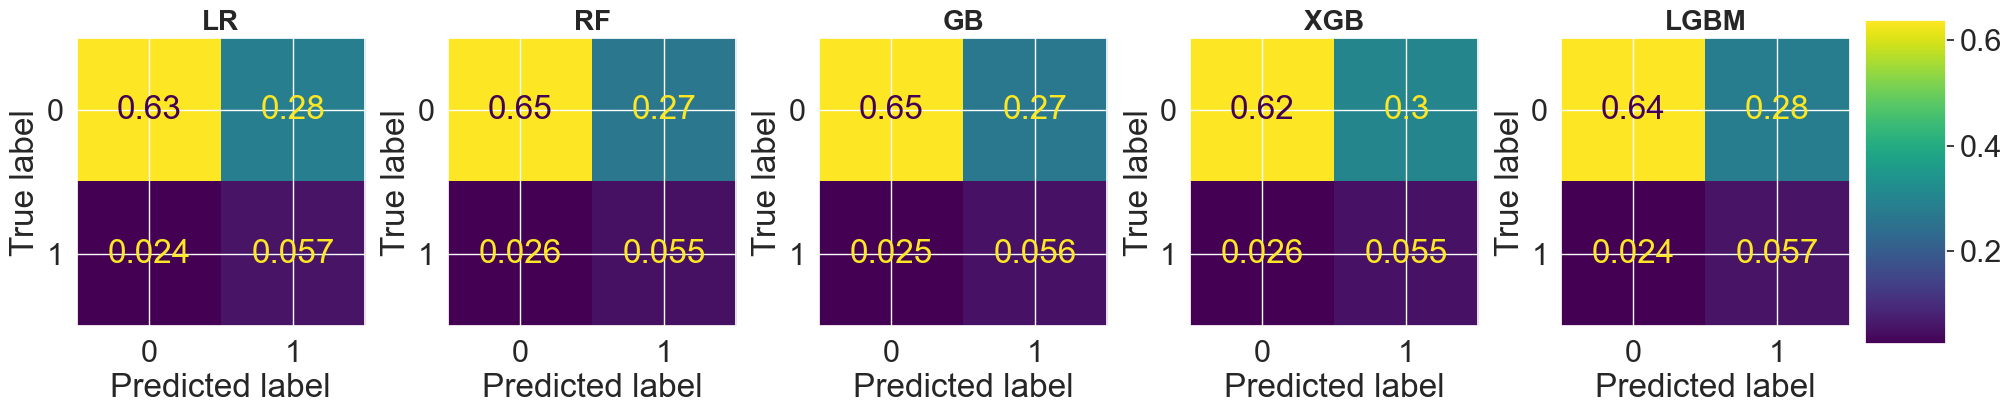

In [183]:
sns.set(font_scale=2.0)
fig, axes = plt.subplots(1, 5, figsize=(20, 4), constrained_layout=True)
g1 = ConfusionMatrixDisplay.from_estimator(grid_logireg4.best_estimator_, X_sub_test, y_sub_test, normalize='all', colorbar=False, ax=axes[0])
g1.ax_.set_title('LR', fontsize=20, fontweight='bold')
g2 = ConfusionMatrixDisplay.from_estimator(grid_RFC4.best_estimator_, X_sub_test, y_sub_test, normalize='all', colorbar=False, ax=axes[1])
g2.ax_.set_title('RF', fontsize=20, fontweight='bold')
g3 = ConfusionMatrixDisplay.from_estimator(grid_GBC4.best_estimator_, X_sub_test, y_sub_test, normalize='all', colorbar=False, ax=axes[2])
g3.ax_.set_title('GB', fontsize=20, fontweight='bold')
g4 = ConfusionMatrixDisplay.from_estimator(grid_XGBC4.best_estimator_, X_sub_test, y_sub_test, normalize='all', colorbar=False, ax=axes[3])
g4.ax_.set_title('XGB', fontsize=20, fontweight='bold')
g5 = ConfusionMatrixDisplay.from_estimator(grid_LGBM4.best_estimator_, X_sub_test, y_sub_test, normalize='all', ax=axes[4])
g5.ax_.set_title('LGBM', fontsize=20, fontweight='bold')

## Comparison of comparisons!
* **Plotting mean train/test scores/times depending on scoring metric****

Text(0, 0.5, '(Un)balanced/(Not)sampled, roc-auc')

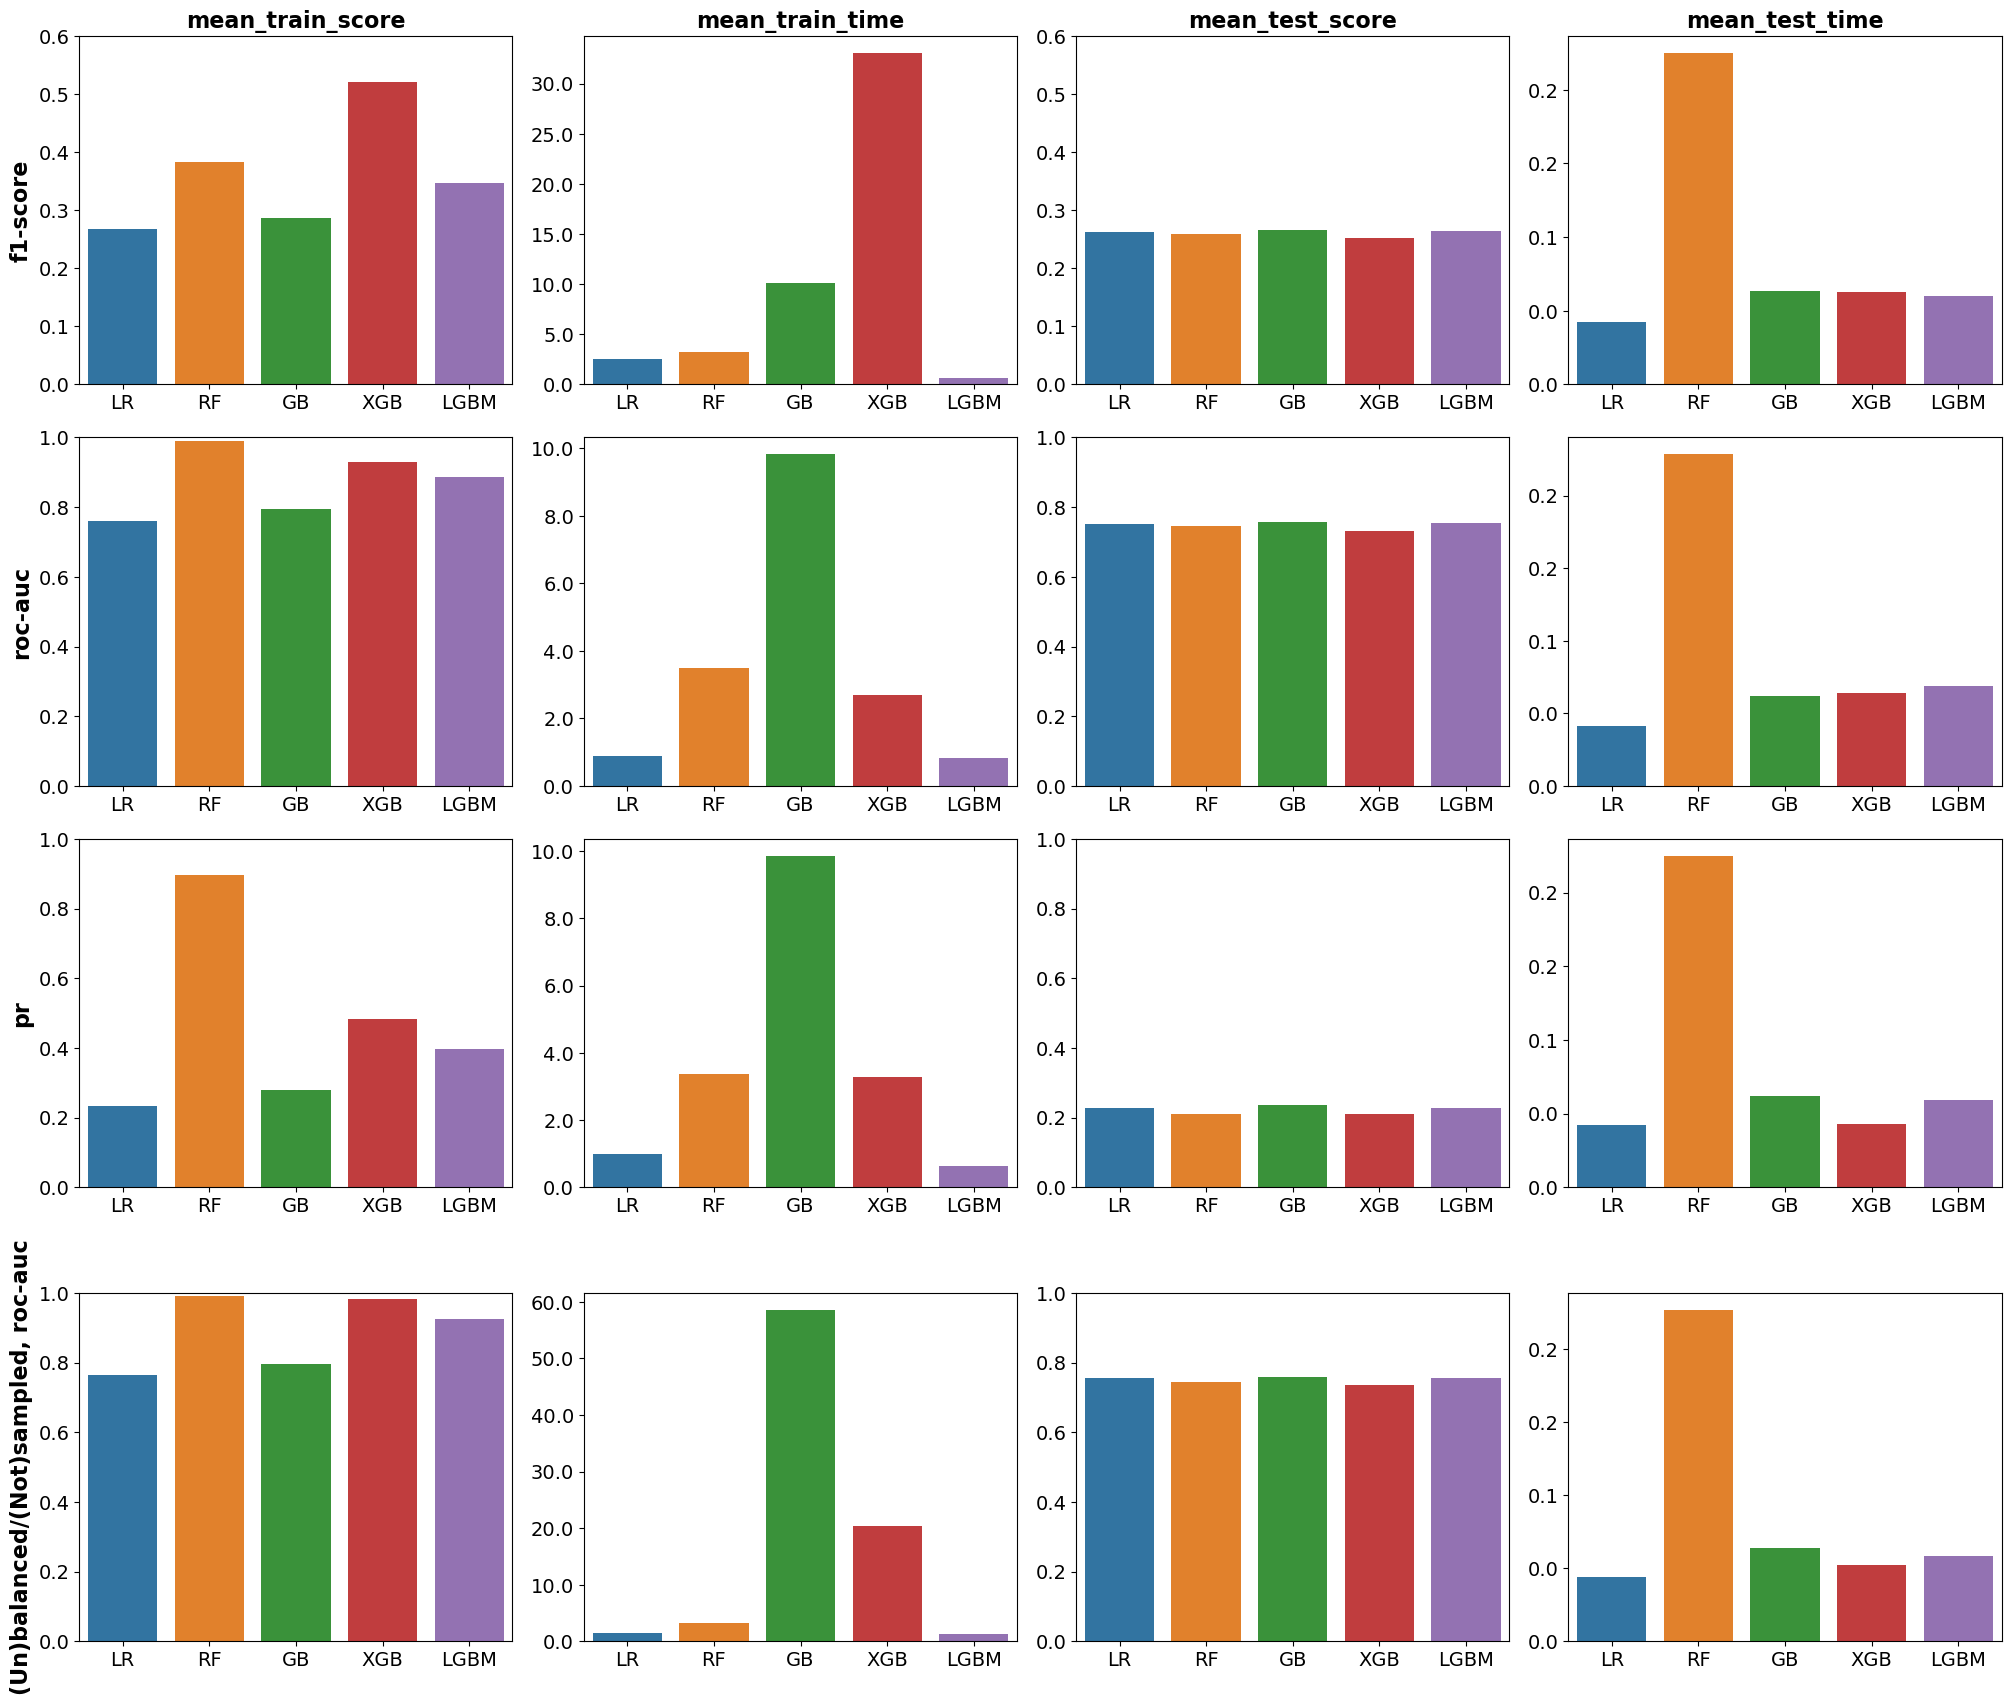

In [187]:
sns.reset_orig
plt.style.use('default')

fig, axes = plt.subplots(4, 4, figsize=(20, 17), constrained_layout=True)
g1 = sns.barplot(x='Model', y='mean_train_score', data=results_dict3, ax=axes[0][0])
g1.set_title('mean_train_score', fontsize=16, fontweight='bold')
g1.set_ylim(0,0.6)
g2 = sns.barplot(x='Model', y='mean_train_time', data=results_dict3, ax=axes[0][1])
g2.set_title('mean_train_time', fontsize=16, fontweight='bold')
g3 = sns.barplot(x='Model', y='mean_test_score', data=results_dict3, ax=axes[0][2])
g3.set_ylim(0,0.6)
g3.set_title('mean_test_score', fontsize=16, fontweight='bold')
g4 = sns.barplot(x='Model', y='mean_test_time', data=results_dict3, ax=axes[0][3])
g4.set_title('mean_test_time', fontsize=16, fontweight='bold')

g5 = sns.barplot(x='Model', y='mean_train_score', data=results_dict2, ax=axes[1][0])
#g5.set_title('mean_train_score', fontsize=16, fontweight='bold')
g5.set_ylim(0,1)
g6 = sns.barplot(x='Model', y='mean_train_time', data=results_dict2, ax=axes[1][1])
#g6.set_title('mean_train_time', fontsize=16, fontweight='bold')
g7 = sns.barplot(x='Model', y='mean_test_score', data=results_dict2, ax=axes[1][2])
g7.set_ylim(0,1)
#g7.set_title('mean_test_score', fontsize=16, fontweight='bold')
g8 = sns.barplot(x='Model', y='mean_test_time', data=results_dict2, ax=axes[1][3])
#g8.set_title('mean_test_time', fontsize=16, fontweight='bold')

g9 = sns.barplot(x='Model', y='mean_train_score', data=results_dict4, ax=axes[2][0])
#g9.set_title('mean_train_score', fontsize=16, fontweight='bold')
g9.set_ylim(0,1)
g10 = sns.barplot(x='Model', y='mean_train_time', data=results_dict4, ax=axes[2][1])
#g10.set_title('mean_train_time', fontsize=16, fontweight='bold')
g11 = sns.barplot(x='Model', y='mean_test_score', data=results_dict4, ax=axes[2][2])
g11.set_ylim(0,1)
#g11.set_title('mean_test_score', fontsize=16, fontweight='bold')
g12 = sns.barplot(x='Model', y='mean_test_time', data=results_dict4, ax=axes[2][3])
#g12.set_title('mean_test_time', fontsize=16, fontweight='bold')

g13 = sns.barplot(x='Model', y='mean_train_score', data=results_dict, ax=axes[3][0])
#g9.set_title('mean_train_score', fontsize=16, fontweight='bold')
g13.set_ylim(0,1)
g14 = sns.barplot(x='Model', y='mean_train_time', data=results_dict, ax=axes[3][1])
#g14.set_title('mean_train_time', fontsize=16, fontweight='bold')
g15 = sns.barplot(x='Model', y='mean_test_score', data=results_dict, ax=axes[3][2])
g15.set_ylim(0,1)
#g15.set_title('mean_test_score', fontsize=16, fontweight='bold')
g16 = sns.barplot(x='Model', y='mean_test_time', data=results_dict, ax=axes[3][3])
#g16.set_title('mean_test_time', fontsize=16, fontweight='bold')

for g in [g1, g2, g3, g4, g5, g6, g7, g8, g9, g10, g11, g12, g13, g14, g15, g16]:
    g.set_xticklabels(g.get_xticklabels(), fontsize=14)
    g.set_yticklabels([round(e,1) for e in g.get_yticks()], size = 14)

for g in [g1, g2, g3, g4, g5, g6, g7, g8, g9, g10, g11, g12, g13, g14, g15, g16]:
    g.set_ylabel('')
    g.set_xlabel('')

g1.set_ylabel('f1-score', fontsize=16, fontweight='bold')
g5.set_ylabel('roc-auc', fontsize=16, fontweight='bold')
g9.set_ylabel('pr', fontsize=16, fontweight='bold')
g13.set_ylabel('(Un)balanced/(Not)sampled, roc-auc', fontsize=16, fontweight='bold')

* **Plotting confusion matrices -- train set**

Text(0, 0.5, 'roc-auc\n--\nTrue label')

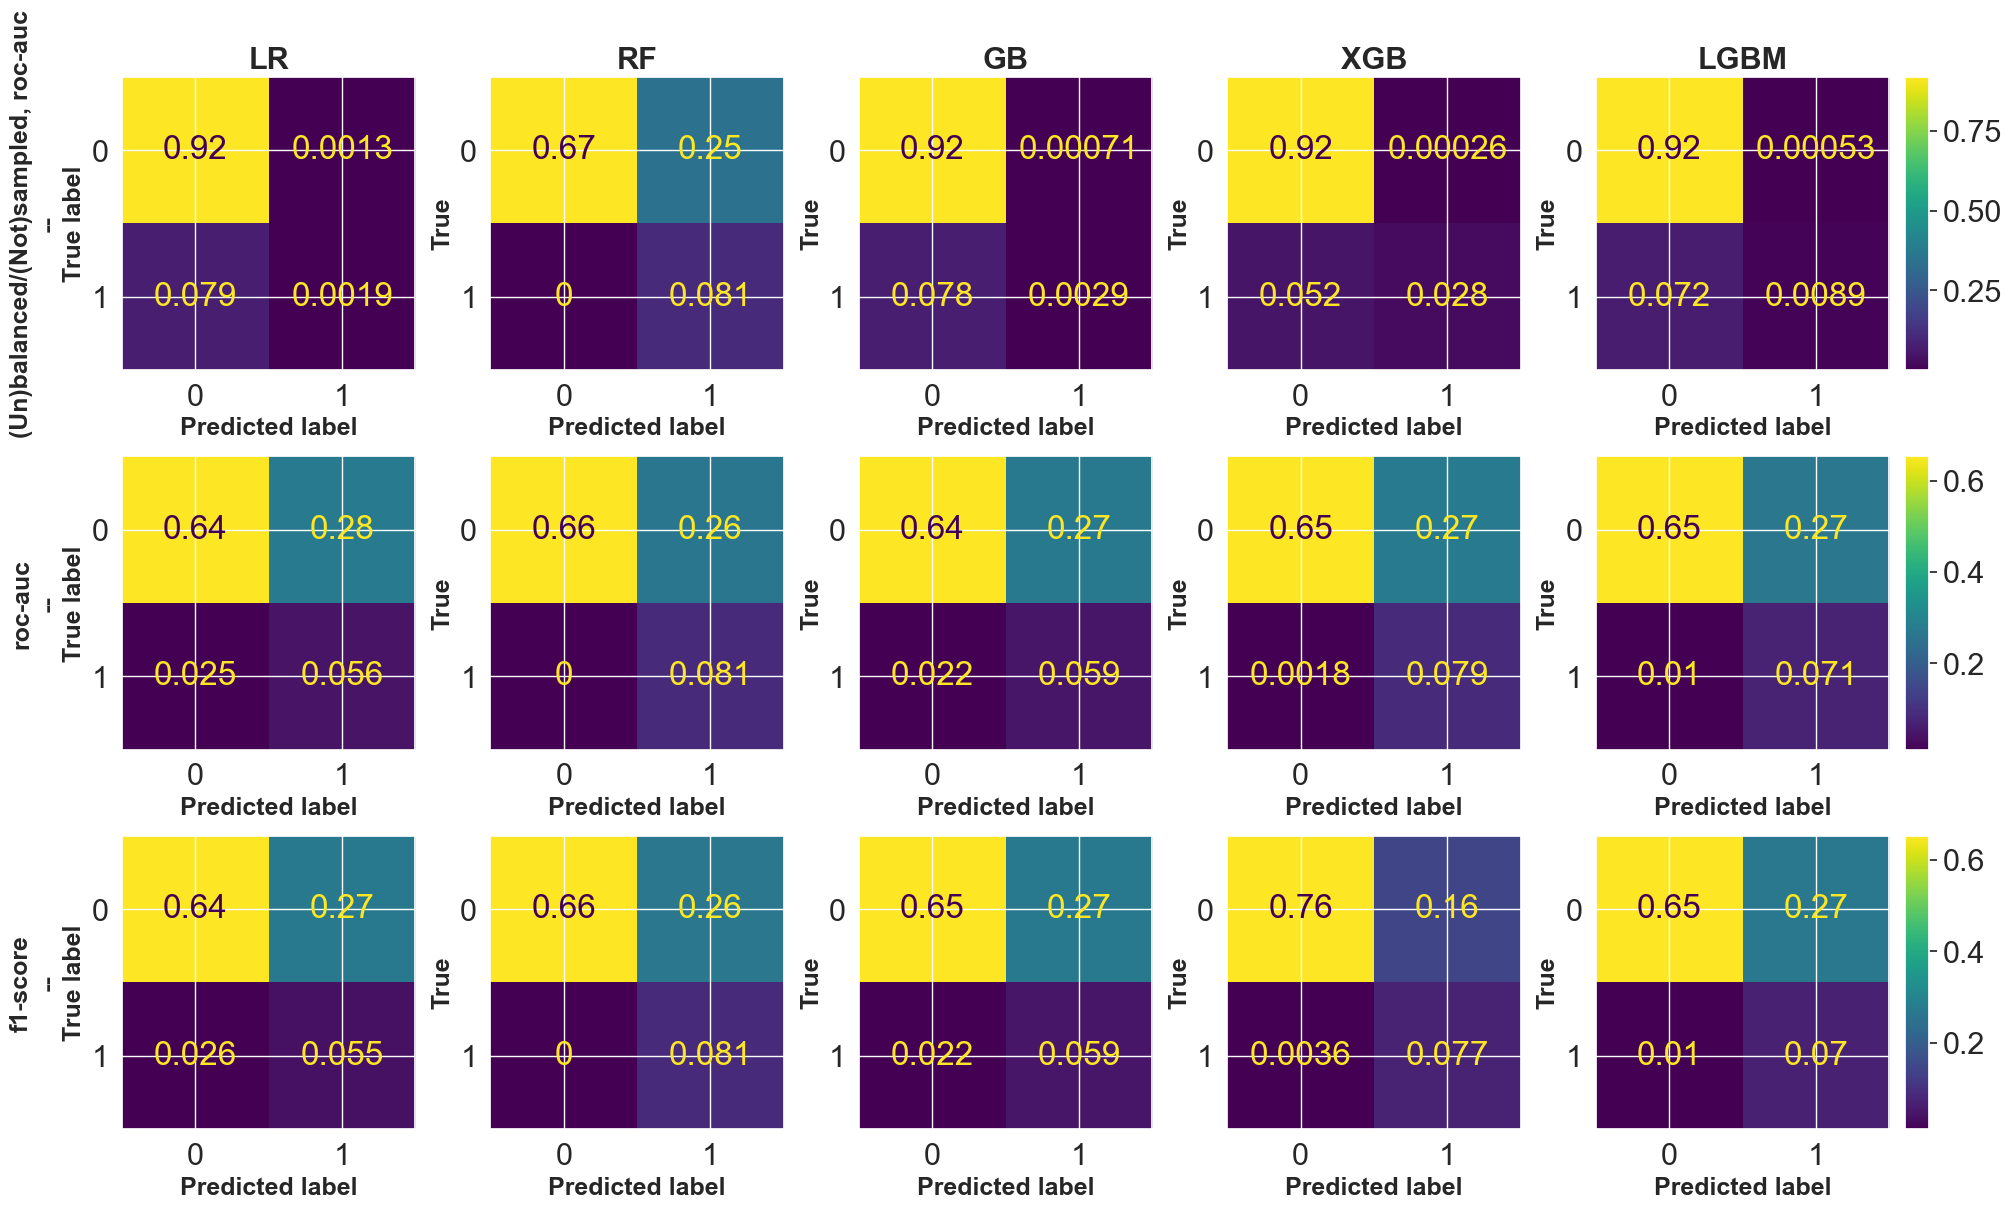

In [81]:
sns.set(font_scale=2.0)

fig, axes = plt.subplots(3, 5, figsize=(20, 12), constrained_layout=True)

g1 = ConfusionMatrixDisplay.from_estimator(grid_logireg.best_estimator_, X_sub_train, y_sub_train, normalize='all',
                                           colorbar=False, ax=axes[0][0])
g1.ax_.set_title('LR', fontsize=22, fontweight='bold')
g2 = ConfusionMatrixDisplay.from_estimator(grid_RFC.best_estimator_, X_sub_train, y_sub_train, normalize='all',
                                           colorbar=False, ax=axes[0][1])
g2.ax_.set_title('RF', fontsize=22, fontweight='bold')
g3 = ConfusionMatrixDisplay.from_estimator(grid_GBC.best_estimator_, X_sub_train, y_sub_train, normalize='all',
                                           colorbar=False, ax=axes[0][2])
g3.ax_.set_title('GB', fontsize=22, fontweight='bold')
g4 = ConfusionMatrixDisplay.from_estimator(grid_XGBC.best_estimator_, X_sub_train, y_sub_train, normalize='all',
                                           colorbar=False, ax=axes[0][3])
g4.ax_.set_title('XGB', fontsize=22, fontweight='bold')
g5 = ConfusionMatrixDisplay.from_estimator(grid_LGBM.best_estimator_, X_sub_train, y_sub_train, normalize='all',
                                           ax=axes[0][4])
g5.ax_.set_title('LGBM', fontsize=22, fontweight='bold')


g6 = ConfusionMatrixDisplay.from_estimator(grid_logireg2.best_estimator_, X_sub_train, y_sub_train, normalize='all',
                                           colorbar=False, ax=axes[1][0])
#g6.ax_.set_title('LR', fontsize=20, fontweight='bold')
g7 = ConfusionMatrixDisplay.from_estimator(grid_RFC2.best_estimator_, X_sub_train, y_sub_train, normalize='all',
                                           colorbar=False, ax=axes[1][1])
#g7.ax_.set_title('RF', fontsize=20, fontweight='bold')
g8 = ConfusionMatrixDisplay.from_estimator(grid_GBC2.best_estimator_, X_sub_train, y_sub_train, normalize='all',
                                           colorbar=False, ax=axes[1][2])
#g8.ax_.set_title('GB', fontsize=20, fontweight='bold')
g9 = ConfusionMatrixDisplay.from_estimator(grid_XGBC2.best_estimator_, X_sub_train, y_sub_train, normalize='all',
                                           colorbar=False, ax=axes[1][3])
#g9.ax_.set_title('XGB', fontsize=20, fontweight='bold')
g10 = ConfusionMatrixDisplay.from_estimator(grid_LGBM2.best_estimator_, X_sub_train, y_sub_train, normalize='all',
                                           ax=axes[1][4])
#g10.ax_.set_title('LGBM', fontsize=20, fontweight='bold')


g11 = ConfusionMatrixDisplay.from_estimator(grid_logireg3.best_estimator_, X_sub_train, y_sub_train, normalize='all',
                                           colorbar=False, ax=axes[2][0])
#g11.ax_.set_title('LR', fontsize=20, fontweight='bold')
g12 = ConfusionMatrixDisplay.from_estimator(grid_RFC3.best_estimator_, X_sub_train, y_sub_train, normalize='all',
                                           colorbar=False, ax=axes[2][1])
#g12.ax_.set_title('RF', fontsize=20, fontweight='bold')
g13 = ConfusionMatrixDisplay.from_estimator(grid_GBC3.best_estimator_, X_sub_train, y_sub_train, normalize='all',
                                           colorbar=False, ax=axes[2][2])
#g13.ax_.set_title('GB', fontsize=20, fontweight='bold')
g14 = ConfusionMatrixDisplay.from_estimator(grid_XGBC3.best_estimator_, X_sub_train, y_sub_train, normalize='all',
                                           colorbar=False, ax=axes[2][3])
#g14.ax_.set_title('XGB', fontsize=20, fontweight='bold')
g15 = ConfusionMatrixDisplay.from_estimator(grid_LGBM3.best_estimator_, X_sub_train, y_sub_train, normalize='all',
                                           ax=axes[2][4])
#g15.ax_.set_title('LGBM', fontsize=20, fontweight='bold')

for g in [g1, g2, g3, g4, g5, g6, g7, g8, g9, g10, g11, g12, g13, g14, g15]:
    g.ax_.set_ylabel('True', fontsize=18, fontweight='bold')
    g.ax_.set_xlabel('Predicted label', fontsize=18, fontweight='bold')

g1.ax_.set_ylabel('(Un)balanced/(Not)sampled, roc-auc\n--\nTrue label', fontsize=18, fontweight='bold')
g11.ax_.set_ylabel('f1-score\n--\nTrue label', fontsize=18, fontweight='bold')
g6.ax_.set_ylabel('roc-auc\n--\nTrue label', fontsize=18, fontweight='bold')

* **Plotting confusion matrices -- test set**

Text(0, 0.5, 'roc-auc\n--\nTrue label')

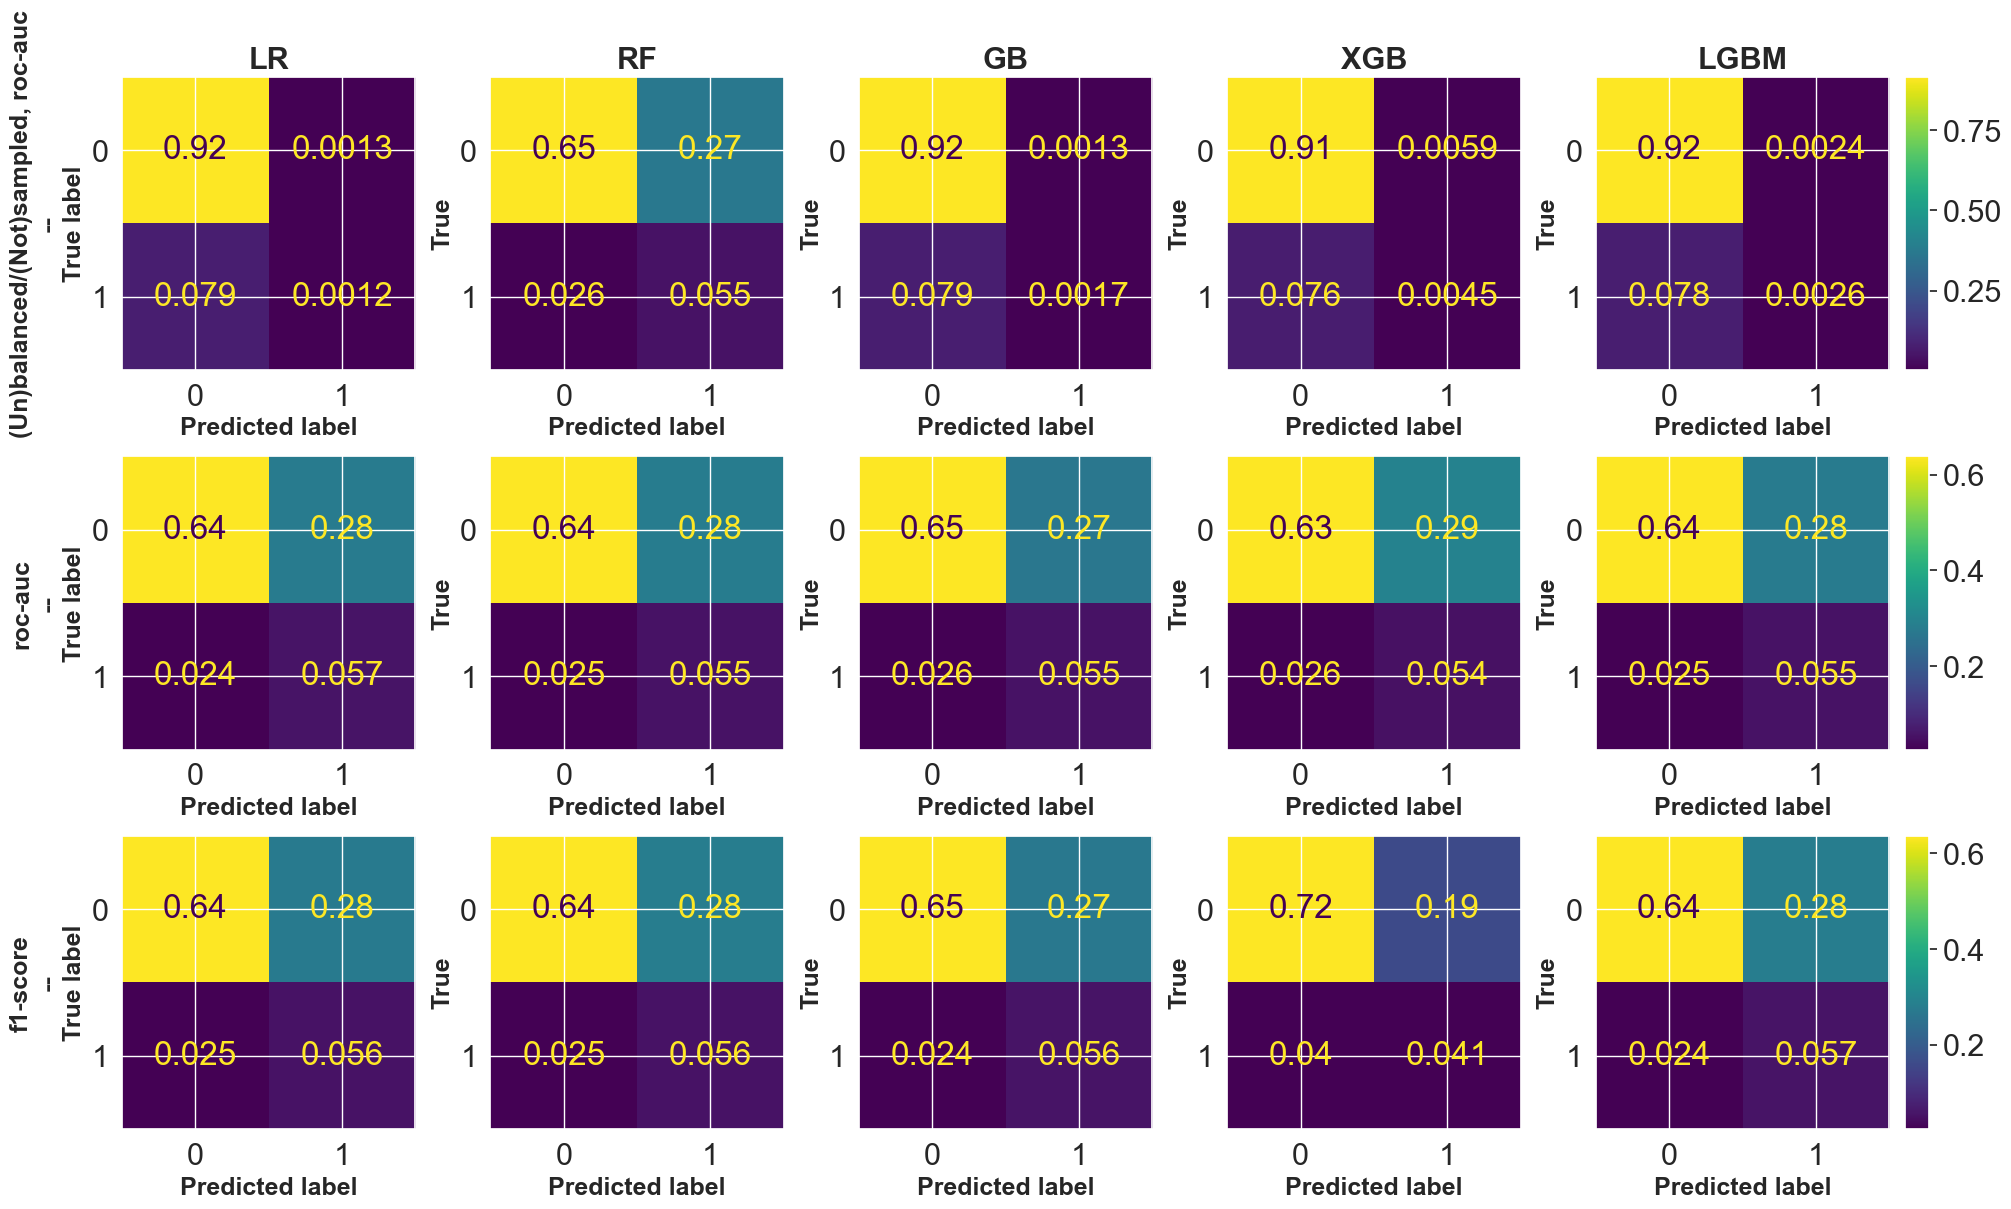

In [82]:
sns.set(font_scale=2.0)

fig, axes = plt.subplots(3, 5, figsize=(20, 12), constrained_layout=True)

g1 = ConfusionMatrixDisplay.from_estimator(grid_logireg.best_estimator_, X_sub_test, y_sub_test, normalize='all',
                                           colorbar=False, ax=axes[0][0])
g1.ax_.set_title('LR', fontsize=22, fontweight='bold')
g2 = ConfusionMatrixDisplay.from_estimator(grid_RFC.best_estimator_, X_sub_test, y_sub_test, normalize='all',
                                           colorbar=False, ax=axes[0][1])
g2.ax_.set_title('RF', fontsize=22, fontweight='bold')
g3 = ConfusionMatrixDisplay.from_estimator(grid_GBC.best_estimator_, X_sub_test, y_sub_test, normalize='all',
                                           colorbar=False, ax=axes[0][2])
g3.ax_.set_title('GB', fontsize=22, fontweight='bold')
g4 = ConfusionMatrixDisplay.from_estimator(grid_XGBC.best_estimator_, X_sub_test, y_sub_test, normalize='all',
                                           colorbar=False, ax=axes[0][3])
g4.ax_.set_title('XGB', fontsize=22, fontweight='bold')
g5 = ConfusionMatrixDisplay.from_estimator(grid_LGBM.best_estimator_, X_sub_test, y_sub_test, normalize='all',
                                           ax=axes[0][4])
g5.ax_.set_title('LGBM', fontsize=22, fontweight='bold')


g6 = ConfusionMatrixDisplay.from_estimator(grid_logireg2.best_estimator_, X_sub_test, y_sub_test, normalize='all',
                                           colorbar=False, ax=axes[1][0])
#g6.ax_.set_title('LR', fontsize=20, fontweight='bold')
g7 = ConfusionMatrixDisplay.from_estimator(grid_RFC2.best_estimator_, X_sub_test, y_sub_test, normalize='all',
                                           colorbar=False, ax=axes[1][1])
#g7.ax_.set_title('RF', fontsize=20, fontweight='bold')
g8 = ConfusionMatrixDisplay.from_estimator(grid_GBC2.best_estimator_, X_sub_test, y_sub_test, normalize='all',
                                           colorbar=False, ax=axes[1][2])
#g8.ax_.set_title('GB', fontsize=20, fontweight='bold')
g9 = ConfusionMatrixDisplay.from_estimator(grid_XGBC2.best_estimator_, X_sub_test, y_sub_test, normalize='all',
                                           colorbar=False, ax=axes[1][3])
#g9.ax_.set_title('XGB', fontsize=20, fontweight='bold')
g10 = ConfusionMatrixDisplay.from_estimator(grid_LGBM2.best_estimator_, X_sub_test, y_sub_test, normalize='all',
                                           ax=axes[1][4])
#g10.ax_.set_title('LGBM', fontsize=20, fontweight='bold')


g11 = ConfusionMatrixDisplay.from_estimator(grid_logireg3.best_estimator_, X_sub_test, y_sub_test, normalize='all',
                                           colorbar=False, ax=axes[2][0])
#g11.ax_.set_title('LR', fontsize=20, fontweight='bold')
g12 = ConfusionMatrixDisplay.from_estimator(grid_RFC3.best_estimator_, X_sub_test, y_sub_test, normalize='all',
                                           colorbar=False, ax=axes[2][1])
#g12.ax_.set_title('RF', fontsize=20, fontweight='bold')
g13 = ConfusionMatrixDisplay.from_estimator(grid_GBC3.best_estimator_, X_sub_test, y_sub_test, normalize='all',
                                           colorbar=False, ax=axes[2][2])
#g13.ax_.set_title('GB', fontsize=20, fontweight='bold')
g14 = ConfusionMatrixDisplay.from_estimator(grid_XGBC3.best_estimator_, X_sub_test, y_sub_test, normalize='all',
                                           colorbar=False, ax=axes[2][3])
#g14.ax_.set_title('XGB', fontsize=20, fontweight='bold')
g15 = ConfusionMatrixDisplay.from_estimator(grid_LGBM3.best_estimator_, X_sub_test, y_sub_test, normalize='all',
                                           ax=axes[2][4])
#g15.ax_.set_title('LGBM', fontsize=20, fontweight='bold')

for g in [g1, g2, g3, g4, g5, g6, g7, g8, g9, g10, g11, g12, g13, g14, g15]:
    g.ax_.set_ylabel('True', fontsize=18, fontweight='bold')
    g.ax_.set_xlabel('Predicted label', fontsize=18, fontweight='bold')

g1.ax_.set_ylabel('(Un)balanced/(Not)sampled, roc-auc\n--\nTrue label', fontsize=18, fontweight='bold')
g11.ax_.set_ylabel('f1-score\n--\nTrue label', fontsize=18, fontweight='bold')
g6.ax_.set_ylabel('roc-auc\n--\nTrue label', fontsize=18, fontweight='bold')

* **Plotting mean train/test scores/times depending on sampling method and scoring metric**

In [188]:
auc_SMOTE_model_list = []
auc_SMOTE_mean_train_score_list = []
auc_SMOTE_mean_train_time_list = []
auc_SMOTE_mean_test_score_list = []
auc_SMOTE_mean_test_time_list = []

auc_RUS_model_list = []
auc_RUS_mean_train_score_list = []
auc_RUS_mean_train_time_list = []
auc_RUS_mean_test_score_list = []
auc_RUS_mean_test_time_list = []

f1_SMOTE_model_list = []
f1_SMOTE_mean_train_score_list = []
f1_SMOTE_mean_train_time_list = []
f1_SMOTE_mean_test_score_list = []
f1_SMOTE_mean_test_time_list = []

f1_RUS_model_list = []
f1_RUS_mean_train_score_list = []
f1_RUS_mean_train_time_list = []
f1_RUS_mean_test_score_list = []
f1_RUS_mean_test_time_list = []

pr_SMOTE_model_list = []
pr_SMOTE_mean_train_score_list = []
pr_SMOTE_mean_train_time_list = []
pr_SMOTE_mean_test_score_list = []
pr_SMOTE_mean_test_time_list = []

pr_RUS_model_list = []
pr_RUS_mean_train_score_list = []
pr_RUS_mean_train_time_list = []
pr_RUS_mean_test_score_list = []
pr_RUS_mean_test_time_list = []

for grid in [grid_logireg2, grid_RFC2, grid_GBC2, grid_XGBC2, grid_LGBM2]: # auc
    result = pd.DataFrame(grid.cv_results_)
    # for SMOTE:
    print('SMOTE -- check:', result.param_sampler.unique().tolist()[0])
    SMOTEresult = result[result['param_sampler']==result.param_sampler.unique().tolist()[0]]
    bestSMOTEresult = SMOTEresult[SMOTEresult['rank_test_score']==np.min(SMOTEresult['rank_test_score'])]
    auc_SMOTE_model_list.append(str(bestSMOTEresult['param_classifier'])[:20])
    auc_SMOTE_mean_train_score_list.append(bestSMOTEresult['mean_train_score'][SMOTEresult['rank_test_score'].idxmin()])
    auc_SMOTE_mean_train_time_list.append(bestSMOTEresult['mean_fit_time'][SMOTEresult['rank_test_score'].idxmin()])
    auc_SMOTE_mean_test_score_list.append(bestSMOTEresult['mean_test_score'][SMOTEresult['rank_test_score'].idxmin()])
    auc_SMOTE_mean_test_time_list.append(bestSMOTEresult['mean_score_time'][SMOTEresult['rank_test_score'].idxmin()])
    
    # for RandomUnderSampling
    print('RandomUnderSampling -- check:', result.param_sampler.unique().tolist()[1])
    RUSresult = result[result['param_sampler']==result.param_sampler.unique().tolist()[1]]
    bestRUSresult = RUSresult[RUSresult['rank_test_score']==np.min(RUSresult['rank_test_score'])]
    auc_RUS_model_list.append(str(bestRUSresult['param_classifier'])[:20])
    auc_RUS_mean_train_score_list.append(bestRUSresult['mean_train_score'][RUSresult['rank_test_score'].idxmin()])
    auc_RUS_mean_train_time_list.append(bestRUSresult['mean_fit_time'][RUSresult['rank_test_score'].idxmin()])
    auc_RUS_mean_test_score_list.append(bestRUSresult['mean_test_score'][RUSresult['rank_test_score'].idxmin()])
    auc_RUS_mean_test_time_list.append(bestRUSresult['mean_score_time'][RUSresult['rank_test_score'].idxmin()])
    
for grid in [grid_logireg3, grid_RFC3, grid_GBC3, grid_XGBC3, grid_LGBM3]: # f1_score
    result = pd.DataFrame(grid.cv_results_)
    # for SMOTE:
    print('SMOTE -- check:', result.param_sampler.unique().tolist()[0])
    SMOTEresult = result[result['param_sampler']==result.param_sampler.unique().tolist()[0]]
    bestSMOTEresult = SMOTEresult[SMOTEresult['rank_test_score']==np.min(SMOTEresult['rank_test_score'])]
    f1_SMOTE_model_list.append(str(bestSMOTEresult['param_classifier'])[:20])
    f1_SMOTE_mean_train_score_list.append(bestSMOTEresult['mean_train_score'][SMOTEresult['rank_test_score'].idxmin()])
    f1_SMOTE_mean_train_time_list.append(bestSMOTEresult['mean_fit_time'][SMOTEresult['rank_test_score'].idxmin()])
    f1_SMOTE_mean_test_score_list.append(bestSMOTEresult['mean_test_score'][SMOTEresult['rank_test_score'].idxmin()])
    f1_SMOTE_mean_test_time_list.append(bestSMOTEresult['mean_score_time'][SMOTEresult['rank_test_score'].idxmin()])
    
    # for RandomUnderSampling
    print('RandomUnderSampling -- check:', result.param_sampler.unique().tolist()[1])
    RUSresult = result[result['param_sampler']==result.param_sampler.unique().tolist()[1]]
    bestRUSresult = RUSresult[RUSresult['rank_test_score']==np.min(RUSresult['rank_test_score'])]
    f1_RUS_model_list.append(str(bestRUSresult['param_classifier'])[:20])
    f1_RUS_mean_train_score_list.append(bestRUSresult['mean_train_score'][RUSresult['rank_test_score'].idxmin()])
    f1_RUS_mean_train_time_list.append(bestRUSresult['mean_fit_time'][RUSresult['rank_test_score'].idxmin()])
    f1_RUS_mean_test_score_list.append(bestRUSresult['mean_test_score'][RUSresult['rank_test_score'].idxmin()])
    f1_RUS_mean_test_time_list.append(bestRUSresult['mean_score_time'][RUSresult['rank_test_score'].idxmin()])

for grid in [grid_logireg4, grid_RFC4, grid_GBC4, grid_XGBC4, grid_LGBM4]: # pr (average precision)
    result = pd.DataFrame(grid.cv_results_)
    # for SMOTE:
    print('SMOTE -- check:', result.param_sampler.unique().tolist()[0])
    SMOTEresult = result[result['param_sampler']==result.param_sampler.unique().tolist()[0]]
    bestSMOTEresult = SMOTEresult[SMOTEresult['rank_test_score']==np.min(SMOTEresult['rank_test_score'])]
    pr_SMOTE_model_list.append(str(bestSMOTEresult['param_classifier'])[:20])
    pr_SMOTE_mean_train_score_list.append(bestSMOTEresult['mean_train_score'][SMOTEresult['rank_test_score'].idxmin()])
    pr_SMOTE_mean_train_time_list.append(bestSMOTEresult['mean_fit_time'][SMOTEresult['rank_test_score'].idxmin()])
    pr_SMOTE_mean_test_score_list.append(bestSMOTEresult['mean_test_score'][SMOTEresult['rank_test_score'].idxmin()])
    pr_SMOTE_mean_test_time_list.append(bestSMOTEresult['mean_score_time'][SMOTEresult['rank_test_score'].idxmin()])
    
    # for RandomUnderSampling
    print('RandomUnderSampling -- check:', result.param_sampler.unique().tolist()[1])
    RUSresult = result[result['param_sampler']==result.param_sampler.unique().tolist()[1]]
    bestRUSresult = RUSresult[RUSresult['rank_test_score']==np.min(RUSresult['rank_test_score'])]
    pr_RUS_model_list.append(str(bestRUSresult['param_classifier'])[:20])
    pr_RUS_mean_train_score_list.append(bestRUSresult['mean_train_score'][RUSresult['rank_test_score'].idxmin()])
    pr_RUS_mean_train_time_list.append(bestRUSresult['mean_fit_time'][RUSresult['rank_test_score'].idxmin()])
    pr_RUS_mean_test_score_list.append(bestRUSresult['mean_test_score'][RUSresult['rank_test_score'].idxmin()])
    pr_RUS_mean_test_time_list.append(bestRUSresult['mean_score_time'][RUSresult['rank_test_score'].idxmin()])

SMOTE -- check: SMOTE()
RandomUnderSampling -- check: RandomUnderSampler()
SMOTE -- check: SMOTE()
RandomUnderSampling -- check: RandomUnderSampler()
SMOTE -- check: SMOTE()
RandomUnderSampling -- check: RandomUnderSampler()
SMOTE -- check: SMOTE()
RandomUnderSampling -- check: RandomUnderSampler()
SMOTE -- check: SMOTE()
RandomUnderSampling -- check: RandomUnderSampler()
SMOTE -- check: SMOTE()
RandomUnderSampling -- check: RandomUnderSampler()
SMOTE -- check: SMOTE()
RandomUnderSampling -- check: RandomUnderSampler()
SMOTE -- check: SMOTE()
RandomUnderSampling -- check: RandomUnderSampler()
SMOTE -- check: SMOTE()
RandomUnderSampling -- check: RandomUnderSampler()
SMOTE -- check: SMOTE()
RandomUnderSampling -- check: RandomUnderSampler()
SMOTE -- check: SMOTE()
RandomUnderSampling -- check: RandomUnderSampler()
SMOTE -- check: SMOTE()
RandomUnderSampling -- check: RandomUnderSampler()
SMOTE -- check: SMOTE()
RandomUnderSampling -- check: RandomUnderSampler()
SMOTE -- check: SMOTE()
R

In [190]:
for list in [auc_SMOTE_model_list,auc_RUS_model_list,f1_SMOTE_model_list,f1_RUS_model_list,pr_SMOTE_model_list,pr_RUS_model_list]:
    print(list)

['0    LogisticRegress', '2    RandomForestCla', '0    GradientBoostin', '0    XGBClassifier(b', '0    LGBMClassifier(']
['1    LogisticRegress', '3    RandomForestCla', '1    GradientBoostin', '1    XGBClassifier(b', '3    LGBMClassifier(']
['0    LogisticRegress', '0    RandomForestCla', '0    GradientBoostin', '4    XGBClassifier(b', '0    LGBMClassifier(']
['1    LogisticRegress', '1    RandomForestCla', '1    GradientBoostin', '1    XGBClassifier(b', '3    LGBMClassifier(']
['0    LogisticRegress', '2    RandomForestCla', '0    GradientBoostin', '0    XGBClassifier(b', '0    LGBMClassifier(']
['1    LogisticRegress', '3    RandomForestCla', '1    GradientBoostin', '3    XGBClassifier(b', '3    LGBMClassifier(']


In [191]:
model_list_short

['LR', 'RF', 'GB', 'XGB', 'LGBM']

In [192]:
auc_SMOTE_dict = {'Model': model_list_short,
                  'mean_train_score': auc_SMOTE_mean_train_score_list,
                  'mean_train_time': auc_SMOTE_mean_train_time_list,
                  'mean_test_score': auc_SMOTE_mean_test_score_list,
                  'mean_test_time': auc_SMOTE_mean_test_time_list}

auc_RUS_dict = {'Model': model_list_short,
                'mean_train_score': auc_RUS_mean_train_score_list,
                'mean_train_time': auc_RUS_mean_train_time_list,
                'mean_test_score': auc_RUS_mean_test_score_list,
                'mean_test_time': auc_RUS_mean_test_time_list}

f1_SMOTE_dict = {'Model': model_list_short,
                 'mean_train_score': f1_SMOTE_mean_train_score_list,
                 'mean_train_time': f1_SMOTE_mean_train_time_list,
                 'mean_test_score': f1_SMOTE_mean_test_score_list,
                 'mean_test_time': f1_SMOTE_mean_test_time_list}

f1_RUS_dict = {'Model': model_list_short,
               'mean_train_score': f1_RUS_mean_train_score_list,
               'mean_train_time': f1_RUS_mean_train_time_list,
               'mean_test_score': f1_RUS_mean_test_score_list,
               'mean_test_time': f1_RUS_mean_test_time_list}

pr_SMOTE_dict = {'Model': model_list_short,
                 'mean_train_score': pr_SMOTE_mean_train_score_list,
                 'mean_train_time': pr_SMOTE_mean_train_time_list,
                 'mean_test_score': pr_SMOTE_mean_test_score_list,
                 'mean_test_time': pr_SMOTE_mean_test_time_list}

pr_RUS_dict = {'Model': model_list_short,
               'mean_train_score': pr_RUS_mean_train_score_list,
               'mean_train_time': pr_RUS_mean_train_time_list,
               'mean_test_score': pr_RUS_mean_test_score_list,
               'mean_test_time': pr_RUS_mean_test_time_list}

Text(0, 0.5, 'pr\n--\nRandomUnderSampling')

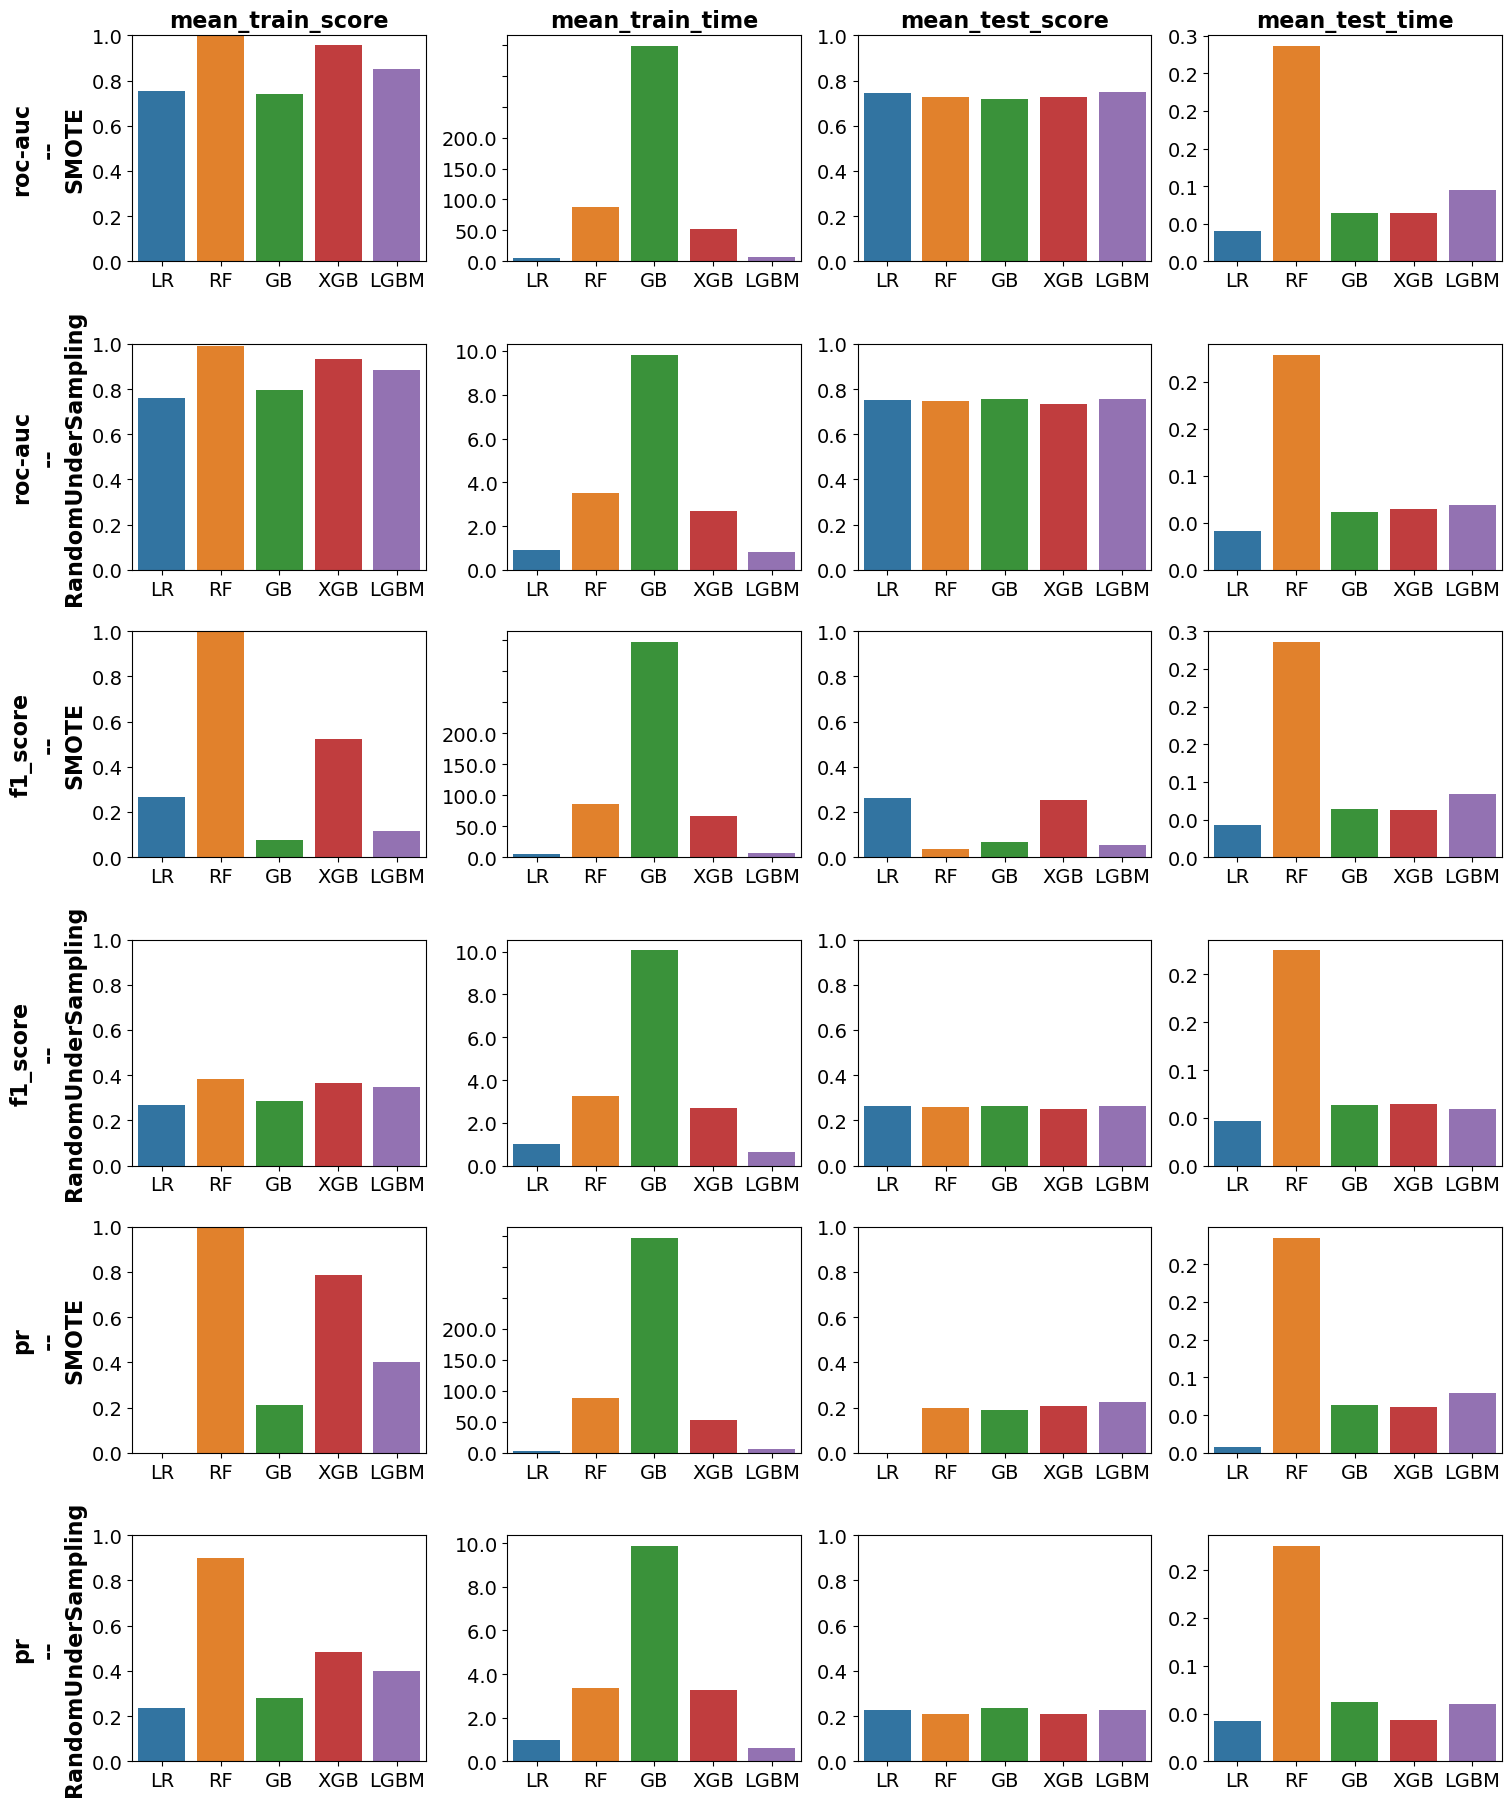

In [193]:
sns.reset_orig
plt.style.use('default')

fig, axes = plt.subplots(6, 4, figsize=(15, 18), constrained_layout=True)
g1 = sns.barplot(x='Model', y='mean_train_score', data=auc_SMOTE_dict, ax=axes[0][0])
g1.set_title('mean_train_score', fontsize=16, fontweight='bold')
g1.set_ylim(0,1)
g2 = sns.barplot(x='Model', y='mean_train_time', data=auc_SMOTE_dict, ax=axes[0][1])
g2.set_title('mean_train_time', fontsize=16, fontweight='bold')
g3 = sns.barplot(x='Model', y='mean_test_score', data=auc_SMOTE_dict, ax=axes[0][2])
g3.set_ylim(0,1)
g3.set_title('mean_test_score', fontsize=16, fontweight='bold')
g4 = sns.barplot(x='Model', y='mean_test_time', data=auc_SMOTE_dict, ax=axes[0][3])
g4.set_title('mean_test_time', fontsize=16, fontweight='bold')

g5 = sns.barplot(x='Model', y='mean_train_score', data=auc_RUS_dict, ax=axes[1][0])
g5.set_ylim(0,1)
g6 = sns.barplot(x='Model', y='mean_train_time', data=auc_RUS_dict, ax=axes[1][1])
g7 = sns.barplot(x='Model', y='mean_test_score', data=auc_RUS_dict, ax=axes[1][2])
g7.set_ylim(0,1)
g8 = sns.barplot(x='Model', y='mean_test_time', data=auc_RUS_dict, ax=axes[1][3])

g9 = sns.barplot(x='Model', y='mean_train_score', data=f1_SMOTE_dict, ax=axes[2][0])
g9.set_ylim(0,1)
g10 = sns.barplot(x='Model', y='mean_train_time', data=f1_SMOTE_dict, ax=axes[2][1])
g11 = sns.barplot(x='Model', y='mean_test_score', data=f1_SMOTE_dict, ax=axes[2][2])
g11.set_ylim(0,1)
g12 = sns.barplot(x='Model', y='mean_test_time', data=f1_SMOTE_dict, ax=axes[2][3])

g13 = sns.barplot(x='Model', y='mean_train_score', data=f1_RUS_dict, ax=axes[3][0])
g13.set_ylim(0,1)
g14 = sns.barplot(x='Model', y='mean_train_time', data=f1_RUS_dict, ax=axes[3][1])
g15 = sns.barplot(x='Model', y='mean_test_score', data=f1_RUS_dict, ax=axes[3][2])
g15.set_ylim(0,1)
g16 = sns.barplot(x='Model', y='mean_test_time', data=f1_RUS_dict, ax=axes[3][3])

g17 = sns.barplot(x='Model', y='mean_train_score', data=pr_SMOTE_dict, ax=axes[4][0])
g17.set_ylim(0,1)
g18 = sns.barplot(x='Model', y='mean_train_time', data=pr_SMOTE_dict, ax=axes[4][1])
g19 = sns.barplot(x='Model', y='mean_test_score', data=pr_SMOTE_dict, ax=axes[4][2])
g19.set_ylim(0,1)
g20 = sns.barplot(x='Model', y='mean_test_time', data=pr_SMOTE_dict, ax=axes[4][3])

g21 = sns.barplot(x='Model', y='mean_train_score', data=pr_RUS_dict, ax=axes[5][0])
g21.set_ylim(0,1)
g22 = sns.barplot(x='Model', y='mean_train_time', data=pr_RUS_dict, ax=axes[5][1])
g23 = sns.barplot(x='Model', y='mean_test_score', data=pr_RUS_dict, ax=axes[5][2])
g23.set_ylim(0,1)
g24 = sns.barplot(x='Model', y='mean_test_time', data=pr_RUS_dict, ax=axes[5][3])

for g in [g1, g2, g3, g4, g5, g6, g7, g8, g9, g10, g11, g12, g13, g14, g15, g16, g17, g18, g19, g20, g21, g22, g23, g24]:
    g.set_xticklabels(g.get_xticklabels(), fontsize=14)
    g.set_yticklabels([round(e,1) for e in g.get_yticks()], size = 14)

for g in [g1, g2, g3, g4, g5, g6, g7, g8, g9, g10, g11, g12, g13, g14, g15, g16, g17, g18, g19, g20, g21, g22, g23, g24]:
    g.set_ylabel('')
    g.set_xlabel('')

g1.set_ylabel('roc-auc\n--\nSMOTE', fontsize=16, fontweight='bold')
g5.set_ylabel('roc-auc\n--\nRandomUnderSampling', fontsize=16, fontweight='bold')
g9.set_ylabel('f1_score\n--\nSMOTE', fontsize=16, fontweight='bold')
g13.set_ylabel('f1_score\n--\nRandomUnderSampling', fontsize=16, fontweight='bold')
g17.set_ylabel('pr\n--\nSMOTE', fontsize=16, fontweight='bold')
g21.set_ylabel('pr\n--\nRandomUnderSampling', fontsize=16, fontweight='bold')

In [203]:
for dict_name, dict_result in {'auc_SMOTE': auc_SMOTE_dict,
                               'auc_RUS': auc_RUS_dict,
                             'f1_SMOTE': f1_SMOTE_dict,
                             'f1_RUS': f1_RUS_dict,
                             'pr_SMOTE': pr_SMOTE_dict,
                             'pr_RUS': pr_RUS_dict}.items():
    print(dict_name)
    display(HTML(pd.DataFrame(dict_result).sort_values('mean_test_score', ascending=False).to_html()))

auc_SMOTE


auc_RUS


f1_SMOTE


f1_RUS


pr_SMOTE


pr_RUS


## Summary / conclusion:
- performances sur jeu de validation (mean_test_time) équivalentes entre les modèles, même si LGBM ressort de manière constante (sauf pour f1_SMOTE) parmi les deux modèles les plus performants, contrairement aux autres modèles.
- RF apparait comme ayant tendance à overfitter sur les données d'entrainement (mean_train_score = 1)
- en termes de temps de calcul, LGBM offre les temps d'entrainement les plus faibles (là où GB apparait tres lent), et des temps de prédiction généralement équivalents (ou légèrement plus longs) à ceux des autres modèles (hormis RF qui apparait ici plus lent que les autres).

==> **modèle séléctionné = LGBM classifier**

* performances on validation set (mean_test_time) more or less equal between models, even if LGBM constantly (except for f1_SMOTE) scores higher (within top 2 scores), in contrast to other models.
* RF seems to tend to overfit on training data (mean_train_score = 1)
* in terms of running time, LGBM appears always faster to train (while GB is very long to train), and shows prediction times similar to (or slightly longer than) those of other models (except RF which takes longer than the others).

==> **selected model = LGBM classifier**

# Model optimization
## Sampling method(s) + hyperparameters tuning
* Strategy 1: using GridSearchCV --> far too long
* Strategy: GridSearchCV for sampling, optuna integration for LGBM (optuna.integration.lightgbm) for some hyperparam, other hyperparams using GridSearchCV/Optuna??? --> problem = optuna integration does not seem to handle pipeline...(would need to be further checked) + only tune SOME hyperparms, not all (or at least all that I wanted to tune).
* Srategy 3: using Optuna integration for sklearn

In [53]:
# Strategy 1: Using GridSearchCV ==> below run would have taken something like 10 hours
# and that would have been just for a first tuning step that would have needed to be refined and further refined after.
# interrupted and given up

pipe_opt = Pipeline([('scaler', non_bin_scaler),
                    ('oversampler', SMOTE()),
                    ('undersampler', RandomUnderSampler()),
                    ('classifier', LogisticRegression())])

param_grid_LGBM_opt = {'scaler': [non_bin_scaler],
                       'oversampler': [SMOTE(sampling_strategy=0.1),'passthrough'],  
#                       'oversampler__sampling_strategy' : [0.1],
                       'undersampler': [RandomUnderSampler()],
                       'classifier': [LGBMClassifier()],
                       'classifier__random_state ': [0],
                       'classifier__n_jobs': [-1],
                       'classifier__objective': ['binary'],
                       'classifier__is_unbalance': [True],
                       'classifier__metric': ['average_precision_score'],
                       'classifier__n_estimators': [100, 500, 1000],
                       'classifier__learning_rate': [0.01, 0.1, 0.3], # typical range 0.01-0.3
                       'classifier__max_depth': [3, 8, 12], # 3-12 range usually work well
                       'classifier__num_leaves': [20, 50, 100], # 20 - 3000, max = 2^max_depth 
                       #'classifier__colsample_bytree': [0.8, 0.9, 0.95],
                       #'classifier__subsample': [0.8, 0.9, 0.95],
                       'classifier__reg_alpha': [0.1, 1, 10], #0-100
                       'classifier__reg_lambda': [0.1, 1, 10] #0-100
                      }

grid_LGBM_opt = GridSearchCVProgressBar(pipe_opt,
                                        param_grid=param_grid_LGBM_opt,
                                        return_train_score=True,
                                        scoring="average_precision",
                                        cv=5, 
                                        verbose=1)

grid_LGBM_opt.fit(X_train, y_train)

best_model_index = grid_LGBM_opt.best_index_

print('###### For LGBM Classifier:')
print('-' * 20)
print('Best params are:\n', grid_LGBM_opt.best_params_)
print('-' * 20)
print('Corresponding mean scores and times are:')
print('Mean train score: {}'.format(grid_LGBM_opt.cv_results_['mean_train_score'][best_model_index]))
print('Mean test score: {}'.format(grid_LGBM_opt.cv_results_['mean_test_score'][best_model_index]))
print('Mean train time: {}'.format(grid_LGBM_opt.cv_results_['mean_fit_time'][best_model_index]))
print('Mean test time: {}'.format(grid_LGBM_opt.cv_results_['mean_score_time'][best_model_index]))

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Fitting 5 folds for each of 1458 candidates, totalling 7290 fits
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] 

[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown param

[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown param

[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown param

[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown param

[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown param

[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown param

KeyboardInterrupt: 

In [ ]:
# Strategy 2: Using Optuna integration ofr lgbm - given up before even tried

**With Optuna integration for sklearn**

In [59]:
import optuna
from optuna.distributions import IntUniformDistribution as IntUnifDistr
from optuna.distributions import UniformDistribution as UnifDistr
from optuna.distributions import LogUniformDistribution as LogUnifDistr
from optuna.distributions import CategoricalDistribution as CategDistr

from sklearn.model_selection import StratifiedKFold

### Sampling method

In [73]:
pipe_opt = Pipeline([('scaler', non_bin_scaler),
                    ('oversampler', SMOTE()),
                    ('undersampler', RandomUnderSampler()),
                    ('classifier', LGBMClassifier())])
# Note: imputer left out as LGBM appeared to score better without it

param_preproc_LGBM_opt = {'scaler': CategDistr([non_bin_scaler]),
                          'oversampler': CategDistr([SMOTE()]),
                          'oversampler__sampling_strategy': UnifDistr(0,0.5),
                          'undersampler': CategDistr([RandomUnderSampler()]),
                          'undersampler__sampling_strategy': UnifDistr(0.1, 0.9),
                          'classifier': CategDistr([LGBMClassifier()]),
                          'classifier__is_unbalance': CategDistr([True, False]),
                         'classifier__random_state ': CategDistr([0]),
                        'classifier__objective': CategDistr(['binary']),
                        'classifier__metric': CategDistr(['average_precision_score'])}

Opt_preproc_LGBM = optuna.integration.OptunaSearchCV(pipe_opt,
                                                     param_preproc_LGBM_opt,
                                                     cv=5, # For integer, if estimator is a classifier and y is either binary or multiclass, sklearn.model_selection.StratifiedKFold is used.
                                                     #enable_pruning=True,
                                                     n_trials=None,
                                                     random_state=1,
                                                     refit=True,
                                                     return_train_score=True,
                                                     scoring='average_precision',
                                                     timeout=1800, # =30minutes
                                                     verbose=2)

Opt_preproc_LGBM.fit(X_train, y_train)

<ipython-input-73-cd9d870f59d6>:58: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  Opt_preproc_LGBM = optuna.integration.OptunaSearchCV(pipe_opt,
[I 2021-11-25 12:18:26,017] A new study created in memory with name: no-name-9e8c8fb0-438d-4db3-af97-a953e547ba32
[I 2021-11-25 12:18:26,017] Searching the best hyperparameters using 215254 samples...
C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_

NotFittedError: All estimators failed to fit

In [79]:
# enable_pruning=True --> not possible here ('Estimator needs to support partial fit')

# It's apparently SMOTE which creates this ('All estimators failed to fit')... 
# ==> As it yielded less good perf during model selection as well as train_score = nan, it was removed.

# run with timeout = 30 minutes, interrupted before as best value reached before 20 trials, and n_trials fixed to 20 for next run

###################################

pipe_opt = Pipeline([('scaler', non_bin_scaler),
                    ('undersampler', RandomUnderSampler()),
                    ('classifier', LGBMClassifier())])
# Note: imputer left out as LGBM appeared to score better without it

param_preproc_LGBM_opt = {'undersampler__sampling_strategy': UnifDistr(0.1, 0.9),
                          'classifier__is_unbalance': CategDistr([True]),
                          'classifier__random_state ': CategDistr([0]),
                          'classifier__objective': CategDistr(['binary']),
                          'classifier__metric': CategDistr(['average_precision_score'])}
                      
Opt_preproc_LGBM = optuna.integration.OptunaSearchCV(pipe_opt,
                                                     param_preproc_LGBM_opt,
                                                     cv=5,
                                                     #enable_pruning=True,
                                                     n_trials=20,
                                                     random_state=1,
                                                     refit=True,
                                                     return_train_score=True,
                                                     scoring='average_precision',
                                                     #timeout=1800, # =30minutes
                                                     verbose=2)

Opt_preproc_LGBM.fit(X_train, y_train)

<ipython-input-79-f33149ba0f47>:55: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  Opt_preproc_LGBM = optuna.integration.OptunaSearchCV(pipe_opt,
[I 2021-11-25 12:38:45,048] A new study created in memory with name: no-name-43d18bc3-f050-4b6f-bad5-d3c6cef108b1
[I 2021-11-25 12:38:45,049] Searching the best hyperparameters using 215254 samples...


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 12:39:03,981] Trial 0 finished with value: 0.2551121642303843 and parameters: {'undersampler__sampling_strategy': 0.29164050192489155, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score'}. Best is trial 0 with value: 0.2551121642303843.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 12:39:19,307] Trial 1 finished with value: 0.25267883253204176 and parameters: {'undersampler__sampling_strategy': 0.641691577270905, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score'}. Best is trial 0 with value: 0.2551121642303843.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 12:39:34,137] Trial 2 finished with value: 0.25083971469983046 and parameters: {'undersampler__sampling_strategy': 0.859354735814835, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score'}. Best is trial 0 with value: 0.2551121642303843.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 12:39:50,932] Trial 3 finished with value: 0.25513956615368355 and parameters: {'undersampler__sampling_strategy': 0.4065689544080341, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score'}. Best is trial 3 with value: 0.25513956615368355.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 12:40:07,206] Trial 4 finished with value: 0.2516465041100691 and parameters: {'undersampler__sampling_strategy': 0.5625786406481749, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score'}. Best is trial 3 with value: 0.25513956615368355.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 12:40:30,242] Trial 5 finished with value: 0.2566131812526732 and parameters: {'undersampler__sampling_strategy': 0.172456159412575, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score'}. Best is trial 5 with value: 0.2566131812526732.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 12:40:45,605] Trial 6 finished with value: 0.2514047889072799 and parameters: {'undersampler__sampling_strategy': 0.7290108302643462, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score'}. Best is trial 5 with value: 0.2566131812526732.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 12:40:59,817] Trial 7 finished with value: 0.25770359729624176 and parameters: {'undersampler__sampling_strategy': 0.2842239827243052, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score'}. Best is trial 7 with value: 0.25770359729624176.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 12:41:12,630] Trial 8 finished with value: 0.25256951830416086 and parameters: {'undersampler__sampling_strategy': 0.48480748220097114, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score'}. Best is trial 7 with value: 0.25770359729624176.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 12:41:23,932] Trial 9 finished with value: 0.25147507039620753 and parameters: {'undersampler__sampling_strategy': 0.759990264099842, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score'}. Best is trial 7 with value: 0.25770359729624176.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 12:41:41,347] Trial 10 finished with value: 0.2563159274458385 and parameters: {'undersampler__sampling_strategy': 0.16935674245860088, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score'}. Best is trial 7 with value: 0.25770359729624176.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 12:42:01,441] Trial 11 finished with value: 0.2574432680983164 and parameters: {'undersampler__sampling_strategy': 0.1261958607711241, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score'}. Best is trial 7 with value: 0.25770359729624176.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 12:42:15,666] Trial 12 finished with value: 0.254892553760815 and parameters: {'undersampler__sampling_strategy': 0.3245923459622768, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score'}. Best is trial 7 with value: 0.25770359729624176.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 12:42:31,090] Trial 13 finished with value: 0.25631034725318663 and parameters: {'undersampler__sampling_strategy': 0.25120625042682027, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score'}. Best is trial 7 with value: 0.25770359729624176.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 12:42:53,240] Trial 14 finished with value: 0.2579768013986243 and parameters: {'undersampler__sampling_strategy': 0.10327168119140004, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score'}. Best is trial 14 with value: 0.2579768013986243.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 12:43:06,874] Trial 15 finished with value: 0.25506902526877606 and parameters: {'undersampler__sampling_strategy': 0.39245539281597064, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score'}. Best is trial 14 with value: 0.2579768013986243.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 12:43:28,085] Trial 16 finished with value: 0.2575012773482971 and parameters: {'undersampler__sampling_strategy': 0.1073587203018845, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score'}. Best is trial 14 with value: 0.2579768013986243.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 12:43:46,086] Trial 17 finished with value: 0.255604545175448 and parameters: {'undersampler__sampling_strategy': 0.23325855640636128, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score'}. Best is trial 14 with value: 0.2579768013986243.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 12:44:02,440] Trial 18 finished with value: 0.25485787331953685 and parameters: {'undersampler__sampling_strategy': 0.3634156074673955, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score'}. Best is trial 14 with value: 0.2579768013986243.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 12:44:17,784] Trial 19 finished with value: 0.25450381925227417 and parameters: {'undersampler__sampling_strategy': 0.49674976322328, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score'}. Best is trial 14 with value: 0.2579768013986243.
[I 2021-11-25 12:44:17,785] Finished hyperparemeter search!
[I 2021-11-25 12:44:17,787] Refitting the estimator using 215254 samples...


[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 12:44:23,830] Finished refitting! (elapsed time: 6.041 sec.)


OptunaSearchCV(estimator=Pipeline(steps=[('scaler',
                                          ColumnTransformer(remainder='passthrough',
                                                            transformers=[('standardscaler',
                                                                           StandardScaler(),
                                                                           [1,
                                                                            2,
                                                                            3,
                                                                            4,
                                                                            9,
                                                                            10,
                                                                            11,
                                                                            15,
                                          

In [80]:
Opt_preproc_LGBM.best_params_

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'undersampler__sampling_strategy': 0.10327168119140004,
 'classifier__is_unbalance': True,
 'classifier__random_state ': 0,
 'classifier__objective': 'binary',
 'classifier__metric': 'average_precision_score'}

### LGBM classifier hyperparameters

In [11]:
# enable_pruning=True --> not possible here ('Estimator needs to support partial fit')

# It's apparently SMOTE which creates this ('All estimators failed to fit')... 
# as it yielded less good perf during model selection, + train_score = nan, removing it here:

# without it, best value reached before 20 trials, so n_trials fixed here to 

########################################

pipe_opt = Pipeline([('scaler', non_bin_scaler),
                    ('undersampler', RandomUnderSampler()),
                    ('classifier', LGBMClassifier())])
# Note: imputer left out as LGBM appeared to score better without it

#param_grid_LGBM_opt = {'imputer': [SimpleImputer(missing_values=np.nan, strategy='median'), 'passthrough'],
#                        'scaler': [non_bin_scaler],
#                        'oversampler': [SMOTE(), 'passthrough'],
                        #'oversampler__sampling_strategy' : ['auto', 0.1, 0.3],
#                        'undersampler': [RandomUnderSampler(), 'passthrough'],
                        #'undersampler__sampling_strategy': ['auto', 0.5, 0.7],
#                        'classifier': [LGBMClassifier()],
#                        'classifier__random_state ': [0],
#                        'classifier__n_jobs': [-1],
#                        'classifier__objective': ['binary'],
#                        'classifier__is_unbalance': [True],
#                        'classifier__metric': ['average_precision_score'],
#                        'classifier__n_estimators': [100, 500, 1000, 5000],
#                        'classifier__learning_rate': [0.001, 0.01, 0.1, 0.3],
#                        'classifier__max_depth': [-1, 5, 8, 10, 12, 15],
#                        'classifier__num_leaves': [10, 20, 25, 30, 35, 40, 50],
#                        'classifier__colsample_bytree': [0.6, 0.8, 0.9, 0.95, 1],
#                        'classifier__subsample': [0.6, 0.8, 0.9, 0.95, 1],
#                        'classifier__reg_alpha': [0, 0.05, 0.1, 1, 10, 100],
#                        'classifier__reg_lambda': [0, 0.05, 0.1, 1, 10, 100]
#                       }

param_LGBM_opt = {'undersampler__sampling_strategy': CategDistr([0.10327]),
                  'classifier__is_unbalance': CategDistr([True]),
                  'classifier__random_state ': CategDistr([0]),
                  'classifier__objective': CategDistr(['binary']),
                  'classifier__metric': CategDistr(['average_precision_score']),
                  'classifier__n_estimators': IntUnifDistr(100, 1000),
                  'classifier__learning_rate': LogUnifDistr(0.01, 0.3), # typical range 0.01-0.3
                  'classifier__max_depth': IntUnifDistr(3,12), # 3-12 range usually work well
                  'classifier__num_leaves': IntUnifDistr(20, 1000), # 20 - 3000, max = 2^max_depth 
                  'classifier__colsample_bytree': UnifDistr(0.8, 1.0),
                  'classifier__subsample': UnifDistr(0.8, 1.0),
                  'classifier__reg_alpha': LogUnifDistr(0.001, 10), #0-100
                  'classifier__reg_lambda': LogUnifDistr(0.001, 10) #0-100
                 }
                    
#LGBM_study = optuna.create_study(direction='maximize')
                      
Opt_LGBM = optuna.integration.OptunaSearchCV(pipe_opt,
                                                     param_LGBM_opt,
                                                     cv=5, # StratifiedKFold is used.
                                                     #enable_pruning=True,
                                                     n_trials=None,
                                                     random_state=1,
                                                     refit=True,
                                                     return_train_score=True,
                                                     scoring='average_precision',
                                                     timeout=3600, # =1h
                                                     verbose=2)

Opt_LGBM.fit(X_train, y_train)

<ipython-input-11-49937dbe13c9>:56: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  Opt_LGBM = optuna.integration.OptunaSearchCV(pipe_opt,
[I 2021-11-25 13:06:08,505] A new study created in memory with name: no-name-0925e691-eece-46f7-a511-4ee5db4e2ca6
[I 2021-11-25 13:06:08,506] Searching the best hyperparameters using 215254 samples...


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 13:08:26,785] Trial 0 finished with value: 0.22095548459926792 and parameters: {'undersampler__sampling_strategy': 0.10327, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score', 'classifier__n_estimators': 315, 'classifier__learning_rate': 0.10004149609312378, 'classifier__max_depth': 12, 'classifier__num_leaves': 395, 'classifier__colsample_bytree': 0.9156446601620437, 'classifier__subsample': 0.8181140398531438, 'classifier__reg_alpha': 1.3965424823258972, 'classifier__reg_lambda': 0.00833911405211582}. Best is trial 0 with value: 0.22095548459926792.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 13:10:12,915] Trial 1 finished with value: 0.20702702540227227 and parameters: {'undersampler__sampling_strategy': 0.10327, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score', 'classifier__n_estimators': 533, 'classifier__learning_rate': 0.16542725323941856, 'classifier__max_depth': 12, 'classifier__num_leaves': 103, 'classifier__colsample_bytree': 0.9956593891087109, 'classifier__subsample': 0.8908330199030164, 'classifier__reg_alpha': 0.001903646410381976, 'classifier__reg_lambda': 0.17699177103315403}. Best is trial 0 with value: 0.22095548459926792.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 13:11:10,171] Trial 2 finished with value: 0.2533471592019858 and parameters: {'undersampler__sampling_strategy': 0.10327, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score', 'classifier__n_estimators': 291, 'classifier__learning_rate': 0.016347005045966055, 'classifier__max_depth': 6, 'classifier__num_leaves': 383, 'classifier__colsample_bytree': 0.8773090740864437, 'classifier__subsample': 0.8164076659226113, 'classifier__reg_alpha': 0.04663702172346503, 'classifier__reg_lambda': 0.21321567322985352}. Best is trial 2 with value: 0.2533471592019858.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 13:16:27,660] Trial 3 finished with value: 0.22194350336623253 and parameters: {'undersampler__sampling_strategy': 0.10327, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score', 'classifier__n_estimators': 930, 'classifier__learning_rate': 0.05751800890713706, 'classifier__max_depth': 10, 'classifier__num_leaves': 553, 'classifier__colsample_bytree': 0.8162717978870727, 'classifier__subsample': 0.8320153119672725, 'classifier__reg_alpha': 1.872695899129745, 'classifier__reg_lambda': 0.3841076800774362}. Best is trial 2 with value: 0.2533471592019858.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 13:23:39,271] Trial 4 finished with value: 0.23420964992904675 and parameters: {'undersampler__sampling_strategy': 0.10327, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score', 'classifier__n_estimators': 919, 'classifier__learning_rate': 0.04145077751470029, 'classifier__max_depth': 12, 'classifier__num_leaves': 346, 'classifier__colsample_bytree': 0.8947499031855678, 'classifier__subsample': 0.9126112439645893, 'classifier__reg_alpha': 0.5882758713392869, 'classifier__reg_lambda': 2.7729447515279935}. Best is trial 2 with value: 0.2533471592019858.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 13:26:01,061] Trial 5 finished with value: 0.2210226544369261 and parameters: {'undersampler__sampling_strategy': 0.10327, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score', 'classifier__n_estimators': 418, 'classifier__learning_rate': 0.209663511805036, 'classifier__max_depth': 9, 'classifier__num_leaves': 907, 'classifier__colsample_bytree': 0.8965848688611394, 'classifier__subsample': 0.9266687910095585, 'classifier__reg_alpha': 8.769223820448639, 'classifier__reg_lambda': 0.002240146586409395}. Best is trial 2 with value: 0.2533471592019858.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 13:29:15,728] Trial 6 finished with value: 0.24050905970390404 and parameters: {'undersampler__sampling_strategy': 0.10327, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score', 'classifier__n_estimators': 696, 'classifier__learning_rate': 0.02793121689515313, 'classifier__max_depth': 9, 'classifier__num_leaves': 276, 'classifier__colsample_bytree': 0.8763564892194625, 'classifier__subsample': 0.9287245199261053, 'classifier__reg_alpha': 1.1509392976062363, 'classifier__reg_lambda': 0.12308281215555696}. Best is trial 2 with value: 0.2533471592019858.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 13:30:17,312] Trial 7 finished with value: 0.24845432650688365 and parameters: {'undersampler__sampling_strategy': 0.10327, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score', 'classifier__n_estimators': 947, 'classifier__learning_rate': 0.2142565182617996, 'classifier__max_depth': 3, 'classifier__num_leaves': 247, 'classifier__colsample_bytree': 0.9066426101374239, 'classifier__subsample': 0.9755250854028802, 'classifier__reg_alpha': 0.09538147311202833, 'classifier__reg_lambda': 3.1597974141287746}. Best is trial 2 with value: 0.2533471592019858.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 13:33:31,635] Trial 8 finished with value: 0.21748434201866562 and parameters: {'undersampler__sampling_strategy': 0.10327, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score', 'classifier__n_estimators': 481, 'classifier__learning_rate': 0.2656452312607758, 'classifier__max_depth': 10, 'classifier__num_leaves': 523, 'classifier__colsample_bytree': 0.8689350745170736, 'classifier__subsample': 0.9354052980242917, 'classifier__reg_alpha': 0.11185310886007188, 'classifier__reg_lambda': 8.084588529165584}. Best is trial 2 with value: 0.2533471592019858.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 13:34:26,114] Trial 9 finished with value: 0.2565492964754165 and parameters: {'undersampler__sampling_strategy': 0.10327, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score', 'classifier__n_estimators': 693, 'classifier__learning_rate': 0.15815828643506796, 'classifier__max_depth': 3, 'classifier__num_leaves': 215, 'classifier__colsample_bytree': 0.8780594029021247, 'classifier__subsample': 0.9487329137816974, 'classifier__reg_alpha': 0.026221152259854986, 'classifier__reg_lambda': 2.0032111877080907}. Best is trial 9 with value: 0.2565492964754165.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 13:35:21,758] Trial 10 finished with value: 0.261201575014847 and parameters: {'undersampler__sampling_strategy': 0.10327, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score', 'classifier__n_estimators': 719, 'classifier__learning_rate': 0.09226575111050925, 'classifier__max_depth': 3, 'classifier__num_leaves': 733, 'classifier__colsample_bytree': 0.9592808346719955, 'classifier__subsample': 0.9949423630938781, 'classifier__reg_alpha': 0.004221680749385565, 'classifier__reg_lambda': 0.024913303073716107}. Best is trial 10 with value: 0.261201575014847.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 13:36:06,457] Trial 11 finished with value: 0.2614248733192861 and parameters: {'undersampler__sampling_strategy': 0.10327, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score', 'classifier__n_estimators': 699, 'classifier__learning_rate': 0.10304924251639325, 'classifier__max_depth': 3, 'classifier__num_leaves': 759, 'classifier__colsample_bytree': 0.9638284331283289, 'classifier__subsample': 0.9872302817492168, 'classifier__reg_alpha': 0.0029246645790280026, 'classifier__reg_lambda': 0.019800907585413294}. Best is trial 11 with value: 0.2614248733192861.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 13:37:26,676] Trial 12 finished with value: 0.24748812411904691 and parameters: {'undersampler__sampling_strategy': 0.10327, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score', 'classifier__n_estimators': 717, 'classifier__learning_rate': 0.0823064790839191, 'classifier__max_depth': 5, 'classifier__num_leaves': 772, 'classifier__colsample_bytree': 0.9736464905006671, 'classifier__subsample': 0.9927438805888261, 'classifier__reg_alpha': 0.0018411834512890941, 'classifier__reg_lambda': 0.01734113950966474}. Best is trial 11 with value: 0.2614248733192861.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 13:37:52,333] Trial 13 finished with value: 0.25672767622191894 and parameters: {'undersampler__sampling_strategy': 0.10327, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score', 'classifier__n_estimators': 124, 'classifier__learning_rate': 0.09853874169334627, 'classifier__max_depth': 5, 'classifier__num_leaves': 706, 'classifier__colsample_bytree': 0.9522204032910377, 'classifier__subsample': 0.9993008078126334, 'classifier__reg_alpha': 0.008946615758148152, 'classifier__reg_lambda': 0.02307574582775016}. Best is trial 11 with value: 0.2614248733192861.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 13:39:10,832] Trial 14 finished with value: 0.26017832460580814 and parameters: {'undersampler__sampling_strategy': 0.10327, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score', 'classifier__n_estimators': 793, 'classifier__learning_rate': 0.05530402338179335, 'classifier__max_depth': 4, 'classifier__num_leaves': 969, 'classifier__colsample_bytree': 0.9427068738097554, 'classifier__subsample': 0.8743956234774855, 'classifier__reg_alpha': 0.006766383173595279, 'classifier__reg_lambda': 0.0019394587026116419}. Best is trial 11 with value: 0.2614248733192861.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 13:41:14,301] Trial 15 finished with value: 0.25058995737220313 and parameters: {'undersampler__sampling_strategy': 0.10327, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score', 'classifier__n_estimators': 607, 'classifier__learning_rate': 0.0302765672889603, 'classifier__max_depth': 7, 'classifier__num_leaves': 696, 'classifier__colsample_bytree': 0.9966270112286848, 'classifier__subsample': 0.9690505502857948, 'classifier__reg_alpha': 0.0011022949960517647, 'classifier__reg_lambda': 0.041610571737821976}. Best is trial 11 with value: 0.2614248733192861.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 13:42:35,459] Trial 16 finished with value: 0.24821558587819287 and parameters: {'undersampler__sampling_strategy': 0.10327, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score', 'classifier__n_estimators': 835, 'classifier__learning_rate': 0.11902399982525383, 'classifier__max_depth': 4, 'classifier__num_leaves': 838, 'classifier__colsample_bytree': 0.9408584213756486, 'classifier__subsample': 0.9621871940597051, 'classifier__reg_alpha': 0.00796761878680579, 'classifier__reg_lambda': 0.005660318429690123}. Best is trial 11 with value: 0.2614248733192861.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 13:43:31,464] Trial 17 finished with value: 0.26244282503876215 and parameters: {'undersampler__sampling_strategy': 0.10327, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score', 'classifier__n_estimators': 607, 'classifier__learning_rate': 0.0619488153479441, 'classifier__max_depth': 3, 'classifier__num_leaves': 624, 'classifier__colsample_bytree': 0.9703401440008828, 'classifier__subsample': 0.859958337472677, 'classifier__reg_alpha': 0.005993333537868228, 'classifier__reg_lambda': 0.05278594782430441}. Best is trial 17 with value: 0.26244282503876215.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 13:45:24,296] Trial 18 finished with value: 0.2546707469774157 and parameters: {'undersampler__sampling_strategy': 0.10327, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score', 'classifier__n_estimators': 588, 'classifier__learning_rate': 0.016415286327421185, 'classifier__max_depth': 7, 'classifier__num_leaves': 613, 'classifier__colsample_bytree': 0.9745696996619994, 'classifier__subsample': 0.8537823704989356, 'classifier__reg_alpha': 0.021789268406233957, 'classifier__reg_lambda': 0.6671598496672981}. Best is trial 17 with value: 0.26244282503876215.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 13:46:19,994] Trial 19 finished with value: 0.2592737142823389 and parameters: {'undersampler__sampling_strategy': 0.10327, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score', 'classifier__n_estimators': 414, 'classifier__learning_rate': 0.03903974946585687, 'classifier__max_depth': 5, 'classifier__num_leaves': 619, 'classifier__colsample_bytree': 0.9250868379353359, 'classifier__subsample': 0.862061446191044, 'classifier__reg_alpha': 0.0028336415389914466, 'classifier__reg_lambda': 0.0657678142472542}. Best is trial 17 with value: 0.26244282503876215.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 13:47:47,781] Trial 20 finished with value: 0.25706744096171075 and parameters: {'undersampler__sampling_strategy': 0.10327, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score', 'classifier__n_estimators': 842, 'classifier__learning_rate': 0.010858835344684544, 'classifier__max_depth': 4, 'classifier__num_leaves': 463, 'classifier__colsample_bytree': 0.8390632952700684, 'classifier__subsample': 0.8900553567295217, 'classifier__reg_alpha': 0.01766273952207421, 'classifier__reg_lambda': 0.009997866016032654}. Best is trial 17 with value: 0.26244282503876215.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 13:48:46,006] Trial 21 finished with value: 0.2632509064195132 and parameters: {'undersampler__sampling_strategy': 0.10327, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score', 'classifier__n_estimators': 641, 'classifier__learning_rate': 0.07069796948201046, 'classifier__max_depth': 3, 'classifier__num_leaves': 811, 'classifier__colsample_bytree': 0.9689378601160874, 'classifier__subsample': 0.9883532202220029, 'classifier__reg_alpha': 0.0041598550604773155, 'classifier__reg_lambda': 0.04095534909282651}. Best is trial 21 with value: 0.2632509064195132.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 13:49:39,462] Trial 22 finished with value: 0.26246363552441576 and parameters: {'undersampler__sampling_strategy': 0.10327, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score', 'classifier__n_estimators': 626, 'classifier__learning_rate': 0.07039201022280302, 'classifier__max_depth': 3, 'classifier__num_leaves': 843, 'classifier__colsample_bytree': 0.9736980854140438, 'classifier__subsample': 0.836552256136356, 'classifier__reg_alpha': 0.0010131232644966222, 'classifier__reg_lambda': 0.05445665806764637}. Best is trial 21 with value: 0.2632509064195132.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 13:50:40,417] Trial 23 finished with value: 0.25908613222653 and parameters: {'undersampler__sampling_strategy': 0.10327, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score', 'classifier__n_estimators': 599, 'classifier__learning_rate': 0.06563581535267103, 'classifier__max_depth': 4, 'classifier__num_leaves': 880, 'classifier__colsample_bytree': 0.9790250222271377, 'classifier__subsample': 0.8424799557947973, 'classifier__reg_alpha': 0.0010198934430053572, 'classifier__reg_lambda': 0.052683833792506574}. Best is trial 21 with value: 0.2632509064195132.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 13:51:50,166] Trial 24 finished with value: 0.2537356523858692 and parameters: {'undersampler__sampling_strategy': 0.10327, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score', 'classifier__n_estimators': 487, 'classifier__learning_rate': 0.04095076073782851, 'classifier__max_depth': 6, 'classifier__num_leaves': 989, 'classifier__colsample_bytree': 0.9295200123967347, 'classifier__subsample': 0.800458003814912, 'classifier__reg_alpha': 0.0061071569081517455, 'classifier__reg_lambda': 0.08084543786241889}. Best is trial 21 with value: 0.2632509064195132.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 13:52:32,437] Trial 25 finished with value: 0.2632358231048767 and parameters: {'undersampler__sampling_strategy': 0.10327, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score', 'classifier__n_estimators': 633, 'classifier__learning_rate': 0.07065768127158652, 'classifier__max_depth': 3, 'classifier__num_leaves': 817, 'classifier__colsample_bytree': 0.9840806888241337, 'classifier__subsample': 0.8741148766704098, 'classifier__reg_alpha': 0.014743308809805029, 'classifier__reg_lambda': 0.5622420086939016}. Best is trial 21 with value: 0.2632509064195132.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 13:54:20,863] Trial 26 finished with value: 0.24069957097399475 and parameters: {'undersampler__sampling_strategy': 0.10327, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score', 'classifier__n_estimators': 774, 'classifier__learning_rate': 0.07294051280485297, 'classifier__max_depth': 6, 'classifier__num_leaves': 853, 'classifier__colsample_bytree': 0.9973334209466158, 'classifier__subsample': 0.8777204942655515, 'classifier__reg_alpha': 0.014459350796744196, 'classifier__reg_lambda': 0.7317703020454589}. Best is trial 21 with value: 0.2632509064195132.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 13:55:23,887] Trial 27 finished with value: 0.2500482844751427 and parameters: {'undersampler__sampling_strategy': 0.10327, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score', 'classifier__n_estimators': 643, 'classifier__learning_rate': 0.13243921628844296, 'classifier__max_depth': 4, 'classifier__num_leaves': 937, 'classifier__colsample_bytree': 0.9829013788162324, 'classifier__subsample': 0.911984359223581, 'classifier__reg_alpha': 0.05905869561177111, 'classifier__reg_lambda': 0.37642791156544525}. Best is trial 21 with value: 0.2632509064195132.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 13:56:29,720] Trial 28 finished with value: 0.2579346965443885 and parameters: {'undersampler__sampling_strategy': 0.10327, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score', 'classifier__n_estimators': 521, 'classifier__learning_rate': 0.04725946222133588, 'classifier__max_depth': 5, 'classifier__num_leaves': 816, 'classifier__colsample_bytree': 0.9480200651088178, 'classifier__subsample': 0.8387740480013656, 'classifier__reg_alpha': 0.1515571898801705, 'classifier__reg_lambda': 1.2349588449053654}. Best is trial 21 with value: 0.2632509064195132.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 13:57:00,925] Trial 29 finished with value: 0.25228024446275155 and parameters: {'undersampler__sampling_strategy': 0.10327, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score', 'classifier__n_estimators': 302, 'classifier__learning_rate': 0.02887051451022808, 'classifier__max_depth': 3, 'classifier__num_leaves': 675, 'classifier__colsample_bytree': 0.9294889828630959, 'classifier__subsample': 0.825512313964415, 'classifier__reg_alpha': 0.27457369758749656, 'classifier__reg_lambda': 0.006820309021791819}. Best is trial 21 with value: 0.2632509064195132.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 13:57:37,161] Trial 30 finished with value: 0.2593861865369829 and parameters: {'undersampler__sampling_strategy': 0.10327, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score', 'classifier__n_estimators': 411, 'classifier__learning_rate': 0.08037457825054432, 'classifier__max_depth': 4, 'classifier__num_leaves': 784, 'classifier__colsample_bytree': 0.9610377033461935, 'classifier__subsample': 0.802259596530463, 'classifier__reg_alpha': 0.0023620069797754234, 'classifier__reg_lambda': 0.2886033528464642}. Best is trial 21 with value: 0.2632509064195132.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 13:58:23,536] Trial 31 finished with value: 0.26290381748189595 and parameters: {'undersampler__sampling_strategy': 0.10327, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score', 'classifier__n_estimators': 637, 'classifier__learning_rate': 0.06444466411746083, 'classifier__max_depth': 3, 'classifier__num_leaves': 619, 'classifier__colsample_bytree': 0.9836632888793456, 'classifier__subsample': 0.8582228404333714, 'classifier__reg_alpha': 0.004039812692431878, 'classifier__reg_lambda': 0.13937074414196193}. Best is trial 21 with value: 0.2632509064195132.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 13:59:23,305] Trial 32 finished with value: 0.2623662800532924 and parameters: {'undersampler__sampling_strategy': 0.10327, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score', 'classifier__n_estimators': 662, 'classifier__learning_rate': 0.04986146460652541, 'classifier__max_depth': 3, 'classifier__num_leaves': 461, 'classifier__colsample_bytree': 0.9865563556040885, 'classifier__subsample': 0.8719472436393597, 'classifier__reg_alpha': 0.0037543080746163743, 'classifier__reg_lambda': 0.15555775421953086}. Best is trial 21 with value: 0.2632509064195132.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 14:00:21,653] Trial 33 finished with value: 0.2595733497428639 and parameters: {'undersampler__sampling_strategy': 0.10327, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score', 'classifier__n_estimators': 548, 'classifier__learning_rate': 0.07056854617110296, 'classifier__max_depth': 4, 'classifier__num_leaves': 893, 'classifier__colsample_bytree': 0.9863225828466823, 'classifier__subsample': 0.8466739843925637, 'classifier__reg_alpha': 0.0018142371873766617, 'classifier__reg_lambda': 0.113677352781869}. Best is trial 21 with value: 0.2632509064195132.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 14:01:53,560] Trial 34 finished with value: 0.24133767425425184 and parameters: {'undersampler__sampling_strategy': 0.10327, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score', 'classifier__n_estimators': 768, 'classifier__learning_rate': 0.10593264382937682, 'classifier__max_depth': 5, 'classifier__num_leaves': 577, 'classifier__colsample_bytree': 0.9896758411247248, 'classifier__subsample': 0.8909424666715255, 'classifier__reg_alpha': 0.01204317969745726, 'classifier__reg_lambda': 0.6926726848870141}. Best is trial 21 with value: 0.2632509064195132.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 14:02:48,570] Trial 35 finished with value: 0.26233105546886126 and parameters: {'undersampler__sampling_strategy': 0.10327, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score', 'classifier__n_estimators': 650, 'classifier__learning_rate': 0.08161788877665731, 'classifier__max_depth': 3, 'classifier__num_leaves': 673, 'classifier__colsample_bytree': 0.9993845504725776, 'classifier__subsample': 0.8134813723532794, 'classifier__reg_alpha': 0.028577138797323695, 'classifier__reg_lambda': 0.24899109038132028}. Best is trial 21 with value: 0.2632509064195132.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 14:03:42,996] Trial 36 finished with value: 0.26030411812714815 and parameters: {'undersampler__sampling_strategy': 0.10327, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score', 'classifier__n_estimators': 476, 'classifier__learning_rate': 0.03388231814354058, 'classifier__max_depth': 4, 'classifier__num_leaves': 815, 'classifier__colsample_bytree': 0.9640473872161066, 'classifier__subsample': 0.9019071487366602, 'classifier__reg_alpha': 0.0013688453727648236, 'classifier__reg_lambda': 0.039486568784063}. Best is trial 21 with value: 0.2632509064195132.


[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0
[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 14:10:53,127] Trial 37 finished with value: 0.2215701321670429 and parameters: {'undersampler__sampling_strategy': 0.10327, 'classifier__is_unbalance': True, 'classifier__random_state ': 0, 'classifier__objective': 'binary', 'classifier__metric': 'average_precision_score', 'classifier__n_estimators': 875, 'classifier__learning_rate': 0.1375871258788579, 'classifier__max_depth': 11, 'classifier__num_leaves': 945, 'classifier__colsample_bytree': 0.9140466574542898, 'classifier__subsample': 0.827660068295902, 'classifier__reg_alpha': 0.003921735029892487, 'classifier__reg_lambda': 0.16607989783485883}. Best is trial 21 with value: 0.2632509064195132.
[I 2021-11-25 14:10:53,135] Finished hyperparemeter search!
[I 2021-11-25 14:10:53,137] Refitting the estimator using 215254 samples...


[LightGBM] [Warning] Unknown parameter: 0


[I 2021-11-25 14:11:04,144] Finished refitting! (elapsed time: 11.005 sec.)


OptunaSearchCV(estimator=Pipeline(steps=[('scaler',
                                          ColumnTransformer(remainder='passthrough',
                                                            transformers=[('standardscaler',
                                                                           StandardScaler(),
                                                                           [1,
                                                                            2,
                                                                            3,
                                                                            4,
                                                                            9,
                                                                            10,
                                                                            11,
                                                                            15,
                                          

In [12]:
Opt_LGBM.best_params_

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'undersampler__sampling_strategy': 0.10327,
 'classifier__is_unbalance': True,
 'classifier__random_state ': 0,
 'classifier__objective': 'binary',
 'classifier__metric': 'average_precision_score',
 'classifier__n_estimators': 641,
 'classifier__learning_rate': 0.07069796948201046,
 'classifier__max_depth': 3,
 'classifier__num_leaves': 811,
 'classifier__colsample_bytree': 0.9689378601160874,
 'classifier__subsample': 0.9883532202220029,
 'classifier__reg_alpha': 0.0041598550604773155,
 'classifier__reg_lambda': 0.04095534909282651}

In [13]:
best_LGBM = Opt_LGBM.best_estimator_

### LGBM tuning visualizations

In [22]:
trials = Opt_LGBM.trials_dataframe()

In [39]:
trials.columns

Index(['number', 'value', 'datetime_start', 'datetime_complete', 'duration',
       'params_classifier__colsample_bytree',
       'params_classifier__is_unbalance', 'params_classifier__learning_rate',
       'params_classifier__max_depth', 'params_classifier__metric',
       'params_classifier__n_estimators', 'params_classifier__num_leaves',
       'params_classifier__objective', 'params_classifier__random_state ',
       'params_classifier__reg_alpha', 'params_classifier__reg_lambda',
       'params_classifier__subsample',
       'params_undersampler__sampling_strategy', 'user_attrs_mean_fit_time',
       'user_attrs_mean_score_time', 'user_attrs_mean_test_score',
       'user_attrs_mean_train_score', 'user_attrs_split0_test_score',
       'user_attrs_split0_train_score', 'user_attrs_split1_test_score',
       'user_attrs_split1_train_score', 'user_attrs_split2_test_score',
       'user_attrs_split2_train_score', 'user_attrs_split3_test_score',
       'user_attrs_split3_train_score', 

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'mean test time')

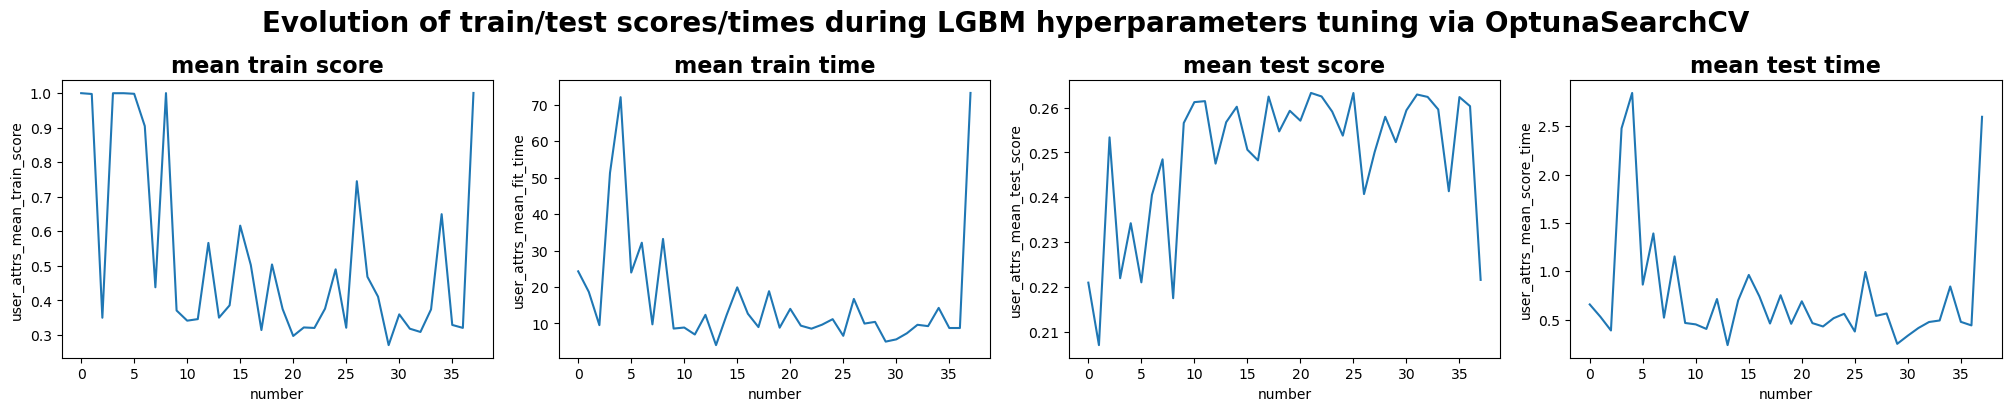

In [33]:
sns.reset_orig
plt.style.use('default')

fig, axes = plt.subplots(1, 4, figsize=(20, 4), constrained_layout=True)
fig.suptitle('Evolution of train/test scores/times during LGBM hyperparameters tuning via OptunaSearchCV', fontsize=20, fontweight='bold')
g1 = sns.lineplot(x='number', y='user_attrs_mean_train_score', data=trials, ax=axes[0])
g1.set_title('mean train score', fontsize=16, fontweight='bold')
g2 = sns.lineplot(x='number', y='user_attrs_mean_fit_time', data=trials, ax=axes[1])
g2.set_title('mean train time', fontsize=16, fontweight='bold')
g3 = sns.lineplot(x='number', y='user_attrs_mean_test_score', data=trials, ax=axes[2])
# For ref: best pr score for RUS LGBM at the end of model selection = 0.228946
g3.set_title('mean test score', fontsize=16, fontweight='bold')
g4 = sns.lineplot(x='number', y='user_attrs_mean_score_time', data=trials, ax=axes[3])
g4.set_title('mean test time', fontsize=16, fontweight='bold')

#for g in [g1, g2, g3, g4]:
#    g.set_xticklabels(g.get_xticklabels(), fontsize=14)
#    g.set_yticklabels([round(e,1) for e in g.get_yticks()], size = 14)

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


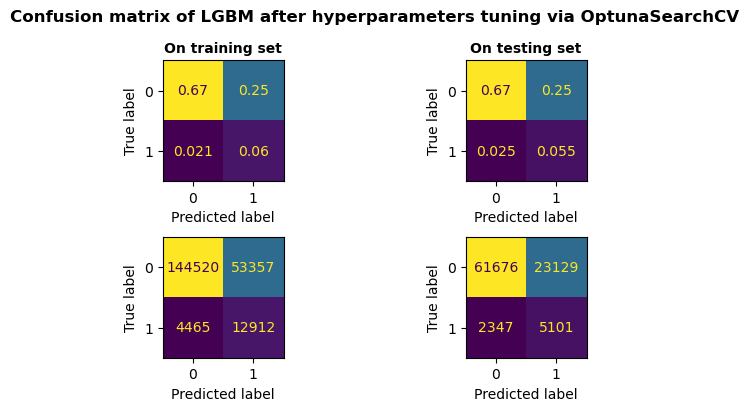

In [41]:
# plotting confusion matrix after hyperparam tuning
fig, axes = plt.subplots(2, 2, figsize=(6, 4), constrained_layout=True)
fig.suptitle('Confusion matrix of LGBM after hyperparameters tuning via OptunaSearchCV', fontsize=12, fontweight='bold')
g1 = ConfusionMatrixDisplay.from_estimator(best_LGBM, X_train, y_train, colorbar=False, normalize='all', ax=axes[0][0])
g1.ax_.set_title('On training set', fontsize=10, fontweight='bold')
g2 = ConfusionMatrixDisplay.from_estimator(best_LGBM, X_test, y_test, colorbar=False, normalize='all', ax=axes[0][1])
g2.ax_.set_title('On testing set', fontsize=10, fontweight='bold')
g3 = ConfusionMatrixDisplay.from_estimator(best_LGBM, X_train, y_train, colorbar=False, ax=axes[1][0])
g4 = ConfusionMatrixDisplay.from_estimator(best_LGBM, X_test, y_test, colorbar=False, ax=axes[1][1])

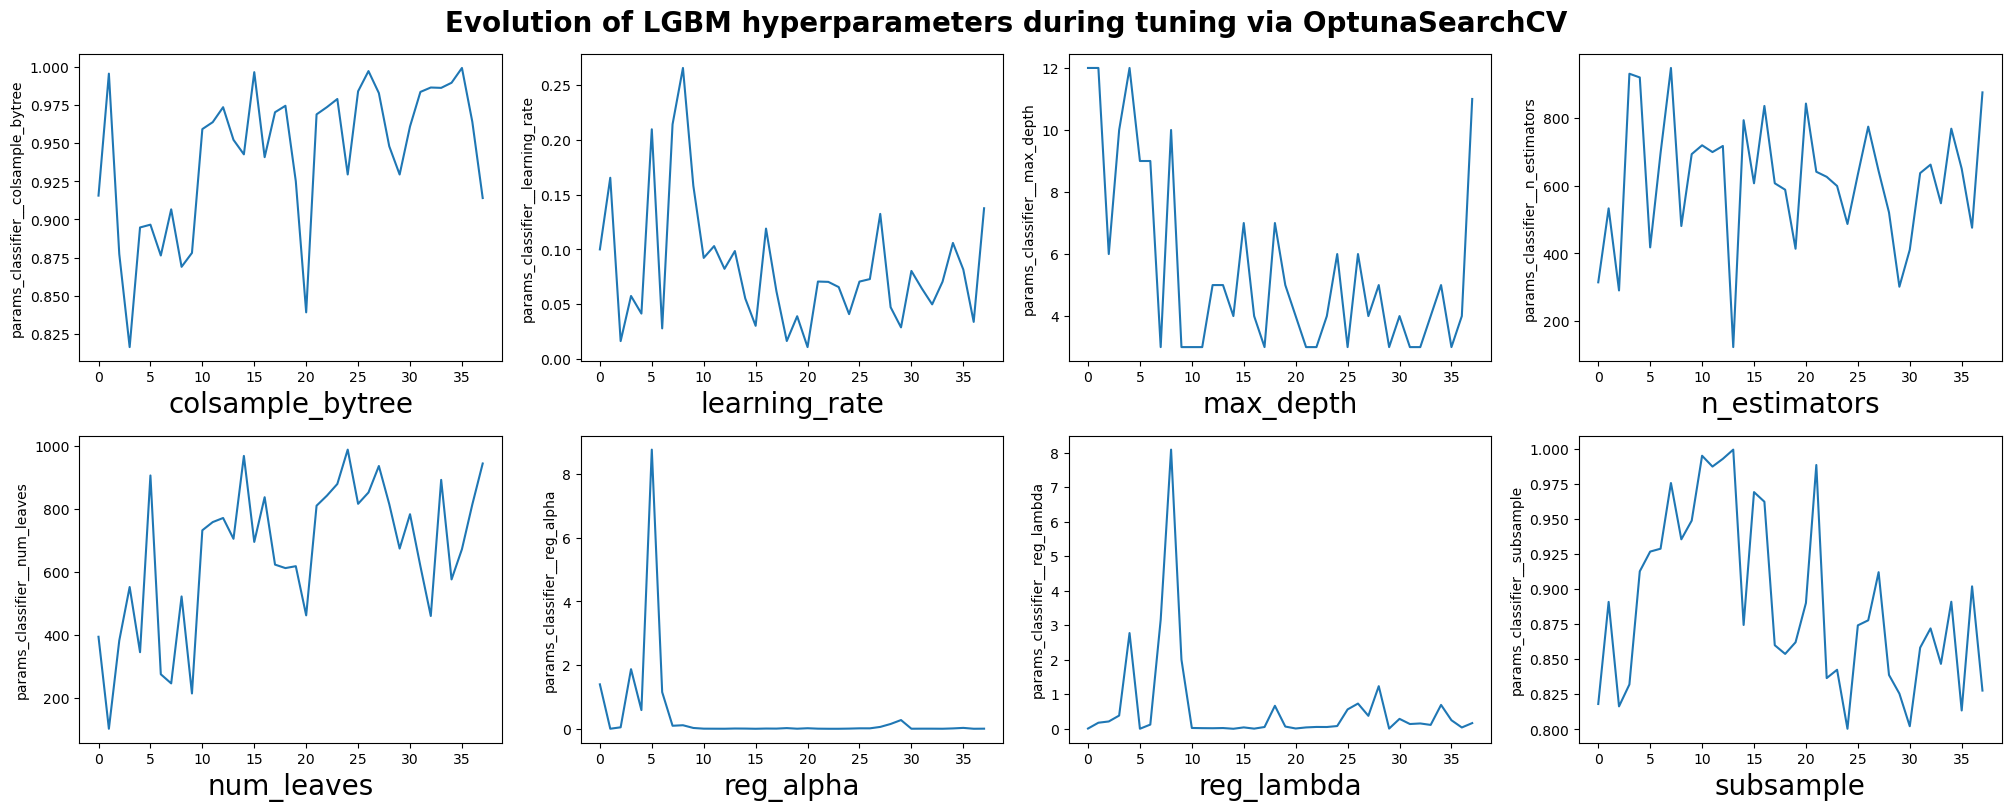

In [58]:
from textwrap import wrap

hyperparams = ['params_classifier__colsample_bytree',
               'params_classifier__learning_rate',
               'params_classifier__max_depth', 
               'params_classifier__n_estimators',
               'params_classifier__num_leaves',
               'params_classifier__reg_alpha',
               'params_classifier__reg_lambda',
               'params_classifier__subsample']

#g1 = sns.scatterplot(x='number', y='user_attrs_mean_test_score', data=trials, ax=axes[0])
#g1.set_title('mean train score', fontsize=16, fontweight='bold')


num_plots = len(hyperparams)
total_cols = 4
total_rows = 2 #num_plots//total_cols + 1
fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols,
                        figsize=(5*total_cols, 4*total_rows), constrained_layout=True)
fig.suptitle('Evolution of LGBM hyperparameters during tuning via OptunaSearchCV', fontsize=20, fontweight='bold')

for i, var in enumerate(hyperparams):
    row = i//total_cols
    pos = i % total_cols
    plot = sns.lineplot(x='number', y=var, data=trials, ax=axs[row][pos])
    plot.set_xlabel('\n'.join(wrap(var, 20)), fontsize=20)
    plot.set_xlabel((str(var)[19:]), fontsize=20)

In [51]:
#import plotly
#optuna.visualization.plot_intermediate_values(Opt_LGBM.study)

# 'No module named 'plotly'' issue not solved yet: https://github.com/optuna/optuna/issues/1339

In [52]:
# To visualize which hyperparam are the most important: 
#optuna.visualization.plot_param_importances(Opt_LGBM.study_)

# same issue not solved yet

In [59]:
best_LGBM.get_params(deep=True)

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'memory': None,
 'steps': [('scaler',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('standardscaler', StandardScaler(),
                                    [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                     21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                     49, 50, 51, 57, 58, 59, ...])])),
  ('undersampler', RandomUnderSampler(sampling_strategy=0.10327)),
  ('classifier',
   LGBMClassifier(colsample_bytree=0.9689378601160874, is_unbalance=True,
                  learning_rate=0.07069796948201046, max_depth=3,
                  metric='average_precision_score', n_estimators=641,
                  num_leaves=811, objective='binary', random_state =0,
                  reg_alpha=0.0041598550604773155, reg_lambda=0.04095534909282651,
                  subsample=0.9883532202220029))],
 'verbose': False,
 'scaler': ColumnTransformer(remainder='passthrough',
                   transformers=[('

In [138]:
# exporting best model
import joblib
joblib.dump(Opt_LGBM.best_estimator_, 'Best_model.pkl')

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['Best_model.pkl']

## Threshold 
### Threshold moving

In [60]:
# predicting proba using optimised model
y_pred_proba = best_LGBM.predict_proba(X_test)

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [67]:
# y_pred_proba has a (n_samples, 2) shape as [:,0] = proba for negative/majority class, [:,1] = proba for positive/minority class
y_pred_proba

array([[0.21497477, 0.78502523],
       [0.6895931 , 0.3104069 ],
       [0.50262314, 0.49737686],
       ...,
       [0.54345877, 0.45654123],
       [0.52934776, 0.47065224],
       [0.70090299, 0.29909701]])

In [69]:
print(y_pred_proba[:,1].min())
print(y_pred_proba[:,1].max())

0.010050451469115365
0.9793290799893779


In [70]:
# keeping proba for the positive class only
y_pred_proba_pos = y_pred_proba[:,1]

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [100]:
# calculating pr-curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_pos)

In [101]:
def nb_nan(array):
    count = 0
    for i in array:
        if np.isnan(i) == True:
            count += 1
    return count

print(nb_nan(precision), precision.shape)
print(nb_nan(recall), recall.shape)
print(nb_nan(thresholds), thresholds.shape)

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0 (92208,)
0 (92208,)
0 (92207,)


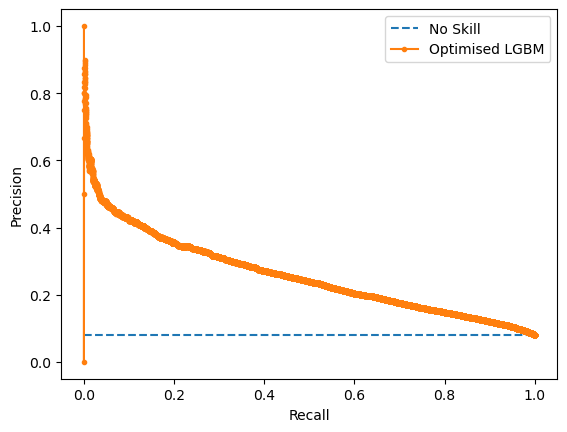

In [89]:
# plot the precision recall curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Optimised LGBM')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

==> Use of f-beta score to find the best threshold (we are looking for a model that predicts the smallest amount of false negatives as possible, i.e. a recall closer to 1 than to 0 --> with f-beta, recall is considered β times as important as precision --> maximising fbeta = finding the best compromise between having good positive predictions and even better negative predictions)
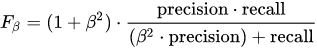

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-137-32fc850699de>:11: RuntimeWarning: invalid value encountered in true_divide
  fbeta_score = (1 + (beta * beta)) * ((precision * recall) / ((beta * beta * precision) + recall))
C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
<ipython-input-137-32fc850699de>:11: RuntimeWarning: invalid value encountered in true_divide
  fbeta_score = (1 + (beta * b

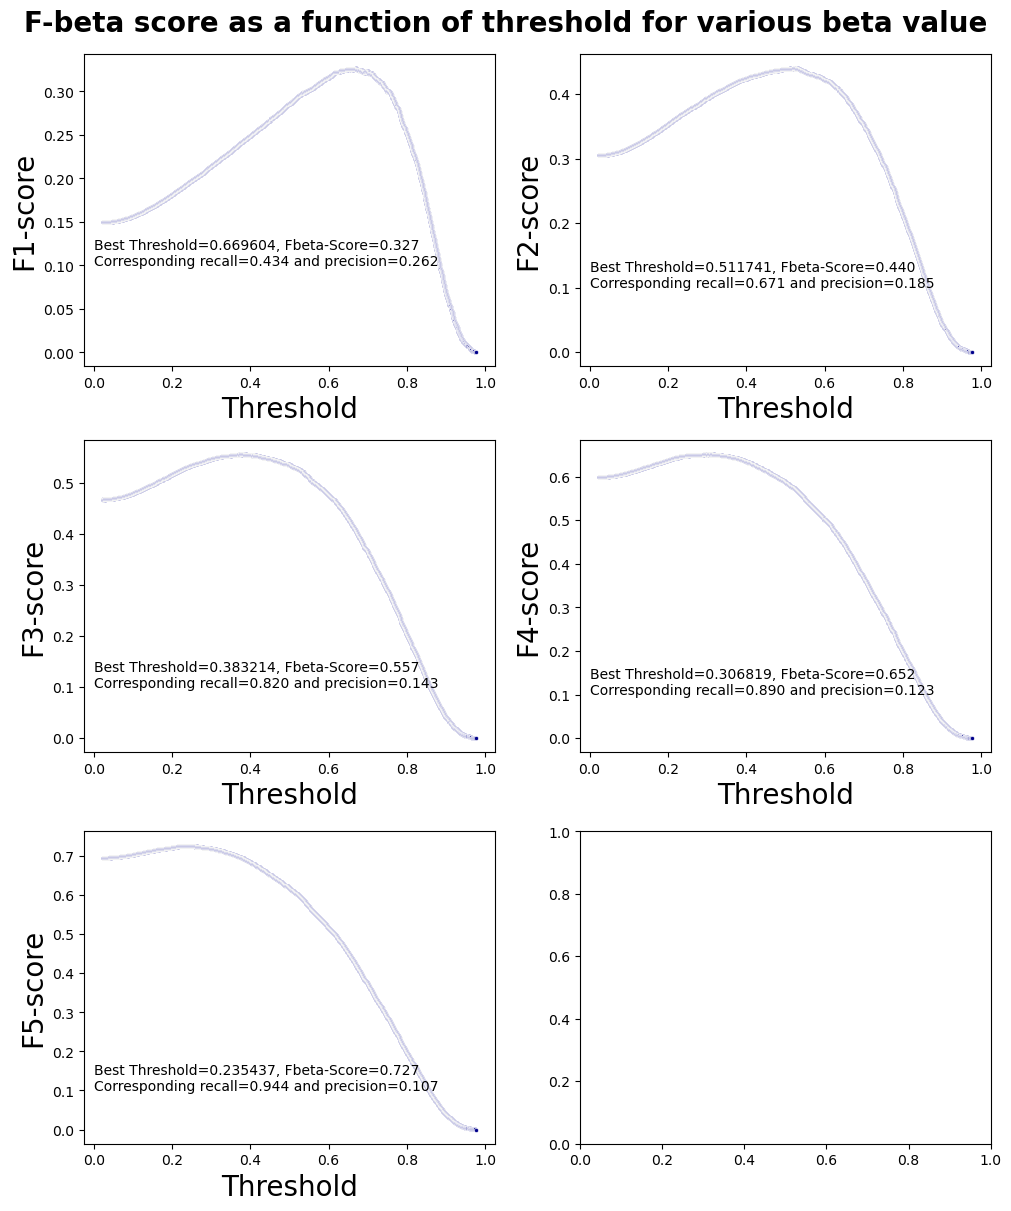

In [137]:
num_plots = 5
total_cols = 2
total_rows = num_plots//total_cols + 1

fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols,
                        figsize=(5*total_cols, 4*total_rows),
                        constrained_layout=True)
fig.suptitle('F-beta score as a function of threshold for various beta value', fontsize=20, fontweight='bold')

for beta in [1,2,3,4,5]:
    fbeta_score = (1 + (beta * beta)) * ((precision * recall) / ((beta * beta * precision) + recall))
    # locate the index of the largest fbeta_score with beta=3
    ix = np.argmax(fbeta_score[:-2])
    #
    #row = (beta-1)//5
    #pos = (beta-1) % 5
    
    
    row = (beta-1)//total_cols
    pos = (beta-1) % total_cols
    plot = sns.scatterplot(thresholds, fbeta_score[:-1], marker='.', color='darkblue', ax=axs[row][pos])
    plot.set_ylabel('F{}-score'.format(beta), fontsize=20)
    plot.set_xlabel('Threshold', fontsize=20)
    plot.text(0, 0.1, 'Best Threshold=%f, Fbeta-Score=%.3f\nCorresponding recall=%.3f and precision=%.3f' % (thresholds[ix], fbeta_score[ix], recall[ix], precision[ix]))


In [134]:
# threshold selected = 0.35, intermediate value between those given by f3 and f4-score.
# should provide a recall around 0.84 and precision around 0.13
thresh = 0.35

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Visualization

In [217]:
# transform probabilities predicted into classes according to the optimized threshold
y_pred_thresh = np.where(y_pred_proba_pos < thresh, 0, 1)
# Note: threshold optimized = to predict positive / minority / '1' class

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


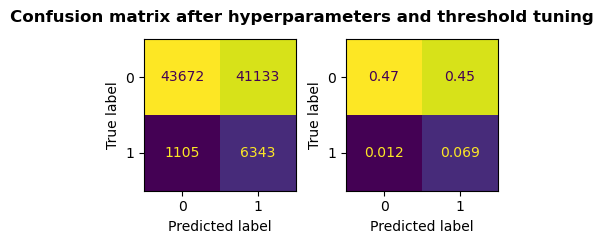

In [218]:
fig, axes = plt.subplots(1, 2, figsize=(4, 3), constrained_layout=True)
fig.suptitle('Confusion matrix after hyperparameters and threshold tuning', fontsize=12, fontweight='bold', y=0.85)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_thresh, colorbar=False, ax=axes[0])
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_thresh, colorbar=False, normalize='all', ax=axes[1])

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


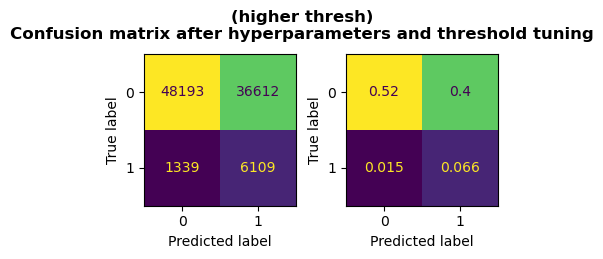

In [222]:
# and with higher threshold (corresponding to f3-score)
y_pred_thresh = np.where(y_pred_proba_pos < 0.383214, 0, 1)

fig, axes = plt.subplots(1, 2, figsize=(4, 3), constrained_layout=True)
fig.suptitle('(higher thresh)\nConfusion matrix after hyperparameters and threshold tuning', fontsize=12, fontweight='bold', y=0.9)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_thresh, colorbar=False, ax=axes[0])
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_thresh, colorbar=False, normalize='all', ax=axes[1])

# Test : reloading the model

In [161]:
loaded_model = joblib.load('Best_model.pkl')

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [162]:
y_pred_ = np.where(loaded_model.predict_proba(X_test)[:,1] < 0.35, 0, 1)

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


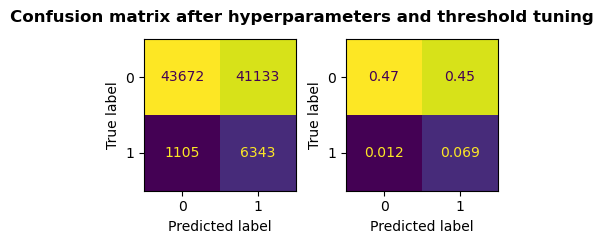

In [163]:
fig, axes = plt.subplots(1, 2, figsize=(4, 3), constrained_layout=True)
fig.suptitle('Confusion matrix after hyperparameters and threshold tuning', fontsize=12, fontweight='bold', y=0.85)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_, colorbar=False, ax=axes[0])
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_, colorbar=False, normalize='all', ax=axes[1])

# Model interpretation
## Feature importance

In [174]:
best_LGBM.steps[2][1]

LGBMClassifier(colsample_bytree=0.9689378601160874, is_unbalance=True,
               learning_rate=0.07069796948201046, max_depth=3,
               metric='average_precision_score', n_estimators=641,
               num_leaves=811, objective='binary', random_state =0,
               reg_alpha=0.0041598550604773155, reg_lambda=0.04095534909282651,
               subsample=0.9883532202220029)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Text(0.5, 1.0, 'Feature importance')

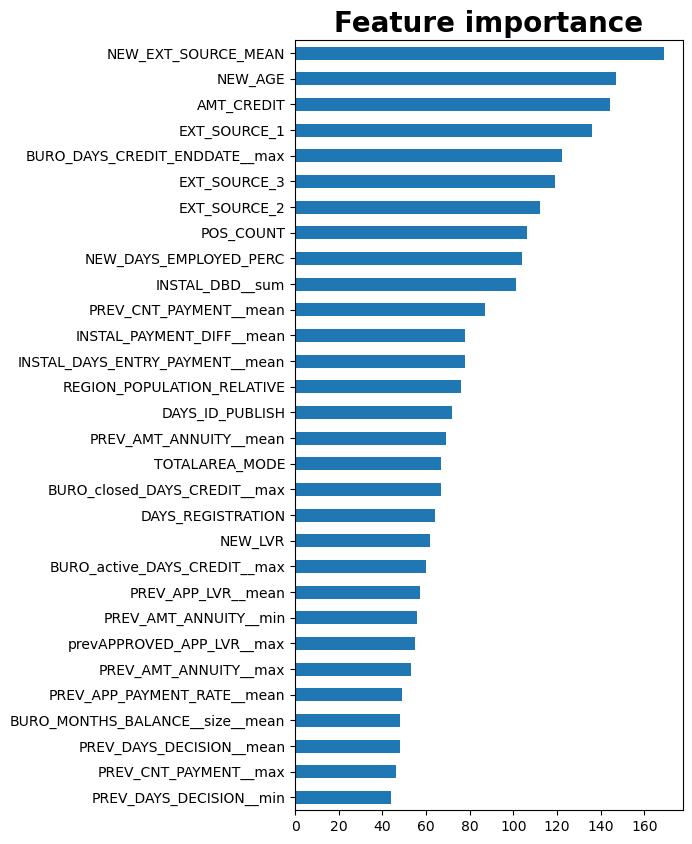

In [514]:
feat_importances = pd.Series(best_LGBM.steps[2][1].feature_importances_, index=col_names_short)
g = feat_importances.sort_values(ascending=True)[-30:].plot(kind='barh', figsize=(5,10))
#g.set_yticklabels([str(label)[12:50] for label in g.get_yticklabels()])
g.set_title('Feature importance', fontsize=20, fontweight='bold')

## SHAP
* **transforming (scaling) data to be used by SHAP evaluation of our classifier**

In [224]:
# first deconvolving the different steps of our pipeline
best_LGBM.named_steps

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'scaler': ColumnTransformer(remainder='passthrough',
                   transformers=[('standardscaler', StandardScaler(),
                                  [1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                   21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                   49, 50, 51, 57, 58, 59, ...])]),
 'undersampler': RandomUnderSampler(sampling_strategy=0.10327),
 'classifier': LGBMClassifier(colsample_bytree=0.9689378601160874, is_unbalance=True,
                learning_rate=0.07069796948201046, max_depth=3,
                metric='average_precision_score', n_estimators=641,
                num_leaves=811, objective='binary', random_state =0,
                reg_alpha=0.0041598550604773155, reg_lambda=0.04095534909282651,
                subsample=0.9883532202220029)}

In [228]:
scaling = best_LGBM.named_steps['scaler']
#undersampling = best_LGBM.named_steps['undersampler']
clf = best_LGBM.named_steps['classifier']

C:\Users\user\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [378]:
# transforming training set
X_train_scaled = scaling.transform(X_train)
#X_train_scaled_RUSed, y_train_RUSed = undersampling.fit_resample(X_train_scaled, y_train) # that's just for training the model!!
print(X_train.shape)
print(X_train_scaled.shape)

print('-' * 40)

# transforming testing set
X_test_scaled = scaling.transform(X_test)
#X_test_scaled_RUSed, y_test_RUSed = undersampling.fit_resample(X_test_scaled, y_test)
print(X_test.shape)
print(X_test_scaled.shape)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


(215254, 127)
(215254, 127)
----------------------------------------
(92253, 127)
(92253, 127)


In [379]:
# creating the SHAP explainer object for our classifier (TreeExplainer as LightGBM is a tree-based model)
explainer = shap.TreeExplainer(clf)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [386]:
# Running SHAP on test data // explaining the model's predictions on test data using SHAP
start_time = time.time()
shap_values = explainer.shap_values(X_test_scaled)
elapsed_time = time.time() - start_time

print('SHAP running time:', elapsed_time)

SHAP running time: 8.069206714630127


In [281]:
# activate visualizations
shap.initjs()

* **Verif: scaling / column order**

In [474]:
test_ = scaling.transform(X_test)
pd.DataFrame(test_, columns=X.columns).describe()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


CODE_GENDER  AMT_CREDIT_//_AMT_GOODS_PRICE  \
count  92253.000000                   92253.000000   
mean      -0.002723                       0.002309   
std        1.002581                       0.998699   
min       -1.378379                      -1.468949   
25%       -0.818929                      -0.784321   
50%       -0.219075                      -0.145151   
75%        0.520395                       0.564050   
max        8.579835                       3.732796   

       REGION_POPULATION_RELATIVE  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
count                92253.000000       92253.000000     40142.000000   
mean                     0.000613           0.000534        -0.000314   
std                      1.000371           1.001165         0.996997   
min                     -5.231873          -2.785129        -2.305750   
25%                     -0.706097          -0.863896        -0.798914   
50%                      0.135921          -0.171351         0.015823   
75%                      0.848485           0.844602         0.813981   
max                      1.415697           1.984485         2.101502   

       FLAG_WORK_PHONE  REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
count     92066.000000            74144.000000            91973.000000   
mean          0.003741               -0.000944               -0.000848   
std           1.002275                0.997606                0.984487   
min          -2.692990               -2.617577               -0.319843   
25%          -0.633005               -0.719353               -0.319843   
50%           0.274385                0.124957               -0.319843   
75%           0.787421                0.811069               -0.319843   
max           1.785067                1.932227               13.051475   

       LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  ...  \
count             91973.000000  92252.000000  ...   
mean                  0.001051     -0.003222  ...   
std                   0.988565      0.998871  ...   
min                  -0.274909     -4.026088  ...   
25%                  -0.274909     -0.735033  ...   
50%                  -0.274909      0.243094  ...   
75%                  -0.274909      0.831906  ...   
max                  16.232957      1.163187  ...   

       INSTAL_DAYS_ENTRY_PAYMENT__mean_//_POS_MONTHS_BALANCE__mean  \
count                                       87368.000000             
mean                                            0.049467             
std                                             0.165187             
min                                             0.000000             
25%                                             0.000000             
50%                                             0.000000             
75%                                             0.000000             
max                                             1.000000             

       CC_AMT_DRAWINGS_CURRENT__mean  \
count                   87368.000000   
mean                        0.229165   
std                         0.243277   
min                         0.000000   
25%                         0.000000   
50%                         0.200000   
75%                         0.400000   
max                         1.000000   

       CC_AMT_DRAWINGS_CURRENT__std_//_CC_AMT_DRAWINGS_CURRENT__max  \
count                                       87368.000000              
mean                                            0.238780              
std                                             0.293415              
min                                             0.000000              
25%                                             0.000000              
50%                                             0.142857              
75%                                             0.400000              
max                                             1.000000              

       CC_AMT_TOTAL_RECEIVABLE__min_//_CC_AMT_RECIVABLE__min_//_CC_AMT_RECEIVABLE_PRIN

In [460]:
test = pd.DataFrame(X_test_scaled, columns=X.columns)
test

CODE_GENDER  AMT_CREDIT_//_AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
0        -0.712588                       0.564050                   -0.557055   
1        -1.278125                       0.127674                    0.868925   
2        -0.874874                       0.756726                   -0.575224   
3        -1.292268                       0.715242                    0.004763   
4        -0.539204                      -0.204486                   -0.349531   
...            ...                            ...                         ...   
92248    -0.175852                      -0.010509                    0.923999   
92249    -0.371368                       0.311171                   -0.100844   
92250    -0.360179                      -0.407425                    0.682693   
92251     1.306982                       0.399921                    1.000650   
92252    -0.311574                       1.079273                    1.409735   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_WORK_PHONE  \
0               1.288627        -0.892091        -2.636096   
1              -0.983186              NaN        -0.476061   
2               0.018850        -0.873771         0.358156   
3              -0.565671              NaN        -1.287646   
4              -0.562358              NaN        -1.856696   
...                  ...              ...              ...   
92248          -0.100440              NaN        -0.467138   
92249          -0.826784              NaN        -1.095175   
92250          -0.362878              NaN         0.736434   
92251           1.046070              NaN         0.558629   
92252          -0.561695              NaN         1.198086   

       REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
0                   -0.372494               -0.319843   
1                    1.508374               -0.319843   
2                   -0.059696               -0.319843   
3                         NaN               -0.319843   
4                   -0.525956               -0.319843   
...                       ...                     ...   
92248                1.099399               -0.319843   
92249                1.430729               -0.319843   
92250                0.643462               -0.319843   
92251               -0.623503                1.908710   
92252               -0.632291               -0.319843   

       LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  ...  \
0                    -0.274909      0.801679  ...   
1                    -0.274909      1.163187  ...   
2                    -0.274909      0.399063  ...   
3                    -0.274909      0.952811  ...   
4                    -0.274909      0.639665  ...   
...                        ...           ...  ...   
92248                -0.274909      0.822233  ...   
92249                -0.274909     -1.961017  ...   
92250                -0.274909     -0.656444  ...   
92251                 2.476402      0.733972  ...   
92252                -0.274909      0.344655  ...   

       INSTAL_DAYS_ENTRY_PAYMENT__mean_//_POS_MONTHS_BALANCE__mean  \
0                                               0.000000             
1                                                    NaN             
2                                               0.000000             
3                                               0.000000             
4                                               0.000000             
...                                                  ...             
92248                                           0.000000             
92249                                           0.000000             
92250                                           0.000000             
92251                                           0.222222             
92252                                           0.200000             

       CC_AMT_DRAWINGS_CURRENT__mean  \
0                           0.555556   
1                                NaN   
2     

In [461]:
test.columns.tolist()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


['CODE_GENDER',
 'AMT_CREDIT_//_AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_WORK_PHONE',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'ELEVATORS_MEDI_//_ELEVATORS_AVG_//_ELEVATORS_MODE',
 'FLOORSMAX_MEDI_//_FLOORSMAX_AVG_//_FLOORSMAX_MODE',
 'TOTALAREA_MODE_//_LIVINGAREA_AVG_//_LIVINGAREA_MEDI_//_LIVINGAREA_AVG_//_LIVINGAREA_MODE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'NEW_DAYS_EMPLOYED_PERC_//INV_DAYS_EMPLOYED',
 'NEW_LVR',
 'NEW_EXT_SOURCE_MEAN',
 'NEW_EXT_SOURCE_STD',
 'NEW_AGE_//INV_DAYS_BIRTH',
 'NEW_PROD_CRED_SALARY',
 'NAME_CONTRACT_TYPE_Revolving loans_//INV_NAME_CONTRACT_TYPE_Cash loans',
 'NAME_INCOME_TYPE_Working',
 'NAME_EDUCATION_TYPE_Higher education',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'NAME_FAMILY_STATUS_Single / not married',
 'NAME_HOUSING_TYPE_House / apartme

In [462]:
test['ELEVATORS_MEDI_//_ELEVATORS_AVG_//_ELEVATORS_MODE'].min()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


-3.399711463626615

In [465]:
X_test['ELEVATORS_MEDI_//_ELEVATORS_AVG_//_ELEVATORS_MODE'].max()

1.0

In [476]:
pd.set_option('display.max_columns', None)
test.describe()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


CODE_GENDER  AMT_CREDIT_//_AMT_GOODS_PRICE  \
count  92253.000000                   92253.000000   
mean      -0.002723                       0.002309   
std        1.002581                       0.998699   
min       -1.378379                      -1.468949   
25%       -0.818929                      -0.784321   
50%       -0.219075                      -0.145151   
75%        0.520395                       0.564050   
max        8.579835                       3.732796   

       REGION_POPULATION_RELATIVE  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
count                92253.000000       92253.000000     40142.000000   
mean                     0.000613           0.000534        -0.000314   
std                      1.000371           1.001165         0.996997   
min                     -5.231873          -2.785129        -2.305750   
25%                     -0.706097          -0.863896        -0.798914   
50%                      0.135921          -0.171351         0.015823   
75%                      0.848485           0.844602         0.813981   
max                      1.415697           1.984485         2.101502   

       FLAG_WORK_PHONE  REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
count     92066.000000            74144.000000            91973.000000   
mean          0.003741               -0.000944               -0.000848   
std           1.002275                0.997606                0.984487   
min          -2.692990               -2.617577               -0.319843   
25%          -0.633005               -0.719353               -0.319843   
50%           0.274385                0.124957               -0.319843   
75%           0.787421                0.811069               -0.319843   
max           1.785067                1.932227               13.051475   

       LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  \
count             91973.000000  92252.000000  92253.000000  92169.000000   
mean                  0.001051     -0.003222     -0.001498     -0.003536   
std                   0.988565      0.998871      0.996270      1.019336   
min                  -0.274909     -4.026088     -0.951238     -7.283130   
25%                  -0.274909     -0.735033     -0.791743     -0.998454   
50%                  -0.274909      0.243094     -0.296803     -0.035074   
75%                  -0.274909      0.831906      0.461453      0.607179   
max                  16.232957      1.163187      4.352075     39.547842   

       ELEVATORS_MEDI_//_ELEVATORS_AVG_//_ELEVATORS_MODE  \
count                                       92205.000000   
mean                                            0.000594   
std                                             1.000434   
min                                            -3.399711   
25%                                            -0.641971   
50%                                             0.103621   
75%                                             0.758426   
max                                             2.326420   

       FLOORSMAX_MEDI_//_FLOORSMAX_AVG_//_FLOORSMAX_MODE  \
count                                       92205.000000   
mean                                            0.000425   
std                                             0.997193   
min                                            -1.257312   
25%                                            -0.821372   
50%                                            -0.141928   
75%                                             0.648800   
max                                             4.590230   

       TOTALAREA_MODE_//_LIVINGAREA_AVG_//_LIVINGAREA_MEDI_//_LIVINGAREA_AVG_//_LIVINGAREA_MODE  \
count                                       92253.000000                                          
mean                                           -0.002622                                          
std                                             0.999204                                          
min                              

In [477]:
X_test.describe()

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


CODE_GENDER  AMT_CREDIT_//_AMT_GOODS_PRICE  \
count  92253.000000                   9.225300e+04   
mean       0.658569                   5.982619e+05   
std        0.474192                   4.032188e+05   
min        0.000000                   4.500000e+04   
25%        0.000000                   2.700000e+05   
50%        1.000000                   5.112495e+05   
75%        1.000000                   8.086500e+05   
max        1.000000                   4.050000e+06   

       REGION_POPULATION_RELATIVE  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
count                92253.000000       92253.000000     92253.000000   
mean                     0.020890       -4984.620240     -2993.637356   
std                      0.013819        3523.798789      1510.684541   
min                      0.000533      -23416.000000     -7197.000000   
25%                      0.010006       -7474.000000     -4298.000000   
50%                      0.018850       -4508.000000     -3253.000000   
75%                      0.028663       -1998.000000     -1720.000000   
max                      0.072508           0.000000         0.000000   

       FLAG_WORK_PHONE  REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
count     92253.000000            92253.000000            92253.000000   
mean          0.198758                0.078198                0.230529   
std           0.399067                0.268484                0.421174   
min           0.000000                0.000000                0.000000   
25%           0.000000                0.000000                0.000000   
50%           0.000000                0.000000                0.000000   
75%           0.000000                0.000000                0.000000   
max           1.000000                1.000000                1.000000   

       LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  \
count             92253.000000  40142.000000  92066.000000  74144.000000   
mean                  0.179225      0.502083      0.514892      0.510728   
std                   0.383542      0.210619      0.191364      0.194517   
min                   0.000000      0.015053      0.000006      0.000527   
25%                   0.000000      0.333376      0.393318      0.370650   
50%                   0.000000      0.505492      0.566566      0.535276   
75%                   0.000000      0.674105      0.664520      0.669057   
max                   1.000000      0.946098      0.855000      0.887664   

       ELEVATORS_MEDI_//_ELEVATORS_AVG_//_ELEVATORS_MODE  \
count                                       43183.000000   
mean                                            0.077612   
std                                             0.134330   
min                                             0.000000   
25%                                             0.000000   
50%                                             0.000000   
75%                                             0.120000   
max                                             1.000000   

       FLOORSMAX_MEDI_//_FLOORSMAX_AVG_//_FLOORSMAX_MODE  \
count                                       46429.000000   
mean                                            0.225568   
std                                             0.145041   
min                                             0.000000   
25%                                             0.166700   
50%                                             0.166700   
75%                                             0.333300   
max                                             1.000000   

       TOTALAREA_MODE_//_LIVINGAREA_AVG_//_LIVINGAREA_MEDI_//_LIVINGAREA_AVG_//_LIVINGAREA_MODE  \
count                                       47868.000000                                          
mean                                            0.102732                                          
std                                             0.107906                                          
min                              

non-bin feature indices :[1, 2, 3, 4, 9, 10, 11, 15, 16, 17, 18, 19, 20,
                                   21, 22, 23, 41, 42, 43, 44, 45, 46, 47, 48,
                                   49, 50, 51, 57, 58, 59,...]
                                   
---------------
                                   
==> Columns order is not the same before vs after scaling --> after scaling, we have scaled features first, then non scaled.

In [501]:
# defining ordered list of col names:
col_names = [] # to reset
col_names = non_bin_names.copy()
for col in bin_names:
    col_names.append(col)
col_names_short = [lab.split('_//', 1)[0] for lab in col_names]
print(col_names)
print('-' * 50)
print(col_names_short)

['AMT_CREDIT_//_AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'NEW_DAYS_EMPLOYED_PERC_//INV_DAYS_EMPLOYED', 'NEW_LVR', 'NEW_EXT_SOURCE_MEAN', 'NEW_EXT_SOURCE_STD', 'NEW_AGE_//INV_DAYS_BIRTH', 'NEW_PROD_CRED_SALARY', 'BURO_DAYS_CREDIT__min_//_BURO_MONTHS_BALANCE__min__min_//_BURO_closed_DAYS_CREDIT__min_//_BURO_closed_MONTHS_BALANCE__min__min_//_BURO_closed_MONTHS_BALANCE__min__min', 'BURO_DAYS_CREDIT__max', 'BURO_DAYS_CREDIT__mean', 'BURO_DAYS_CREDIT__var', 'BURO_DAYS_CREDIT_ENDDATE__min', 'BURO_DAYS_CREDIT_ENDDATE__max_//_BURO_active_DAYS_CREDIT_ENDDATE__max', 'BURO_DAYS_CREDIT_ENDDATE__mean', 'BURO_DAYS_CREDIT_UPDATE__mean', 'BURO_CREDIT_ACTIVE_Active__count__max_//_BURO_closed_CREDIT_ACTIVE_Active__count__max', 'BURO_CREDIT_ACTIVE_Closed__count__max', 'BURO_MONTHS_BALANCE__size__mean_//_BURO_closed_MONTHS_BALANCE_

In [502]:
len(bin_names)

54

In [503]:
len(non_bin_names)

73

In [505]:
len(col_names_short)

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


127

* **Verif: predicted proba are the same when calculated through the pipeline vs through scaling + clf**

In [365]:
y_pred_proba_pos

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


array([0.78502523, 0.3104069 , 0.49737686, ..., 0.45654123, 0.47065224,
       0.29909701])

In [377]:
test = clf.predict_proba(X_test_scaled)[:,1]
test

array([0.78502523, 0.3104069 , 0.49737686, ..., 0.45654123, 0.47065224,
       0.29909701])

In [369]:
# equiv to y_pred_proba_pos
test2 = best_LGBM.predict_proba(X_test)[:,1]
test2

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


array([0.78502523, 0.3104069 , 0.49737686, ..., 0.45654123, 0.47065224,
       0.29909701])

* **Verif: SHAP base value = mean of all predicted probabilities**

In [417]:
print(explainer.expected_value)

[0.5224664169653608, -0.5224664169653608]


In [418]:
np.mean(best_LGBM.predict_proba(X_test)[:,1])

0.39150813602650064

In [420]:
np.mean(best_LGBM.predict(X_test))

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


0.3060063087379272

In [ ]:
# no idea where this expected value is coming from / what it represents... 
# from my understanding, it's supposed to represent the mean of all probabilities

### global interpretation

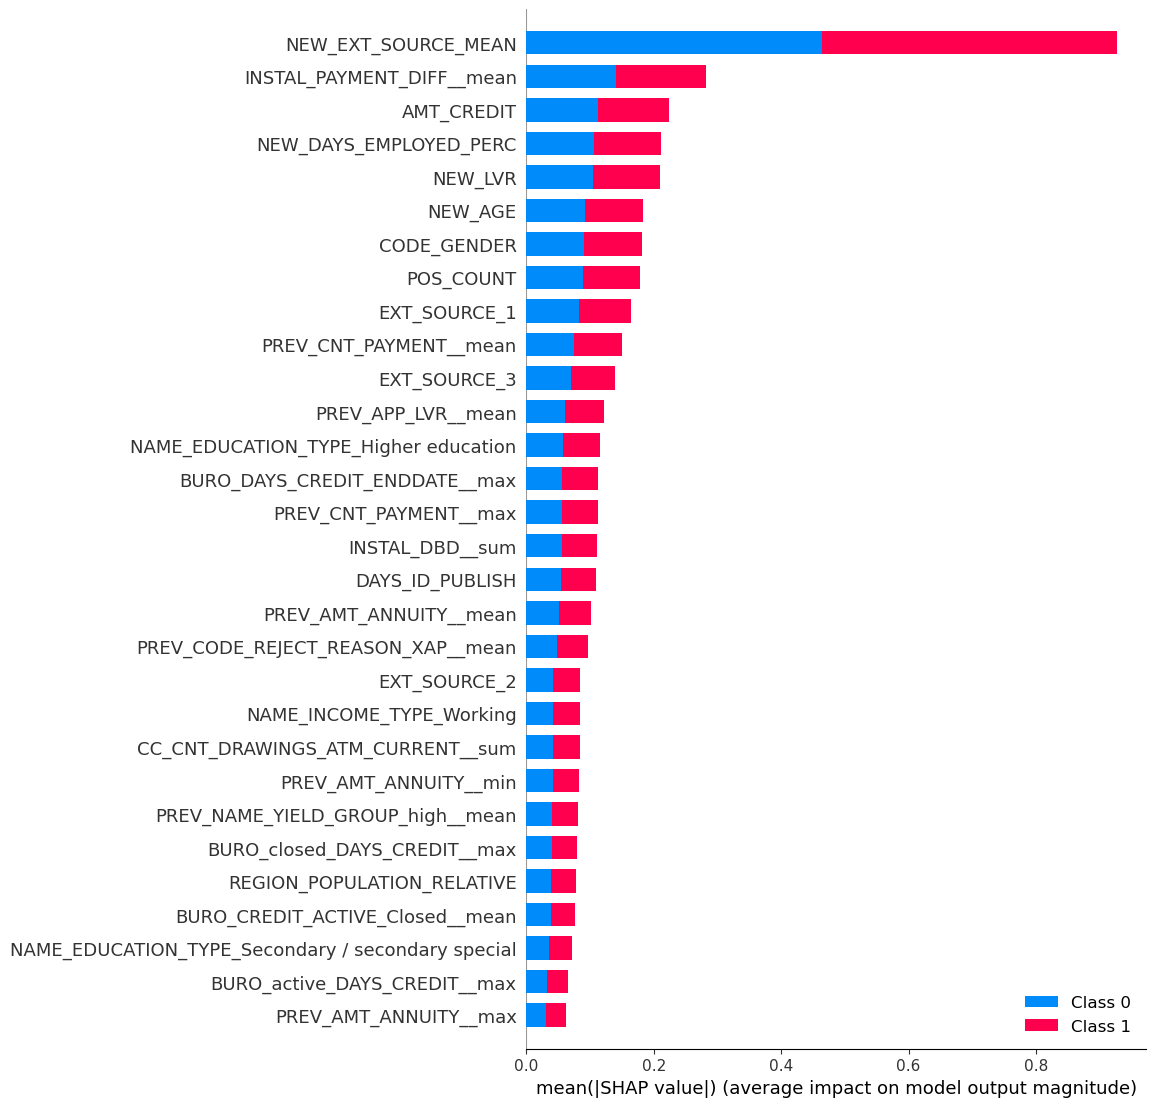

In [515]:
#shap.summary_plot(shap_values, pd.DataFrame(X_test_scaled, columns=[lab[0] for lab in X_test.columns.str.split('_//', 1)]))
shap.summary_plot(shap_values, pd.DataFrame(X_test_scaled, columns=col_names_short), max_display=30)

### local interpretation
* **force plot**

In [507]:
# visualize the explanation for a prediction in class 0 (loan repaid)
sample_idx = 0
if y_test.iloc[sample_idx] == 0:
    loan = '(loan repaid)'
else: loan = '(loan unrepaid)'

print('True class of the sample:', y_test.iloc[sample_idx], loan)
shap.force_plot(explainer.expected_value[1], # [1] = for positive/minority class
                shap_values[1][sample_idx,:],
                pd.DataFrame(X_test_scaled,
                             columns=col_names_short).iloc[0,:])

True class of the sample: 0 (loan repaid)


----
VERIF: f(x) = predicted proba ==> not the case, as with base_value, I don't know why, as with base_value too... but they also have f(x) values outside the 0-1 range here https://slundberg.github.io/shap/notebooks/tree_explainer/Census%20income%20classification%20with%20LightGBM.html
which comes from https://github.com/slundberg/shap

In [433]:
explainer.expected_value[1] + np.sum(shap_values[1][0])

1.2951951847543361

In [430]:
best_LGBM.predict_proba(X_test)[0,1]

0.7850252299604359

In [431]:
y_pred_proba_pos[0]

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


0.7850252299604359

But issue solved with ``link='logit'`` !!!!!!

In [508]:
# visualize the explanation for a prediction in class 0 (loan repaid)
sample_idx = 0

if y_test.iloc[sample_idx] == 0: loan = '(loan repaid)'
else: loan = '(loan unrepaid)'

if y_pred_thresh[sample_idx] == 1: grant = '--Loan not granted'
else: grant = '--Loan granted !!'

print('True class of the sample:', y_test.iloc[sample_idx], loan)
print('predicted proba:', round(y_pred_proba_pos[sample_idx], 2))
print('##### MODEL CLASSIFICATION:', y_pred_thresh[sample_idx], grant)
shap.force_plot(explainer.expected_value[1], # [1] = for positive/minority class
                shap_values[1][sample_idx,:],
                pd.DataFrame(X_test_scaled,
                             columns=col_names_short).iloc[0,:],
                link='logit')

True class of the sample: 0 (loan repaid)
predicted proba: 0.79
##### MODEL CLASSIFICATION: 1 --Loan not granted


------

In [509]:
# visualize the explanation for a prediction in class 1 (loan unrepaid)
for sample_idx in range(len(y_test)):
    if y_test.iloc[sample_idx] == 1:
        loan = '(loan unrepaid)'
        print(sample_idx)
        break

if y_pred_thresh[sample_idx] == 1: grant = '--Loan not granted'
else: grant = '--Loan granted !!'

print('True class of the sample:', y_test.iloc[sample_idx], loan)
print('predicted proba:', round(y_pred_proba_pos[sample_idx], 2))
print('##### MODEL CLASSIFICATION:', y_pred_thresh[sample_idx], grant)
shap.force_plot(explainer.expected_value[1],
                shap_values[1][sample_idx,:],
                pd.DataFrame(X_test_scaled,
                             columns=col_names_short).iloc[0,:],
                link='logit')

6
True class of the sample: 1 (loan unrepaid)
predicted proba: 0.52
##### MODEL CLASSIFICATION: 1 --Loan not granted


In [510]:
# visualize the explanation for a prediction
sample_idx = 72121

if y_test.iloc[sample_idx] == 0: loan = '(loan repaid)'
else: loan = '(loan unrepaid)'

if y_pred_thresh[sample_idx] == 1: grant = '--Loan not granted'
else: grant = '--Loan granted !!'
    
print(sample_idx)
print('True class of the sample:', y_test.iloc[sample_idx], loan)
print('predicted proba:', round(y_pred_proba_pos[sample_idx], 2))
print('##### MODEL CLASSIFICATION:', y_pred_thresh[sample_idx], grant)
shap.force_plot(explainer.expected_value[1],
                shap_values[1][sample_idx,:],
                pd.DataFrame(X_test_scaled,
                             columns=col_names_short).iloc[0,:],
                link='logit')

72121
True class of the sample: 0 (loan repaid)
predicted proba: 0.24
##### MODEL CLASSIFICATION: 0 --Loan granted !!


* **waterfall plot** ==> ``link='logit'`` not supported for these plots, so base_value and predicted values are not real values

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


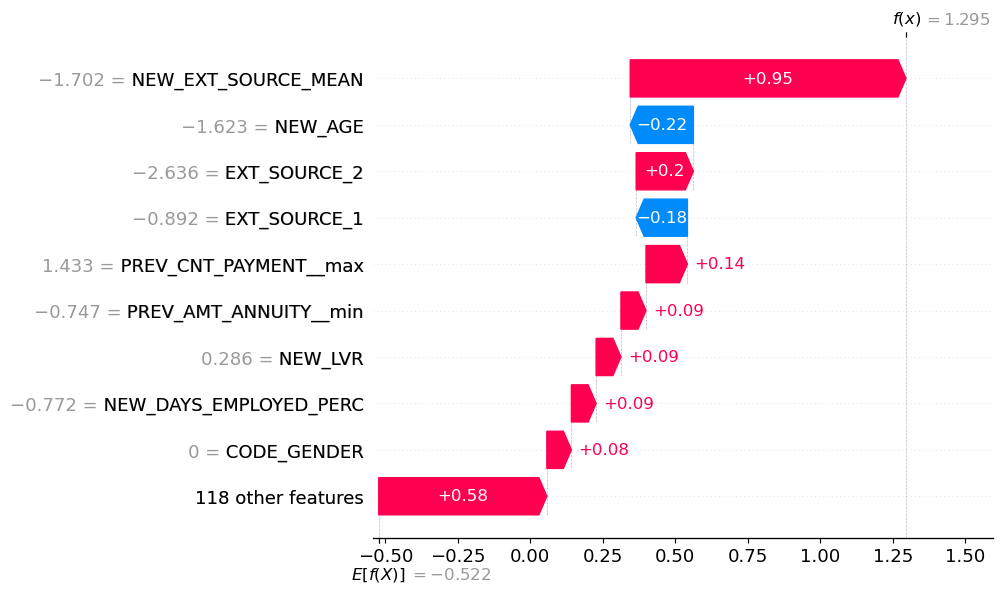

In [511]:
# Classical way to plot it doesn't work, had to do this to get a plot:
class ShapObject:
    
    def __init__(self, base_values, data, values, feature_names):
        self.base_values = base_values # Single value
        self.data = data # Raw feature values for 1 row of data
        self.values = values # SHAP values for the same row of data
        self.feature_names = feature_names # Column names

        
        
        
# visualize the explanation for a prediction in class 0 (loan repaid)
sample_idx = 0
        
shap_object = ShapObject(base_values = explainer.expected_value[1],
                         values = explainer.shap_values(X_test_scaled)[1][sample_idx,:],
                         feature_names = col_names_short,
                         data = pd.DataFrame(X_test_scaled).iloc[sample_idx,:])

shap.waterfall_plot(shap_object)

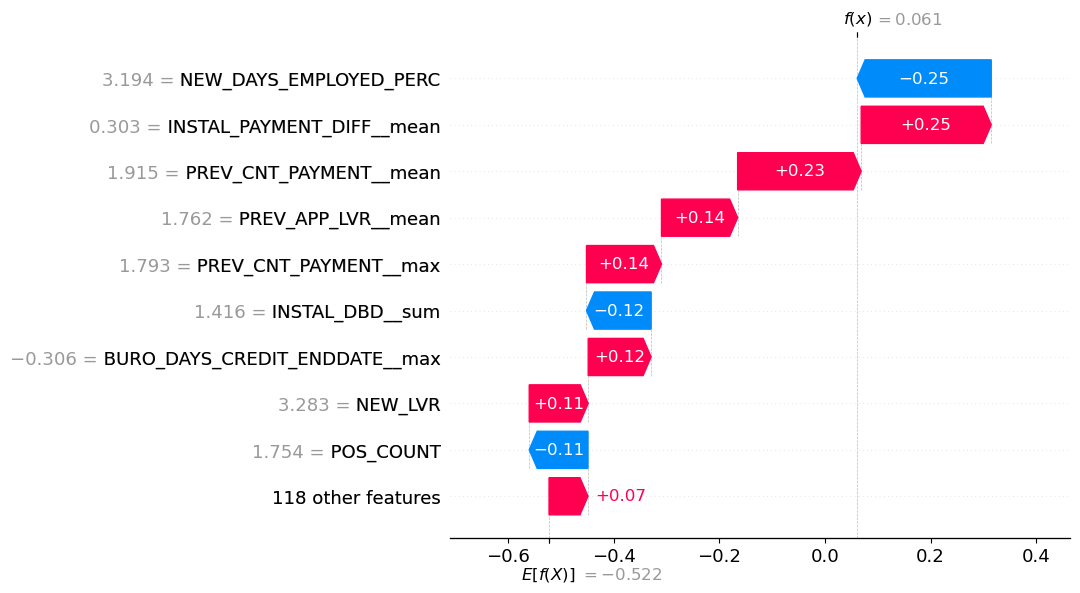

In [512]:
# visualize the explanation for a prediction in class 1 (loan unrepaid)
sample_idx = 6
        
shap_object = ShapObject(base_values = explainer.expected_value[1],
                         values = explainer.shap_values(X_test_scaled)[1][sample_idx,:],
                         feature_names = col_names_short,
                         data = pd.DataFrame(X_test_scaled).iloc[sample_idx,:])

shap.waterfall_plot(shap_object)

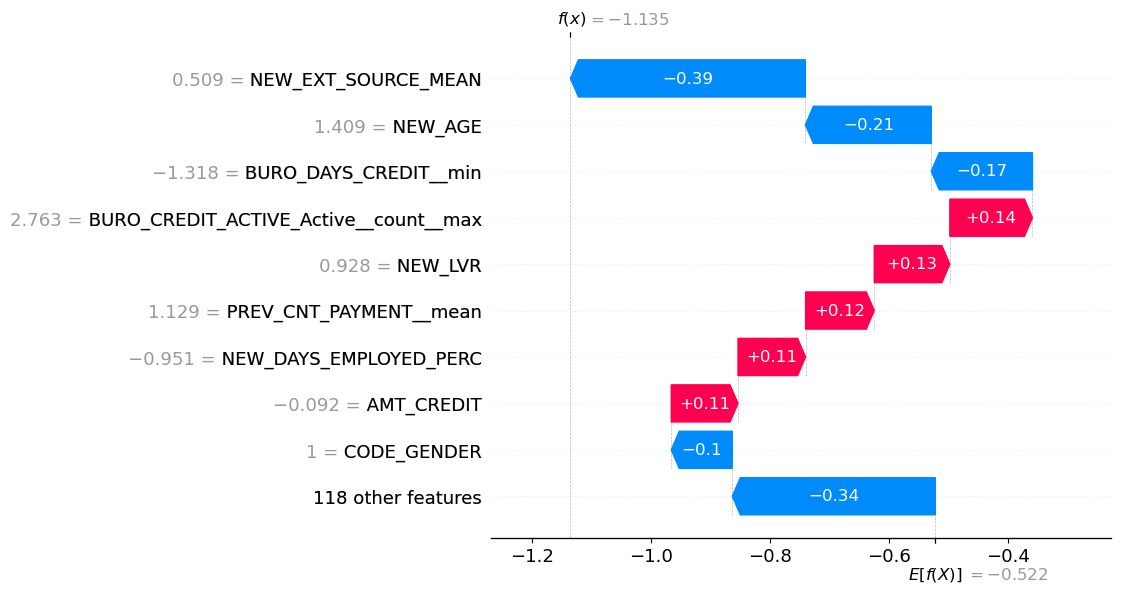

In [513]:
# visualize the explanation for a prediction in class 1 (loan unrepaid)
sample_idx = 72121
        
shap_object = ShapObject(base_values = explainer.expected_value[1],
                         values = explainer.shap_values(X_test_scaled)[1][sample_idx,:],
                         feature_names = col_names_short,
                         data = pd.DataFrame(X_test_scaled).iloc[sample_idx,:])

shap.waterfall_plot(shap_object)

"positively" sexist model: 
* CODE_GENDER = 1 = Female = lower the probability not to repay the loan
* CODE_GENDER = 0 = Male = increase the probability not to repay the loan

In [326]:
# shap.plots.beeswarm(shap_values[1])

UnboundLocalError: local variable 'values' referenced before assignment

In [328]:
# shap.plots.bar(shap_values[0])

AssertionError: You must pass an Explanation object, Cohorts object, or dictionary to bar plot!

# Draft

In [343]:
a = clf.predict(X_test_scaled_RUSed, pred_contrib=True) # `pred_contrib=True` returns SHAP values for LightGBM
base_values = a[0, -1]  # The last column in the matrix is the base value.
shap_values = a[:, 0:-1]

In [348]:
shap.plots.waterfall(shap_values[0], base_values[0])

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


IndexError: invalid index to scalar variable.